In [1]:
import configargparse
import numpy as np
from cryoem.projections import *
import numpy as np
import os, sys
import scipy.io as sio
sys.path.append(os.getcwd())
import mrcfile
import astra
import pathlib
import h5py
from cryoem.rotation_matrices import RotationMatrix
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import quaternion2euler
import pickle
import os
import h5py
import numpy as np   

import sys
from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion
from cryoem.plots import plot_detector_pixels_with_protein, plot_images, plot_rays, plot_angles_histogram, plot_quaternions_histogram, plot_rotvec, plot_polar_plot, plot_projection, plot_projections

First step:
Load 3d data and visualize it

In [2]:
import nglview as nv
PROTEIN = "5j0n"
print(f"{PROTEIN}.mrc")
view_density_map = nv.show_file(f"{PROTEIN}.mrc")
view_density_map


5j0n.mrc


NGLWidget()

In [3]:
file_name = './data/5j0n.mrc'
with mrcfile.open(file_name) as mrcVol:
    Vol1      = np.array(mrcVol.data) 
    ProjSize1 = int(np.sqrt(np.sum(np.square(Vol1.shape))))
print(Vol1.shape)

(69, 57, 75)


In [4]:
import nglview as nv
PROTEIN = "5a1a"
print(f"{PROTEIN}.mrc")
view_density_map = nv.show_file(f"{PROTEIN}.mrc")
view_density_map


5a1a.mrc


NGLWidget()

In [5]:
file_name = '5a1a.mrc'
with mrcfile.open(file_name) as mrcVol:
    Vol2      = np.array(mrcVol.data) 
    ProjSize2 = int(np.sqrt(np.sum(np.square(Vol2.shape))))
print(Vol2.shape)

(110, 155, 199)


In [6]:
# Then make 2 vol the same size
#Here we resive the volumn to be 1/6
from scipy.ndimage import zoom
Vol1 = zoom(Vol1, (15/69, 15/57, 15/75))
print(Vol2.shape)
ProjSize1 = int(np.sqrt(np.sum(np.square(Vol1.shape))))
print(ProjSize1)

Vol2 = zoom(Vol2, (15/110, 15/155, 15/199))
print(Vol2.shape)
ProjSize2 = int(np.sqrt(np.sum(np.square(Vol2.shape))))
print(ProjSize2)

(110, 155, 199)
25
(15, 15, 15)
25


In [7]:
#Then load the angle data:
file_angle = 'notebooks/0-data-preparation/angle_data.pkl'
with open(file_angle, 'rb') as f:
    angles2 = pickle.load(f)
print(angles2[:4])

[[0.        0.        0.       ]
 [1.8860662 2.0739784 3.6501303]
 [3.948796  1.4204998 2.6239626]
 [1.0760686 0.9697671 3.369385 ]]


In [8]:
Projections1 = generate_projections_ASTRA(Vol1, angles2, ProjSize1, BatchSizeAstra = "None")
dtype = np.float32
Projections1 = np.array(Projections1, dtype=dtype)

Projections2 = generate_projections_ASTRA(Vol2, angles2, ProjSize1, BatchSizeAstra = "None")
dtype = np.float32
Projections2 = np.array(Projections2, dtype=dtype)

0.05595616


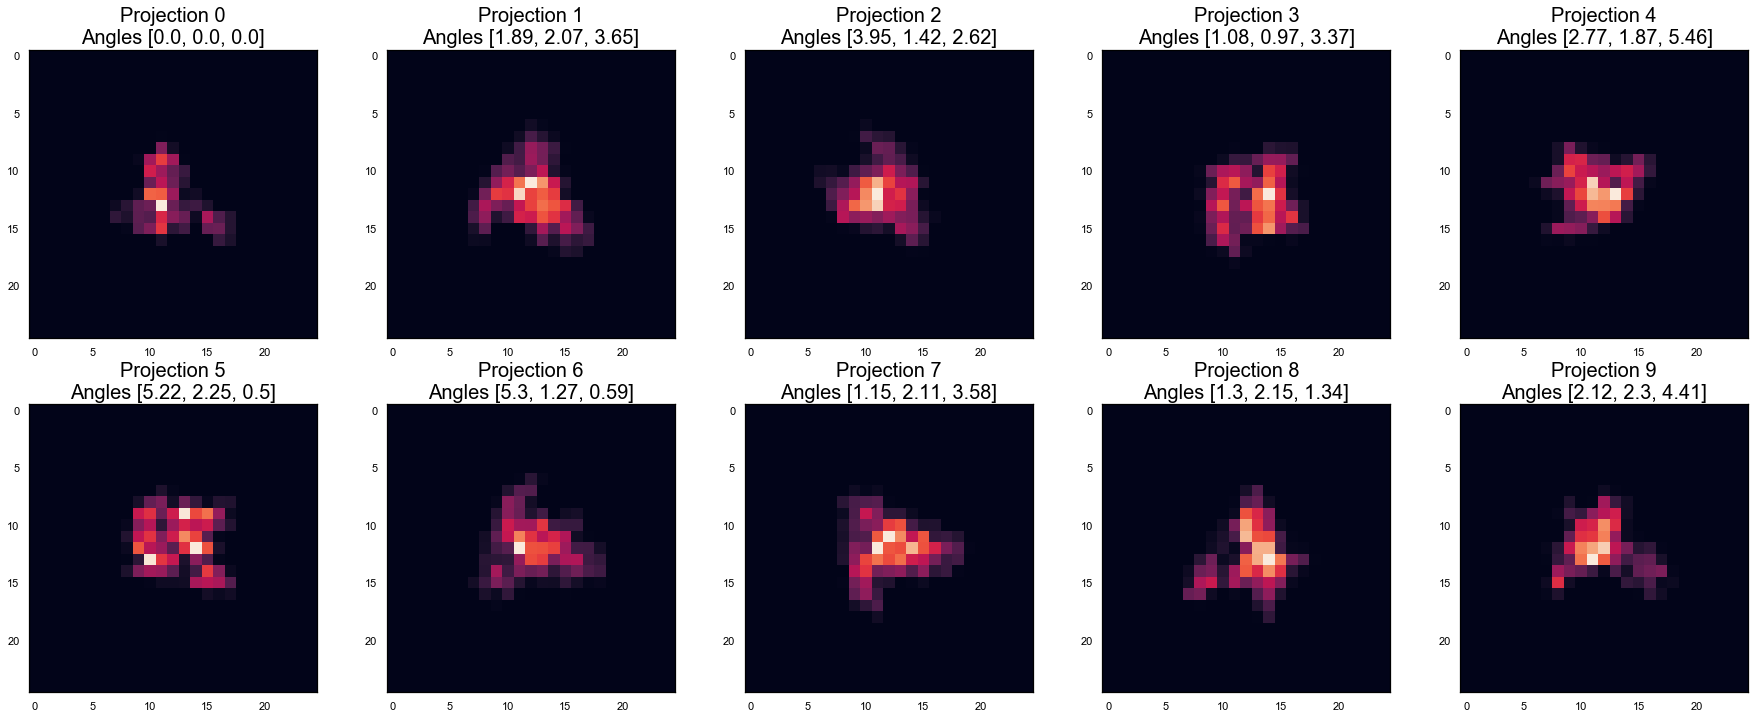

0.29594502


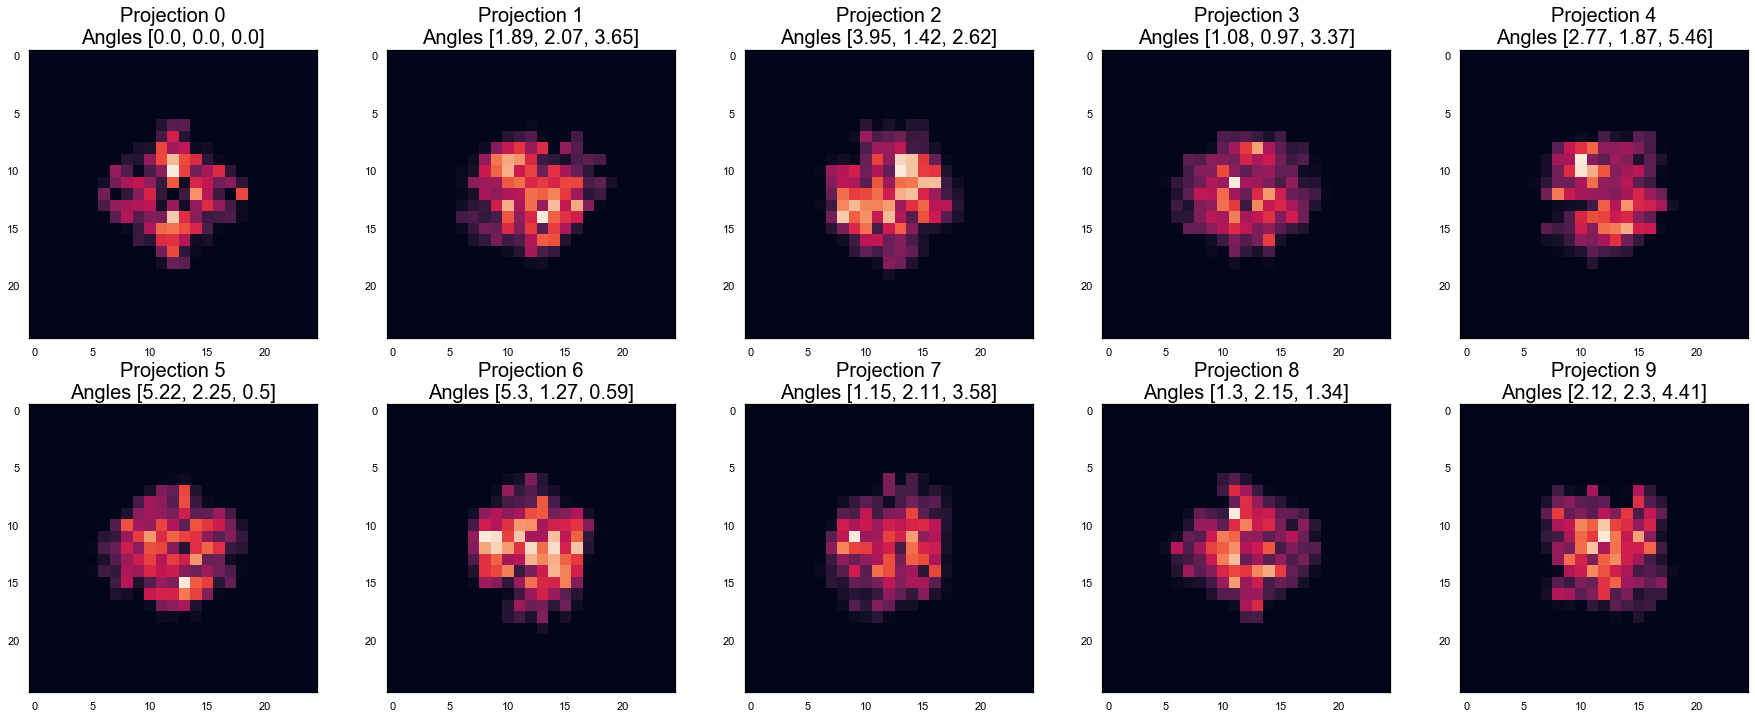

In [9]:
pids = range(10)
print(np.mean(Projections1))
plot_projections(Projections1[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

pids = range(10)
print(np.mean(Projections2))
plot_projections(Projections2[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

So by putting Vol, angle in functino: <br>
generate_projections_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None") <br>
, we can get AjS

In [10]:
BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")

NameError: name 'Projections' is not defined

In [ ]:
print(BP_data.shape)
print(BP_data[0].shape)
print(Projections[0].shape)
print(np.sum(BP_data[0] - Projections[0]))

In [ ]:
CheckProjections = generate_projections_ASTRA(BP_data, angles2[:10], ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

Before getting started, we now only get $\mu_s$, which should be mean subtracted. <br>
How about setting $\mu_s = 0$, and that $\mu_1 = vol$. <br>
Since for each image, $I_j = A_j (\mu_s + \mu z_j  )$ where $z_j \sim N(0,1)$ and we have $\mu_s = 0$,<br>
we have $I_j = A_j \mu z_j$
we can take $z_j$ out and make the formula : $I_j = z_j A_j \mu $


0.05595616


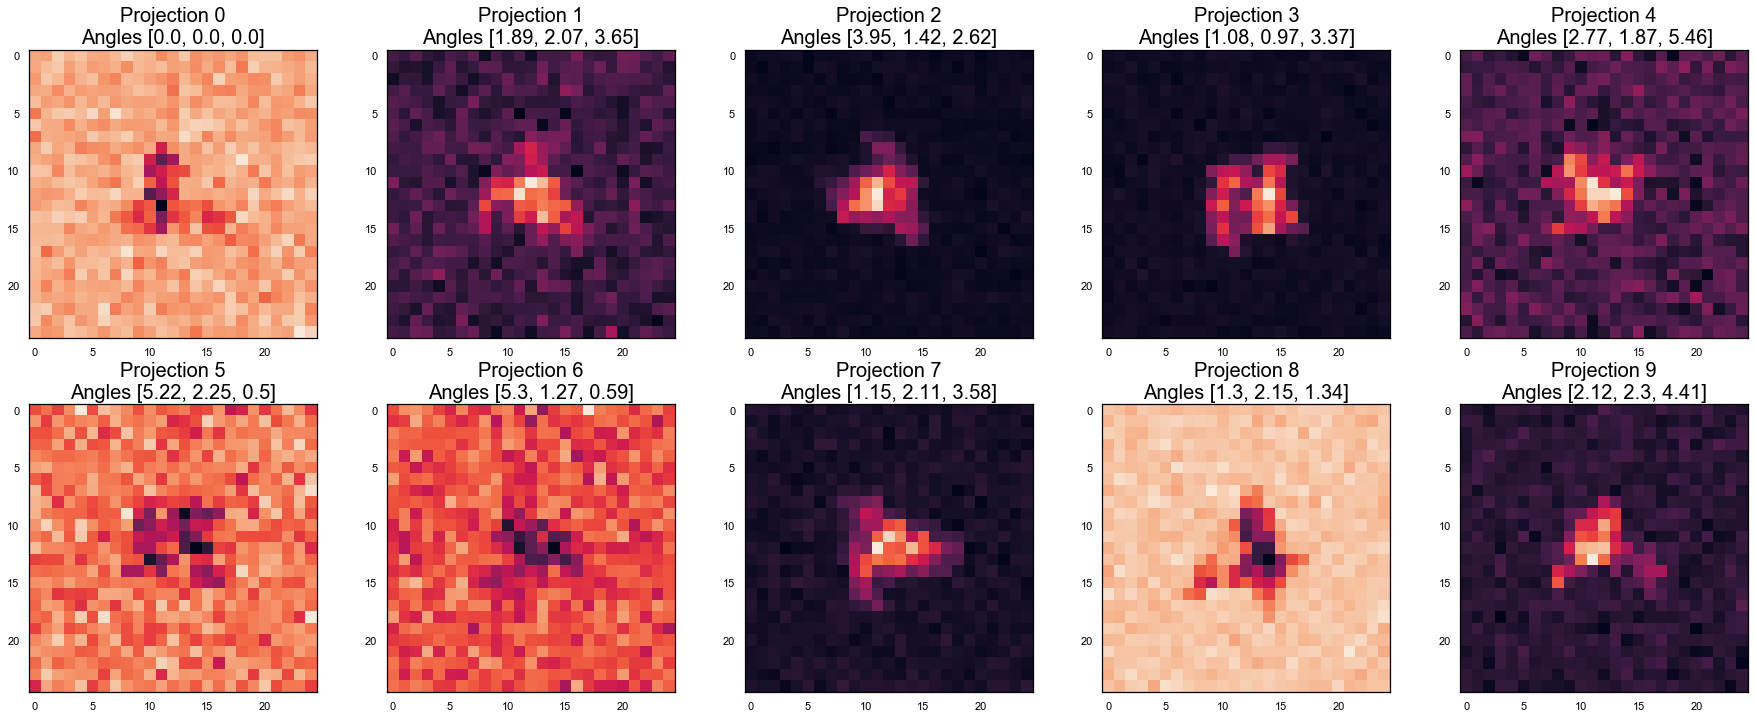

0.29594502


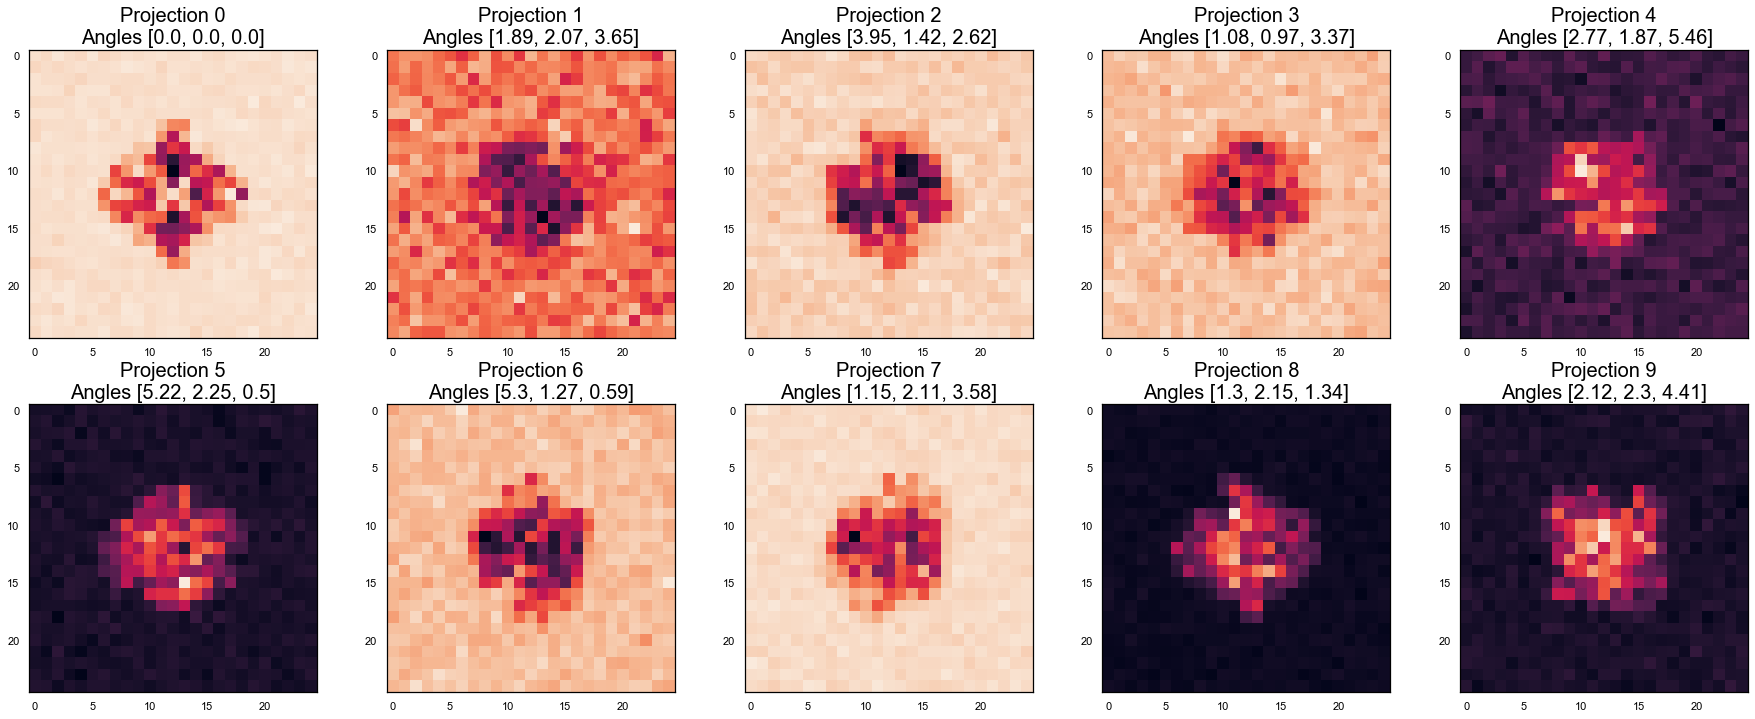

In [11]:
#Make I_j = z_j A_j mu
print(np.mean(Projections1))
True_z1 = np.random.randn(5000).reshape(5000, 1, 1)
True_sigma_21 = np.abs(np.random.randn(5000)) * 0.02 # mean = 0.055


Projections1 = Projections1 * True_z1

#add noise
for i in range(5000):
    Projections1[i] = Projections1[i] + np.random.randn(ProjSize1, ProjSize1) * True_sigma_21[i]**(0.5)
plot_projections(Projections1[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

#Make I_j = z_j A_j mu
print(np.mean(Projections2))
True_z2 = np.random.randn(5000).reshape(5000, 1, 1)
True_sigma_22 = np.abs(np.random.randn(5000)) * 0.02 # mean = 0.055


Projections2 = Projections2 * True_z2

#add noise
for i in range(5000):
    Projections2[i] = Projections2[i] + np.random.randn(ProjSize1, ProjSize1) * True_sigma_22[i]**(0.5)
plot_projections(Projections2[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)



In [12]:
new_projection = Projections2 + Projections1

In [13]:
class PCA_3d_Recon():
    def __init__(self, ProjSize, num_image, n_component):
        #init
        self.ProjSize  = ProjSize
        self.num_image = num_image
        self.n_component = n_component
        
        self.mu = np.zeros((ProjSize, ProjSize, ProjSize)) + 0.01
        self.sigma = np.ones(self.num_image) * 0.1
        
        self.ro = np.abs(np.ones((num_image, n_component)))
        self.BigSigma = np.abs(np.ones((self.num_image, self.n_component, self.n_component )))
        #print('original ro', self.ro[:5])
    def fit(self, Imgages, Angles):
        print('start fitting')
        print('The 0-th iteration')
        self.Plot_mu_by_projection(Angles)
        for i in range(1000):

            self.Expectation(Imgages, Angles)
            
            self.Maximization(Imgages, Angles)
            #self.Q_(Imgages, Angles)
            if i % 10 == 0:
            #    print(i)
                print(f'The {i+1}-th iteration')
                self.Plot_mu_by_projection(Angles)
        pass
    
    def Expectation(self, Imgages, Angles):
        """
        First, get all projection information
        
        ro_j = 1/sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1)(Au)^TI
        
        #We expect to get a n_image x n_component matrix for ro
        
        BigSigma = I - 1 / sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1) (Au)^TAu
        """
        
        self.Au_s(Angles)
        ro = [] #For n image, we have n z.
        for j in range(self.num_image):
            Ij = Imgages[j].reshape(-1, 1, order = 'F')
            roj = 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j])@(self.Aus[j].T @ Ij) 
            ro.append(roj[0][0])
        
        self.ro = np.array(ro).reshape(-1, self.n_component)
        #print(self.ro[:5])
        
        AllBigSigma = np.zeros((self.num_image, self.n_component, self.n_component ))
        for j in range(self.num_image):
            BigSigma = np.eye(self.n_component) - 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j]) @ self.Aus[j].T @ self.Aus[j]
            roj = self.ro[j].reshape(self.n_component , 1)
            BigSigma = BigSigma + roj@roj.T
            AllBigSigma[j] = BigSigma
            #print('BigSigma', BigSigma)
        self.BigSigma = AllBigSigma
        #print('updated BigSigma',self.BigSigma[:5])
        #print(self.BigSigma.shape)
        #print('updated ro', self.ro[:5])
        
        
        
    def Maximization(self, Images, Angles):
        #First update mu
        lr = 1e-8 * 2
        for i in range(5):
            #print('sigma',self.sigma[0])
            self.Au_s(Angles)
            #self.Q_(Images, Angles)
            DeltaMu = self.Delta_mu( Images, Angles)
            #print('np.mean(DeltaMu)', np.mean(DeltaMu))
            #print('self.mu', np.mean(self.mu))
            #print('ratio',  np.mean(self.mu) / np.mean(DeltaMu) )
            lr = np.abs(np.mean(self.mu) / np.mean(DeltaMu) )*0.001
            self.mu = self.mu + lr * DeltaMu #Gradient ascent
            self.Update_sigma(Images, Angles)
            
            
        #print(self.mu)
        pass
    def Update_sigma(self, Images, Angles):
        #self.sigma = 0 
        for j in range(self.num_image):
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ Ij - 2 * Ij.T @ self.Aus[j] * self.ro[j][self.n_component-1]
            
            right = self.Aus[j].T @ self.Aus[j] *self.BigSigma[j][0][0]
            
            self.sigma[j] = (1 / self.ProjSize **2 * (left + right ) ) ** 0.5 
            #for x in range(self.n_component):
            #    for y in range(self.n_component):
                    
    def Delta_mu(self, Images, Angles):
        """
        right_term = 
        delta mu = sum(1 / sigma_j**2 * () )
        """
        sum_all = []
        for j in range(self.num_image):
            temp = 0
            right_term = 0

            for i in range(self.n_component):
                right_term += right_term + self.Aus[j]*self.BigSigma[j][i][0]
            
            
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left_term = Ij* self.ro[j][self.n_component-1]
            temp = left_term - right_term
            temp = temp.reshape(self.ProjSize, self.ProjSize, order = 'F')
            
            sum_all.append( (1 / self.sigma[j]**2 * temp).tolist() )
        
        sum_all = np.array(sum_all)
        
        
        
        
        DeltaMu = back_projections_ASTRA( sum_all, Angles, self.ProjSize, BatchSizeAstra = "None")
        return DeltaMu
    
    def update_sigma(self):
        """
        
        """
        pass
    
    def Au_s(self, Angles):
        """
        By computing Au, given a angle a, we use
        Projections = generate_projectionaefmpss_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None")
        to generate lots of projections simultaneously
        """
        Projections = generate_projections_ASTRA(self.mu, Angles, self.ProjSize, BatchSizeAstra = "None")
        #print(Projections.shape)
        check_image = Projections[0].reshape(-1, 1, order = 'F')
        self.Aus =  Projections.reshape(Projections.shape[0], -1 , 1, order = 'F') #with fortrain - like order
        #print('check_Aus', check_image)
    def Au(self, angle, vol):
        """
        Only compute one Au
        """
        Single_Projections = generate_projections_ASTRA(vol, angle.reshape(1,3 ), self.ProjSize, BatchSizeAstra = "None")
        #print(Single_Projections.shape)
        return Single_Projections
    def AtI(self, Imgage, Angle): #only input one image, one angle
        """
        By computing AtI, we use backprojection algorithm
        BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")
        But since it can't compute all bps at the same time, we comute it one by one
        """
        Imgage = Imgage.reshape(1, Imgage.shape[0], Imgage.shape[1], order = 'F')
        Angle = Angle.reshape(1, Angle.shape[0])
        Bp = back_projections_ASTRA(Imgage, Angle, self.ProjSize, BatchSizeAstra = "None")
        #print(Bp.shape)
        return Bp
    
    def Q_(self,Images,  Angles, ):
        """
        might > 0 since IjT * Ij is droped.
        """
        sum_ = 0 
        for j in range(self.num_image):
            #print(j)
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ self.Au(Angles[j], self.mu).reshape(-1, 1, order = 'F') * self.ro[j]

            Aju =  self.Aus[j]
            right = Aju.T @ Aju *self.BigSigma[0][0] +1/2 * Aju.T @ Aju * self.BigSigma[0][0]
            
            sum_ += 1/ self.sigma[j]**2 *(left - right)
        print('Q', sum_[0][0])
        try:
            print('delta Q', sum_[0][0]- self.Q[0][0])
        except:
            pass
        self.Q = sum_
        #pass
    def Plot_mu_by_projection(self, Angles):
        #print(P3R.mu)
        curremt_mu = self.mu.reshape(self.ProjSize , self.ProjSize,self.ProjSize, order = 'F' )
        CheckProjections = generate_projections_ASTRA(curremt_mu, Angles[:10], self.ProjSize, BatchSizeAstra = "None")
        pids = range(10)
        plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , Angles[pid]))}' for pid in pids], nrows=2, ncols=5)


input noised image 


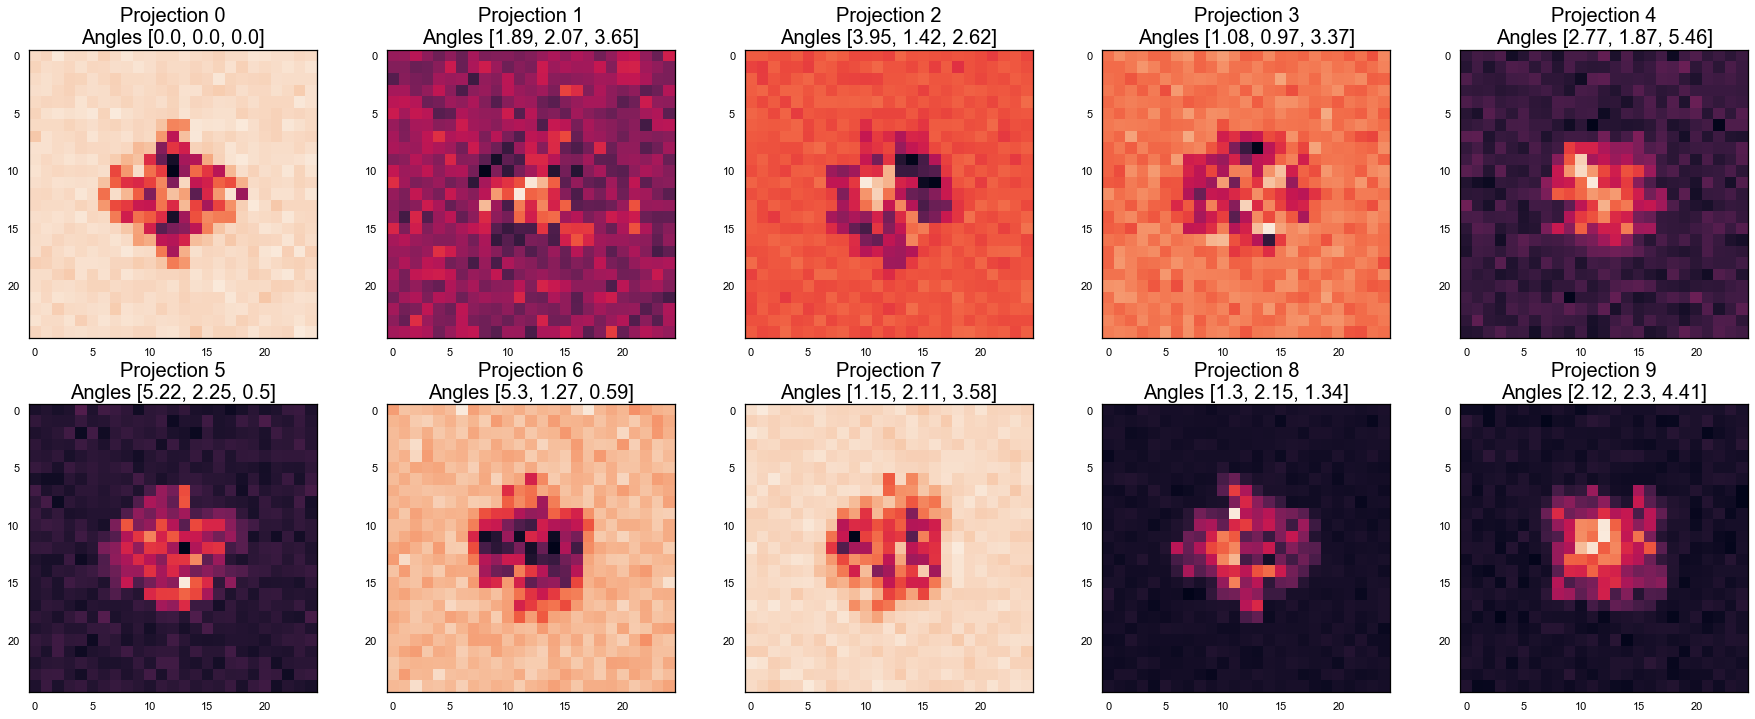

start fitting
The 0-th iteration


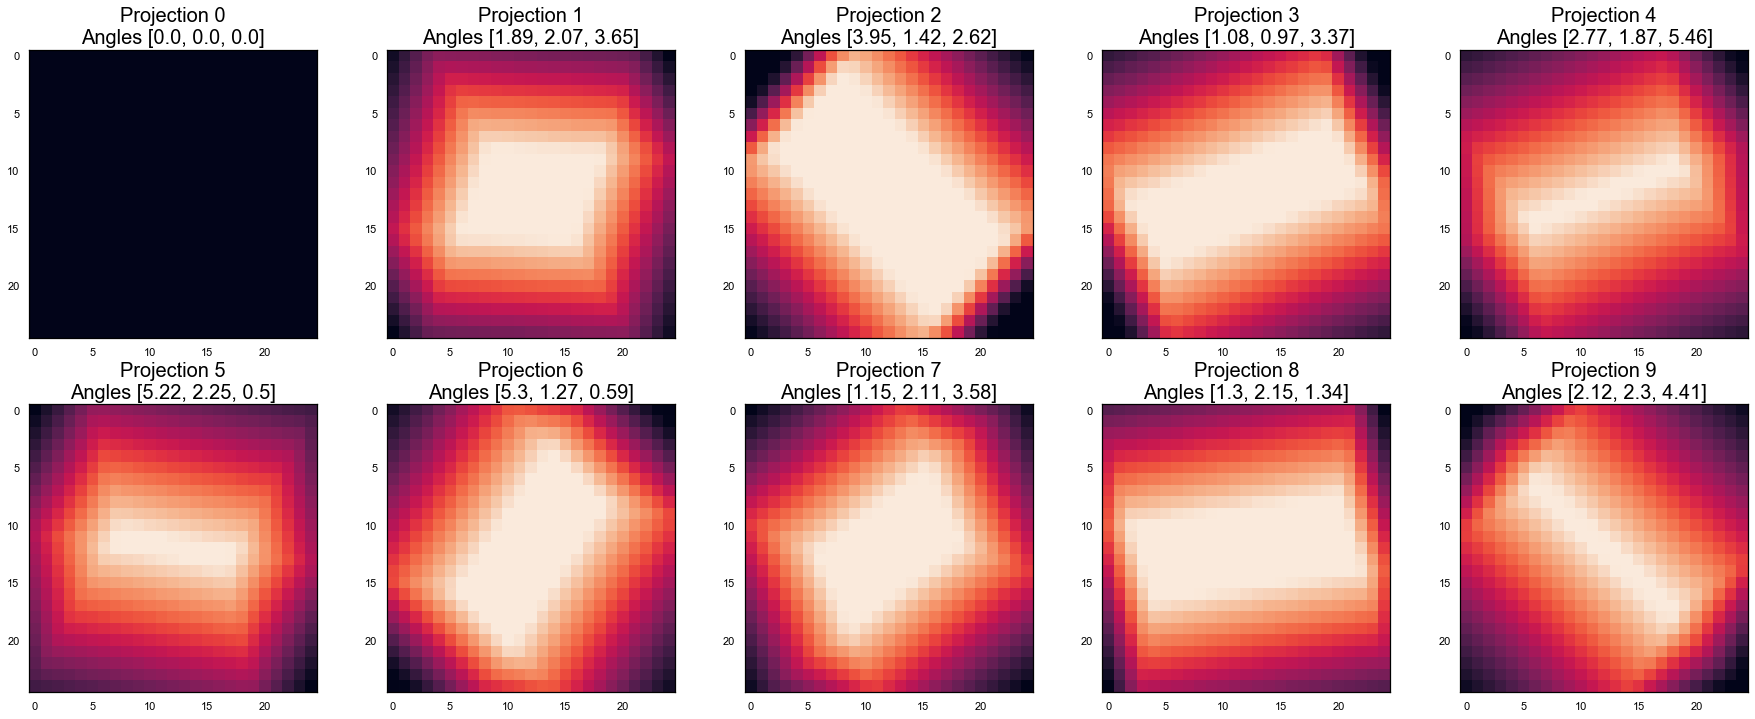

The 1-th iteration


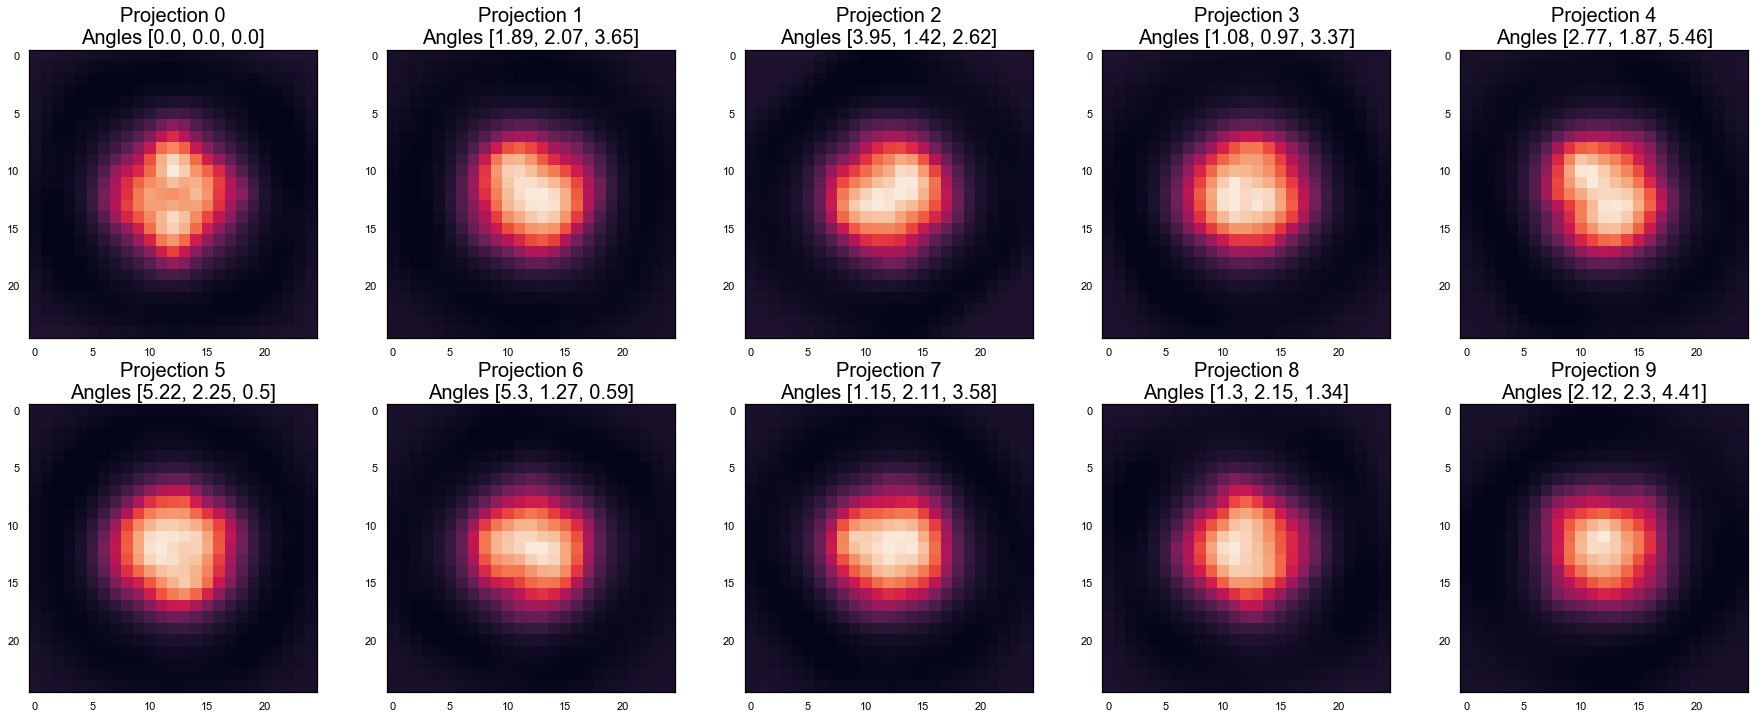

The 11-th iteration


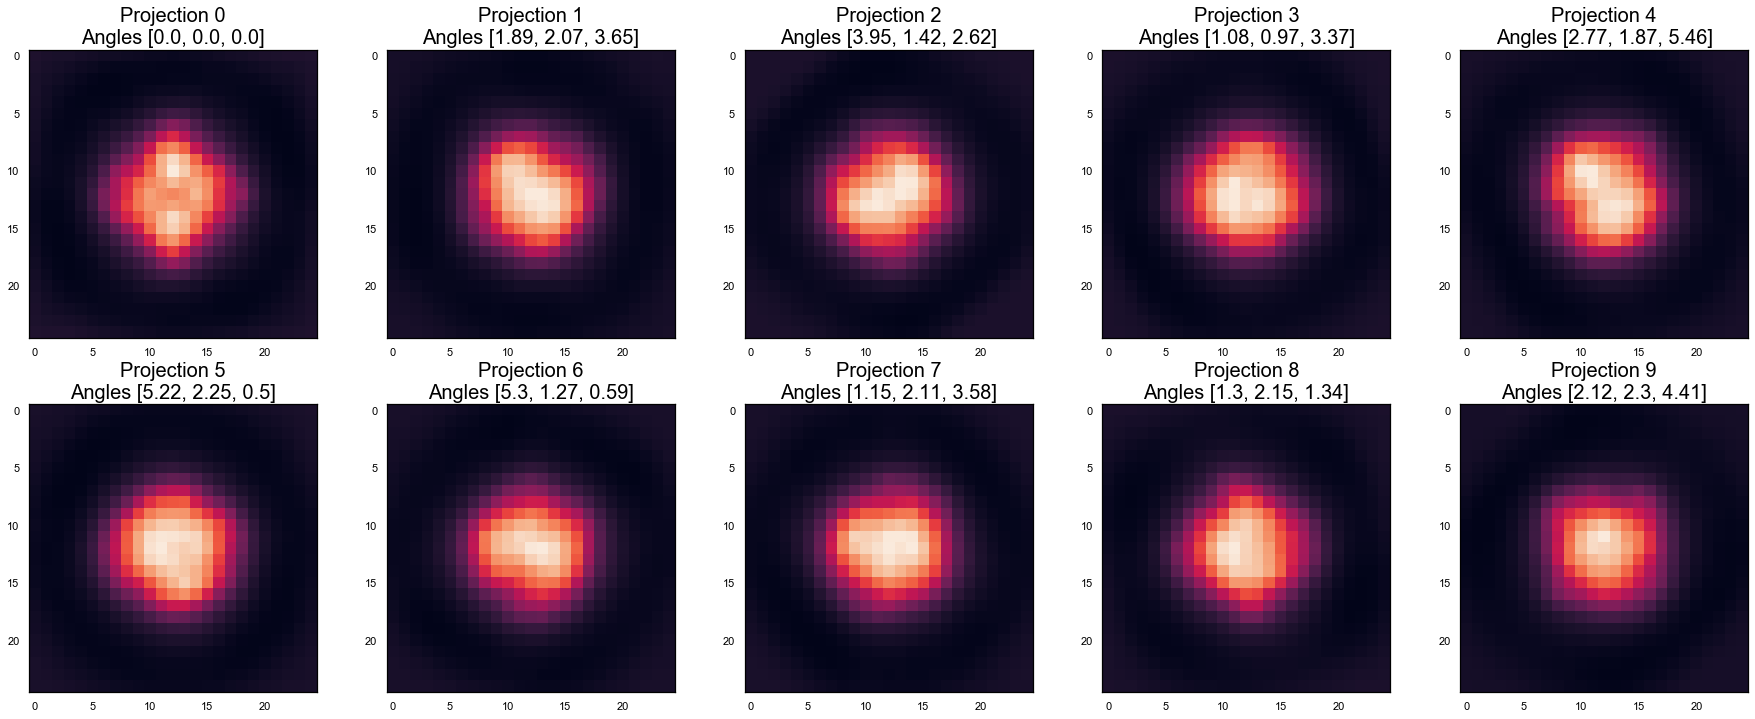

The 21-th iteration


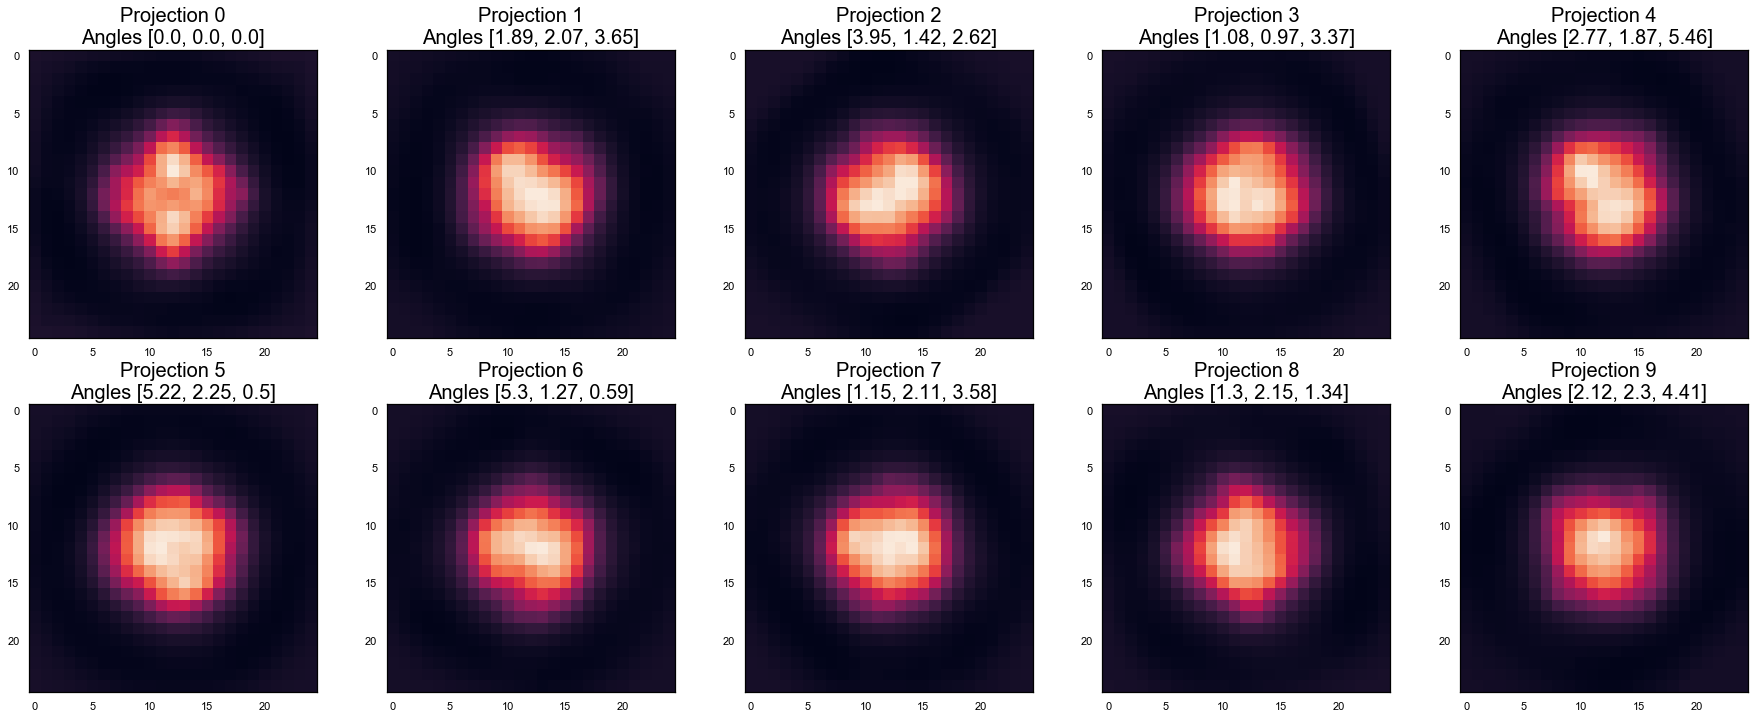

The 31-th iteration


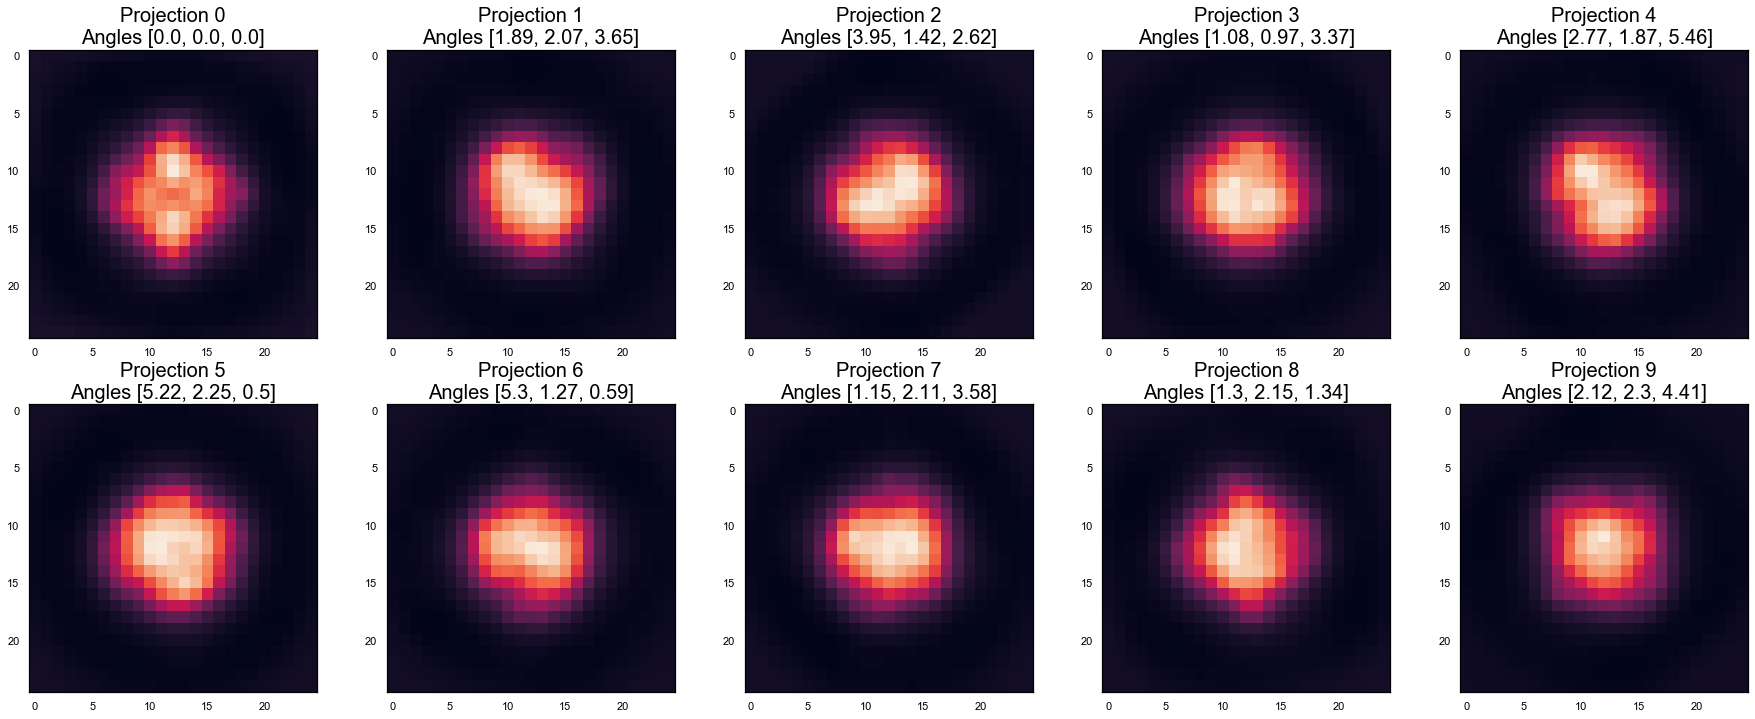

The 41-th iteration


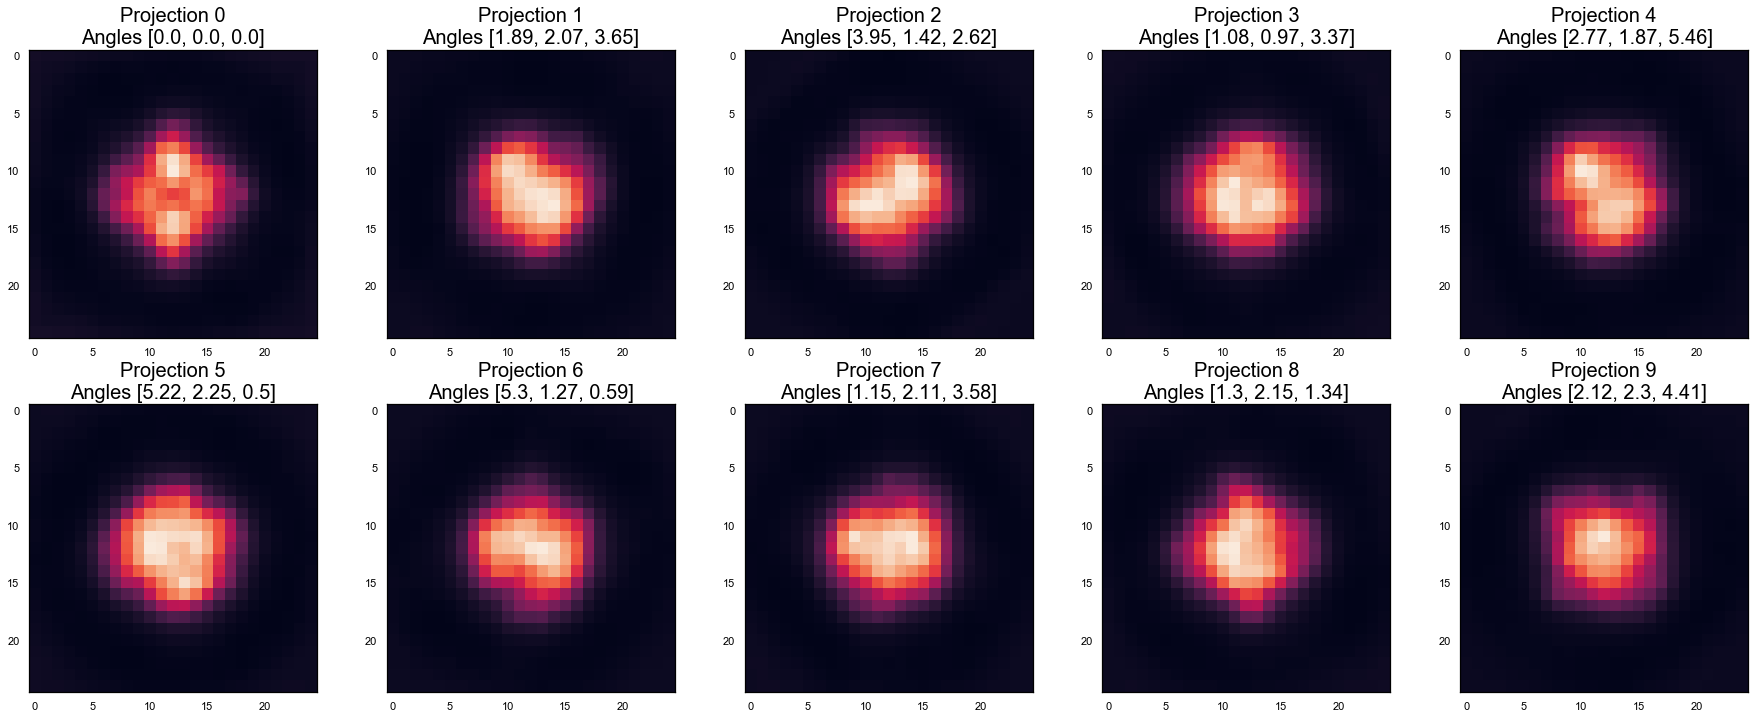

The 51-th iteration


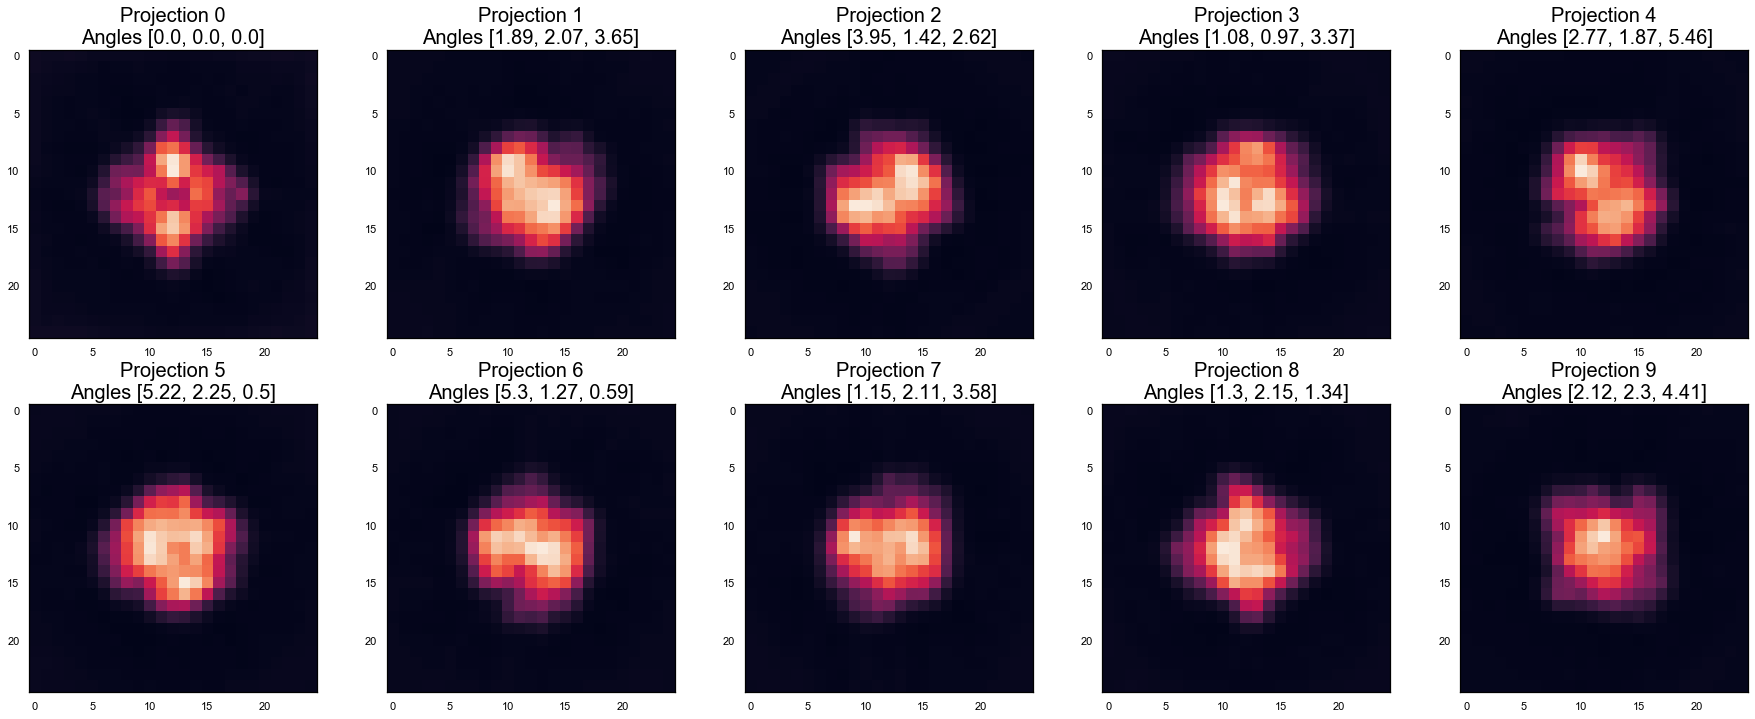

The 61-th iteration


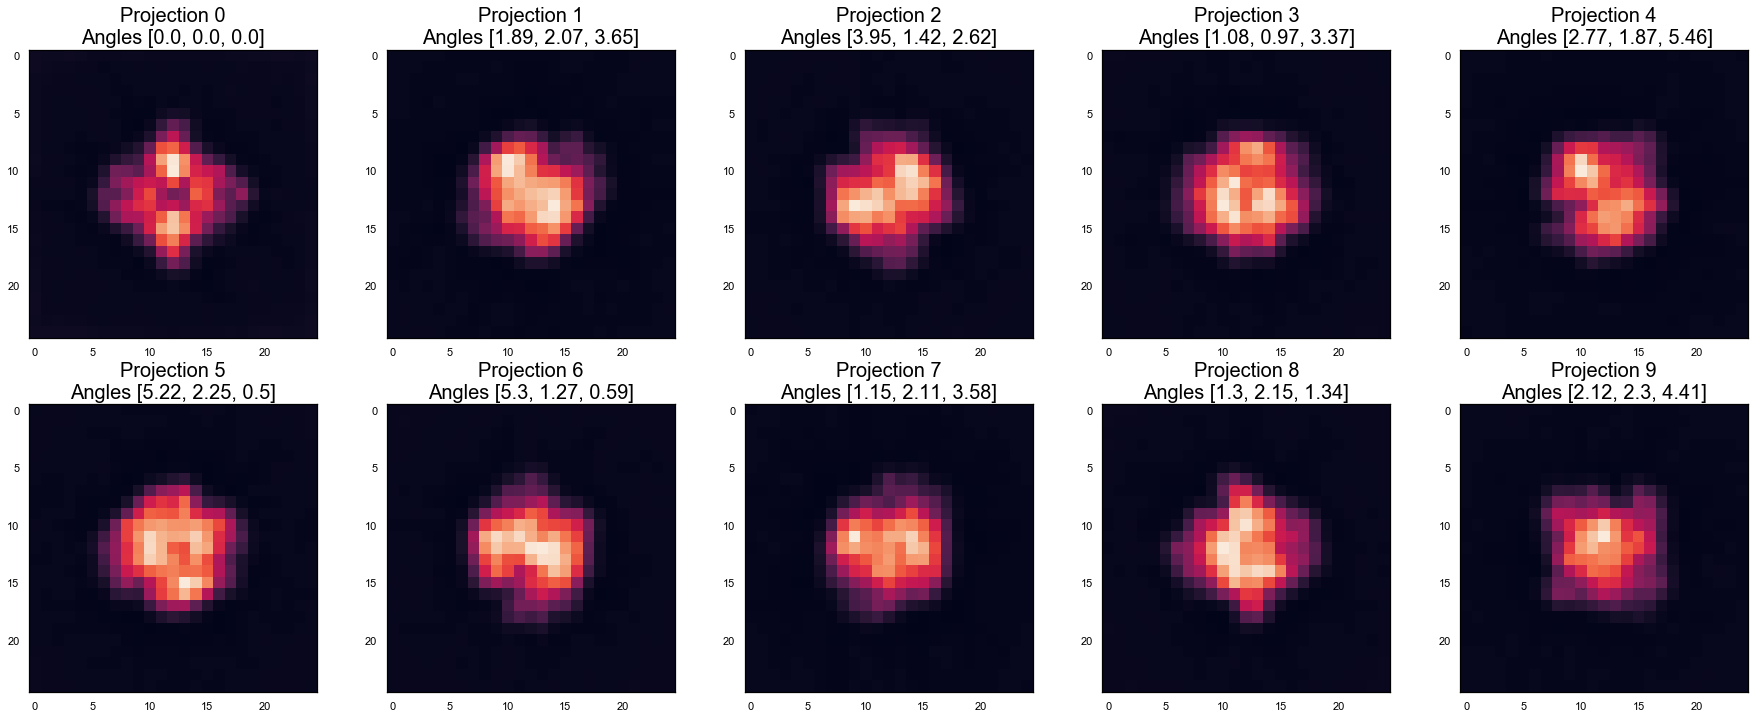

The 71-th iteration


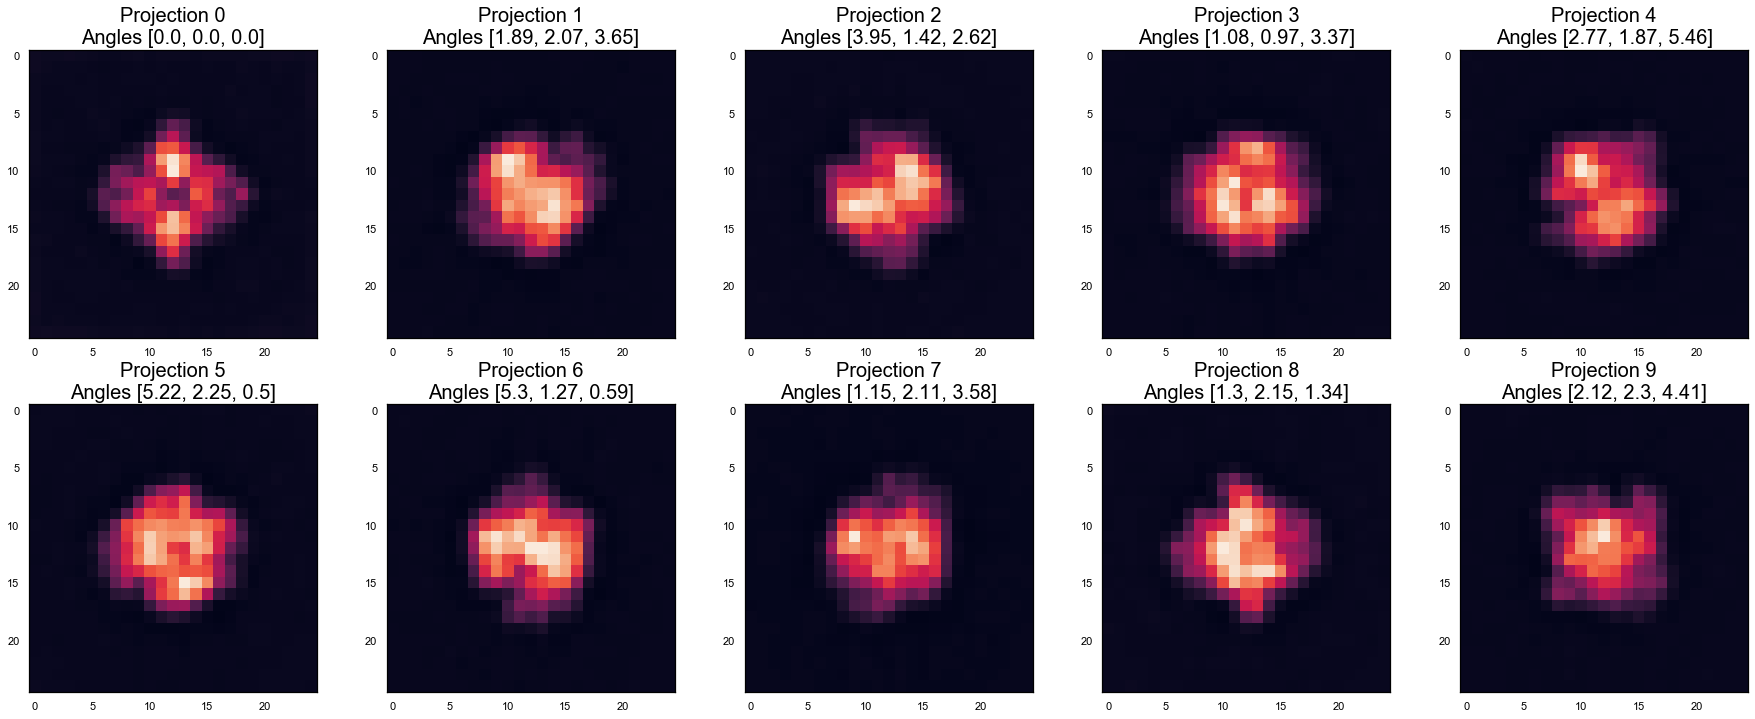

The 81-th iteration


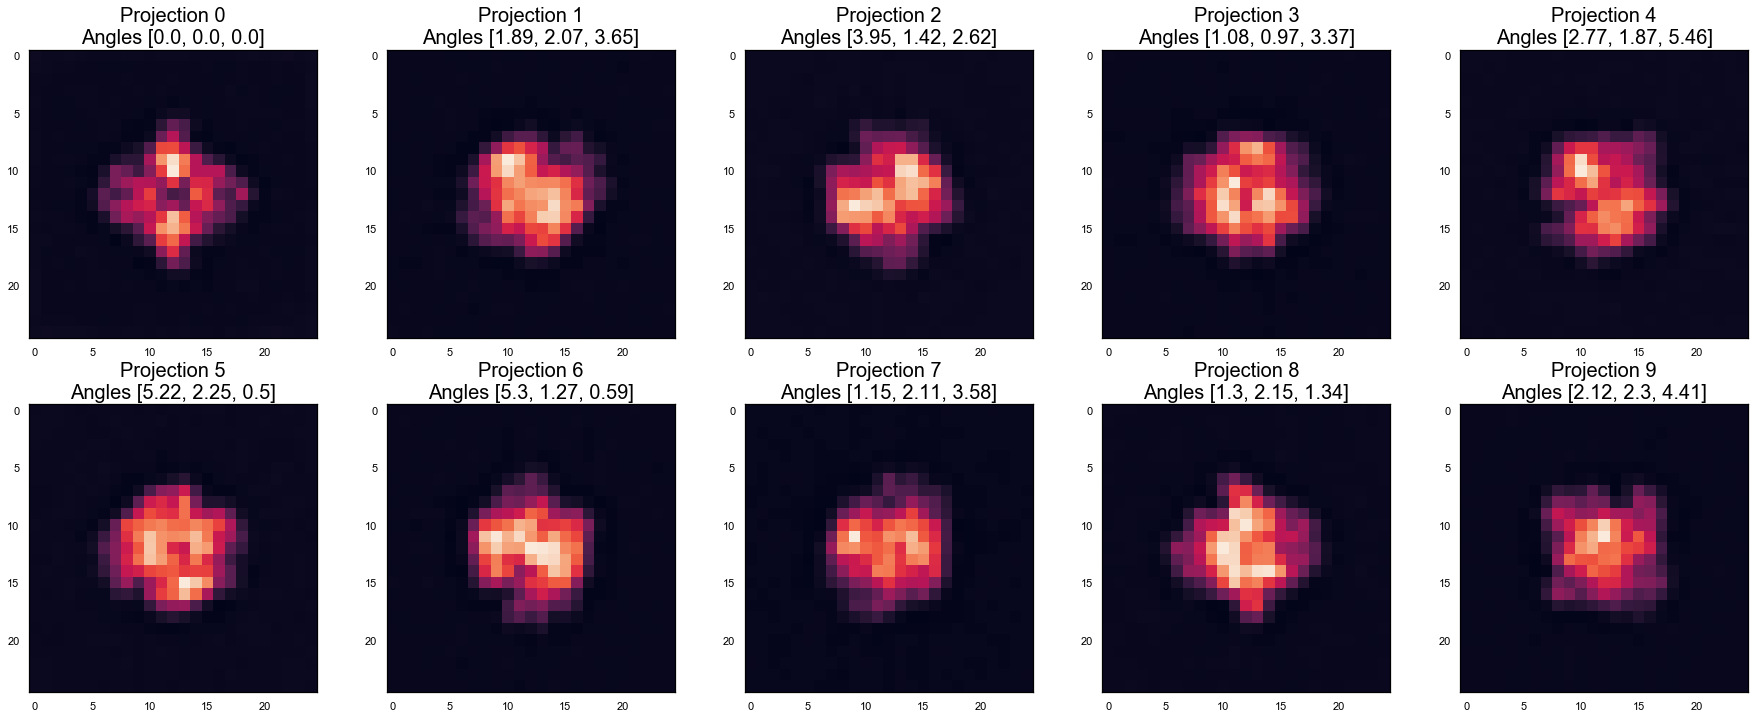

The 91-th iteration


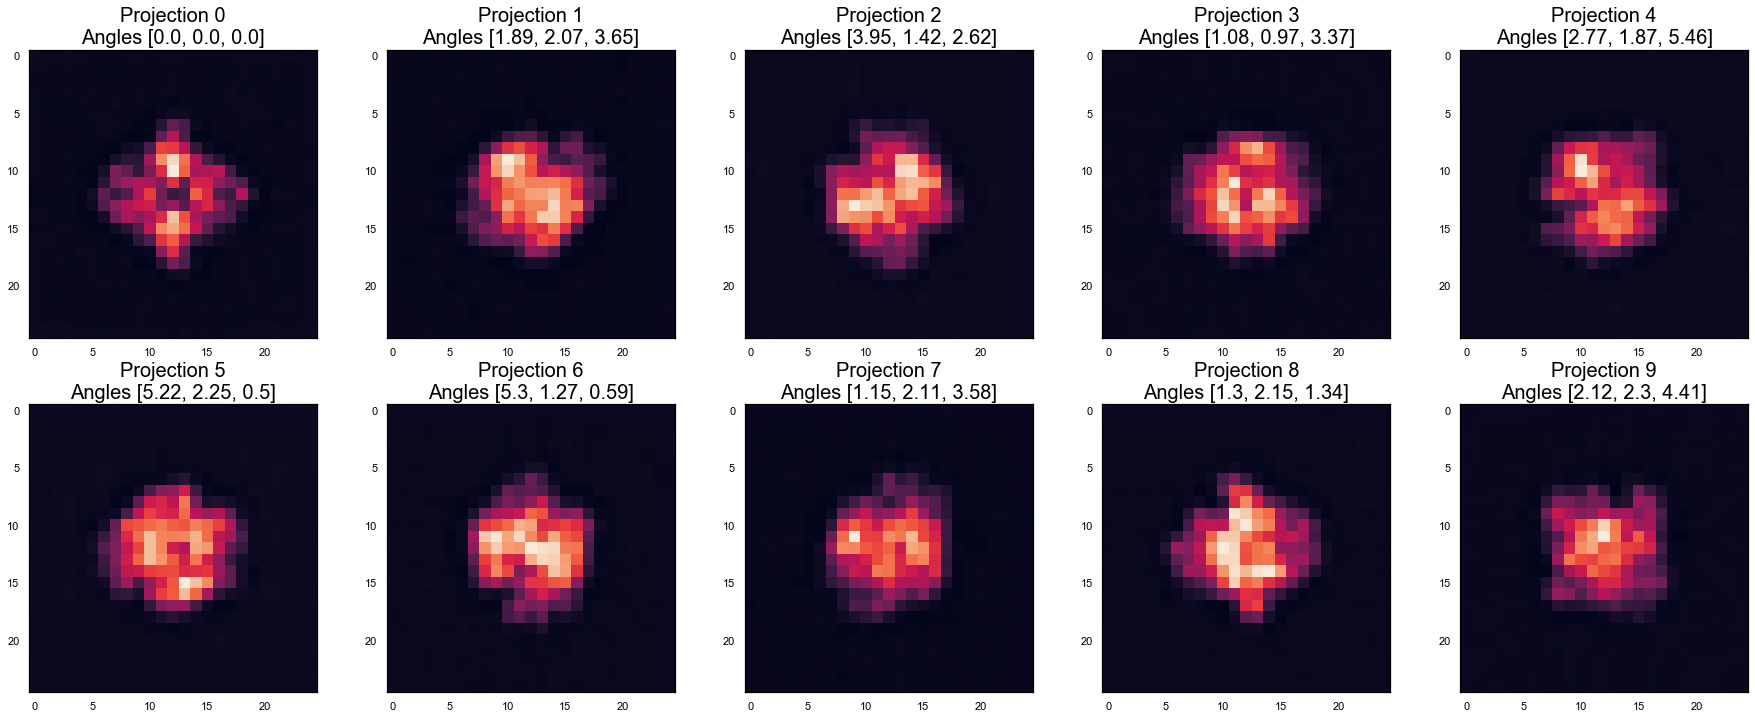

The 101-th iteration


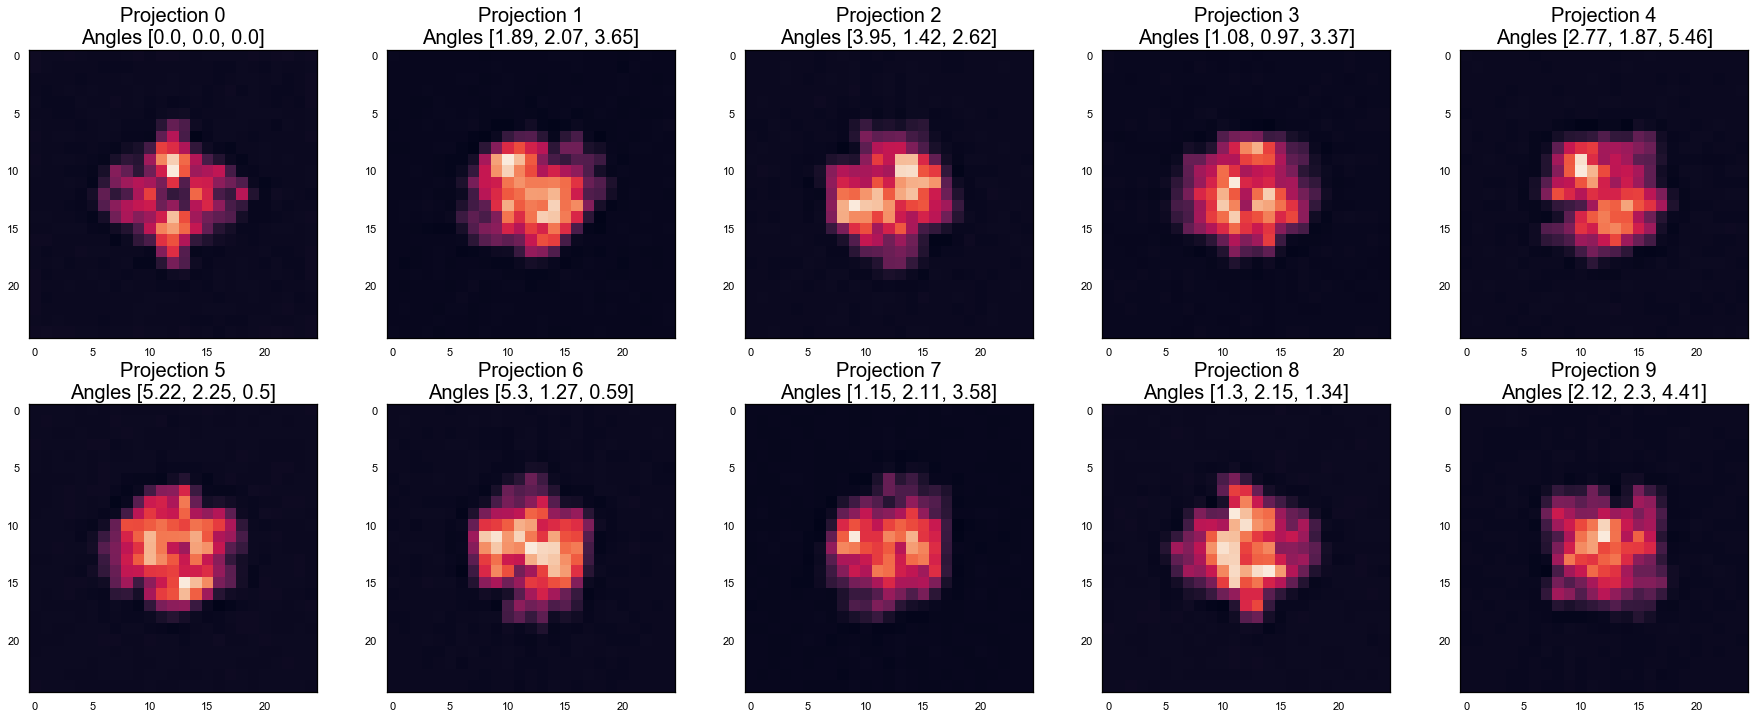

The 111-th iteration


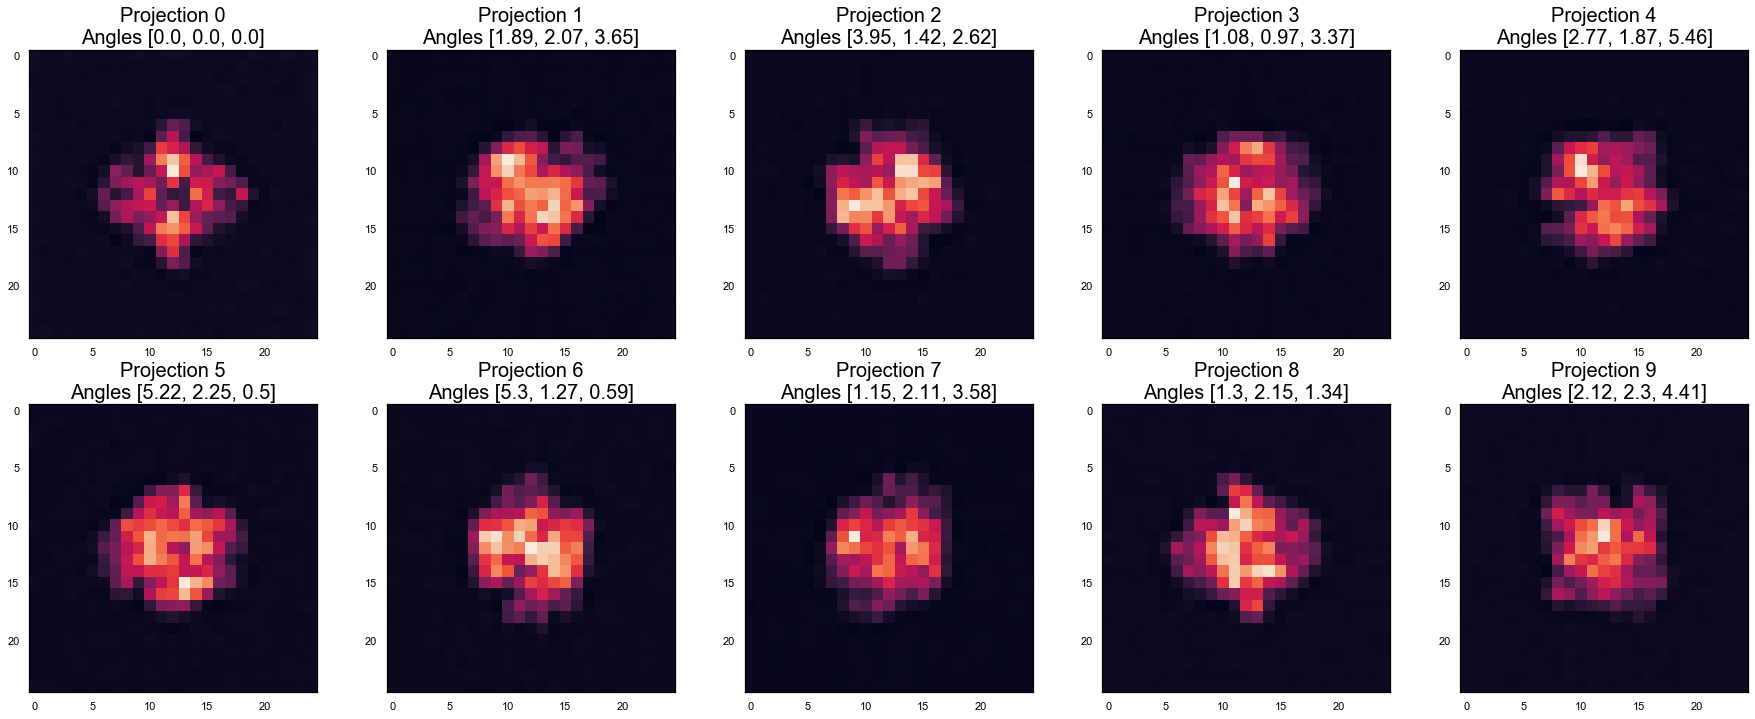

The 121-th iteration


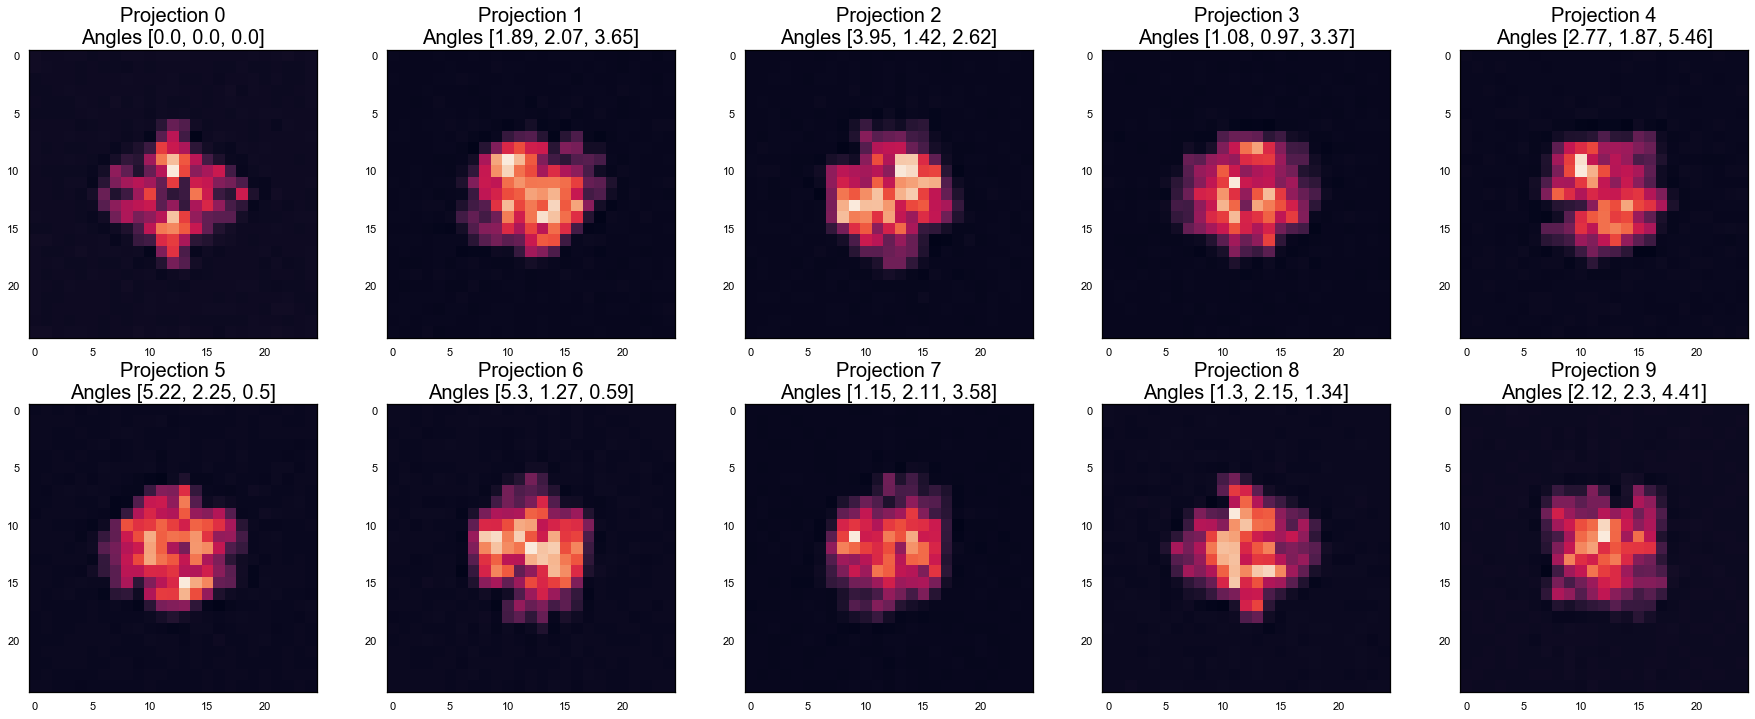

The 131-th iteration


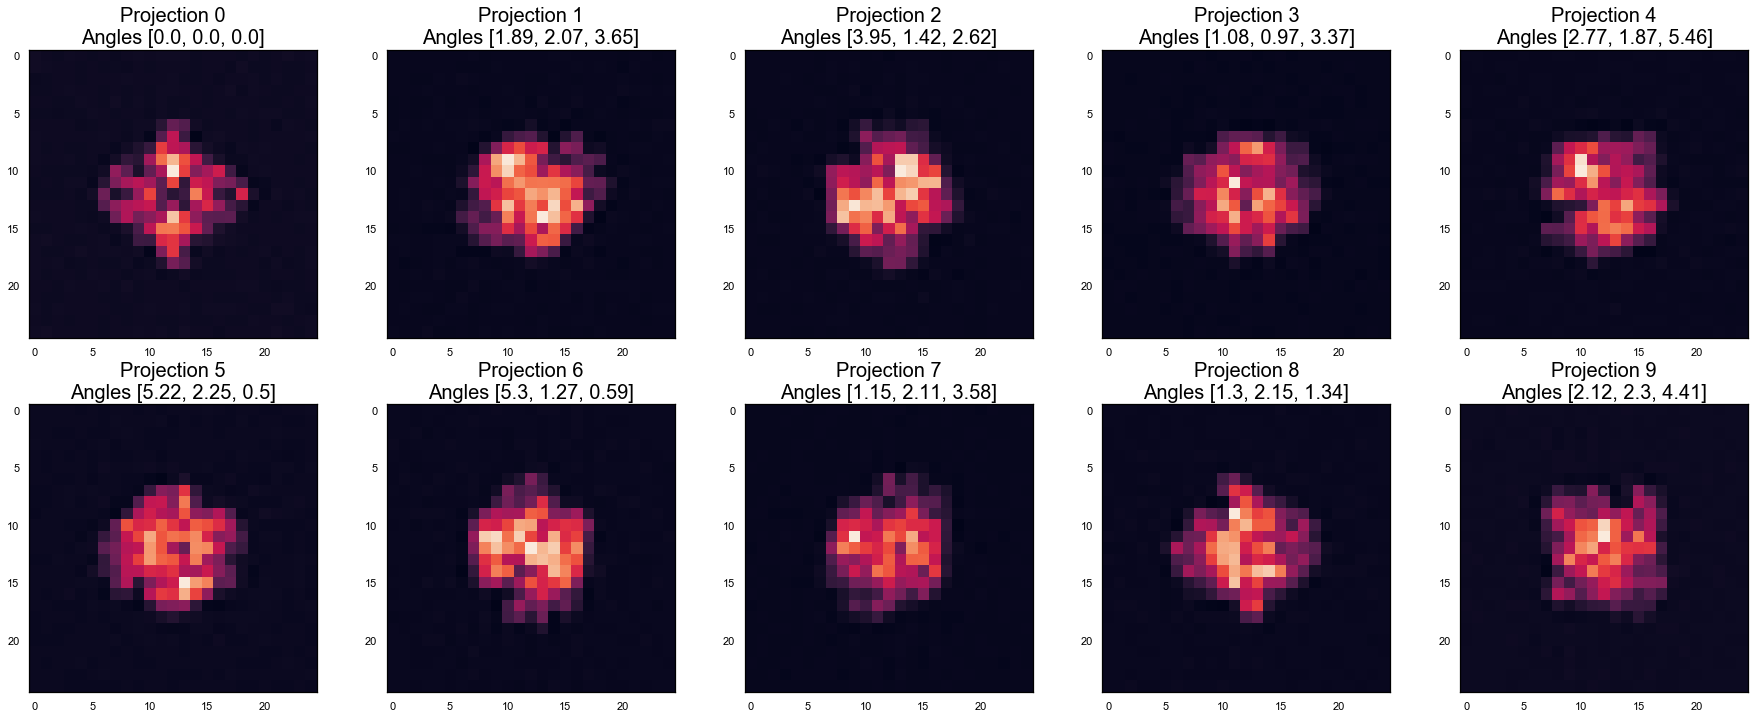

The 141-th iteration


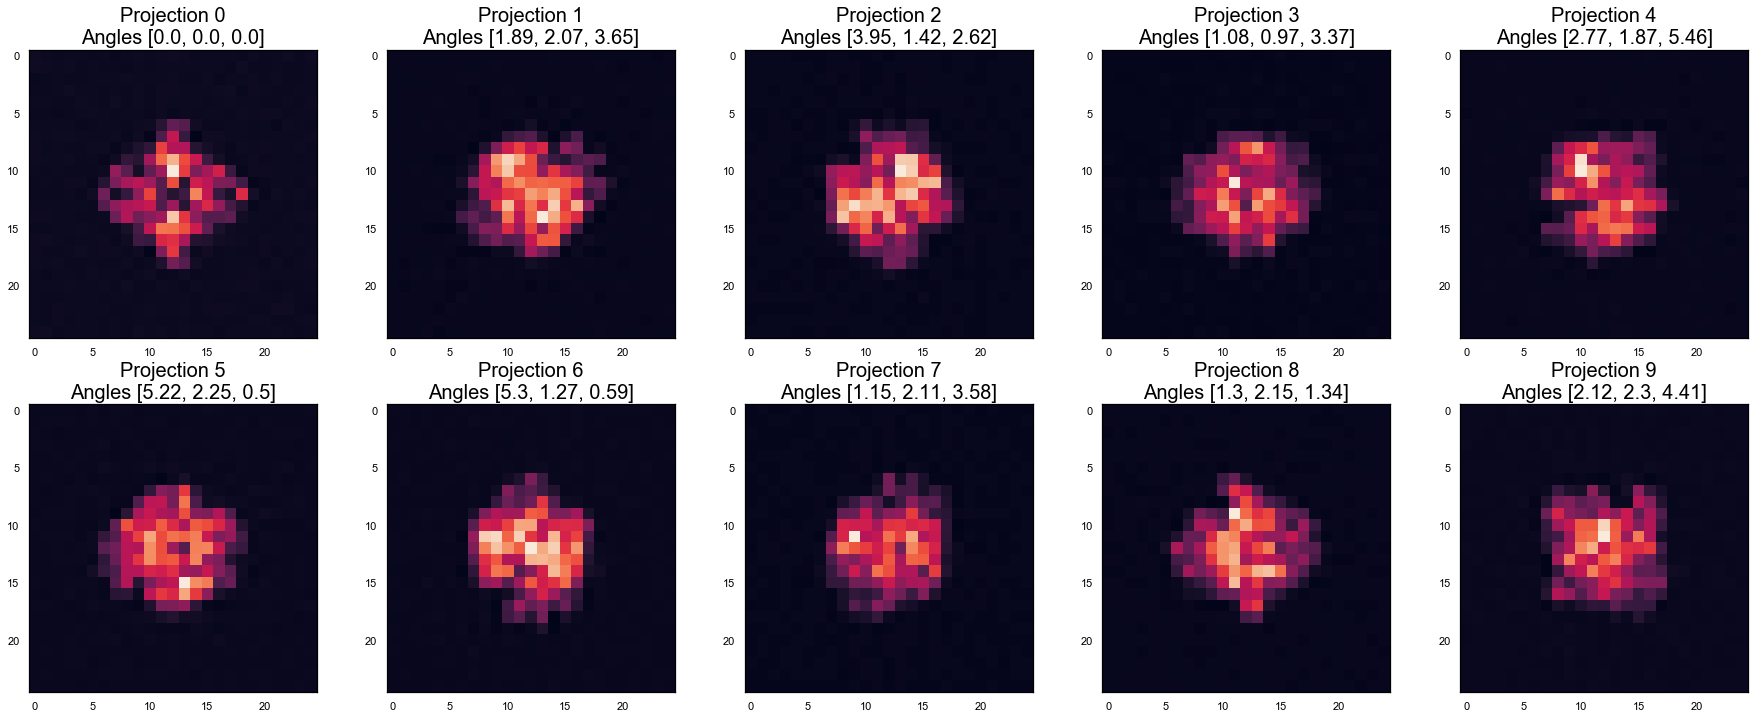

The 151-th iteration


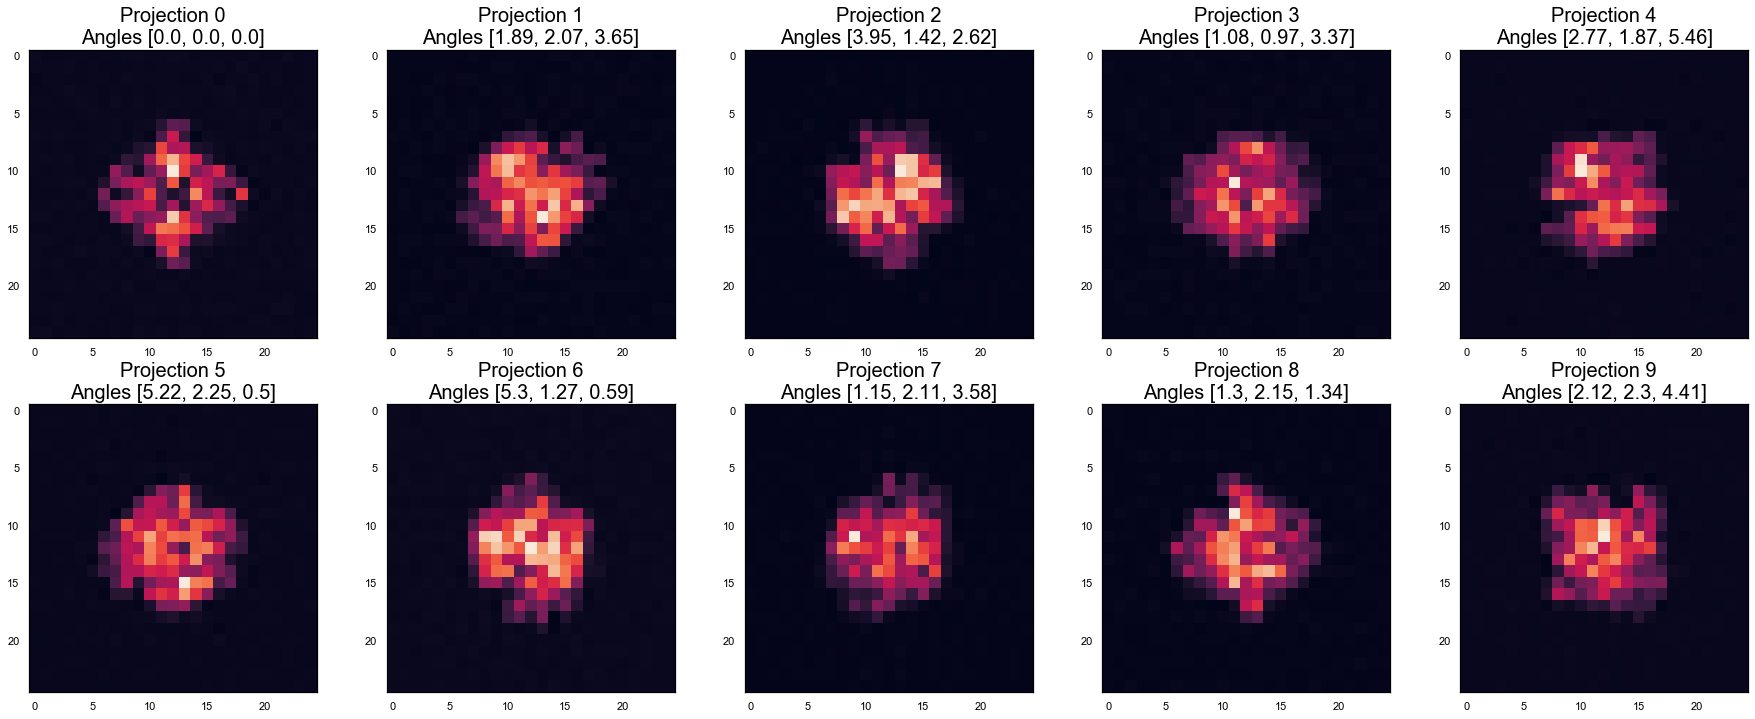

The 161-th iteration


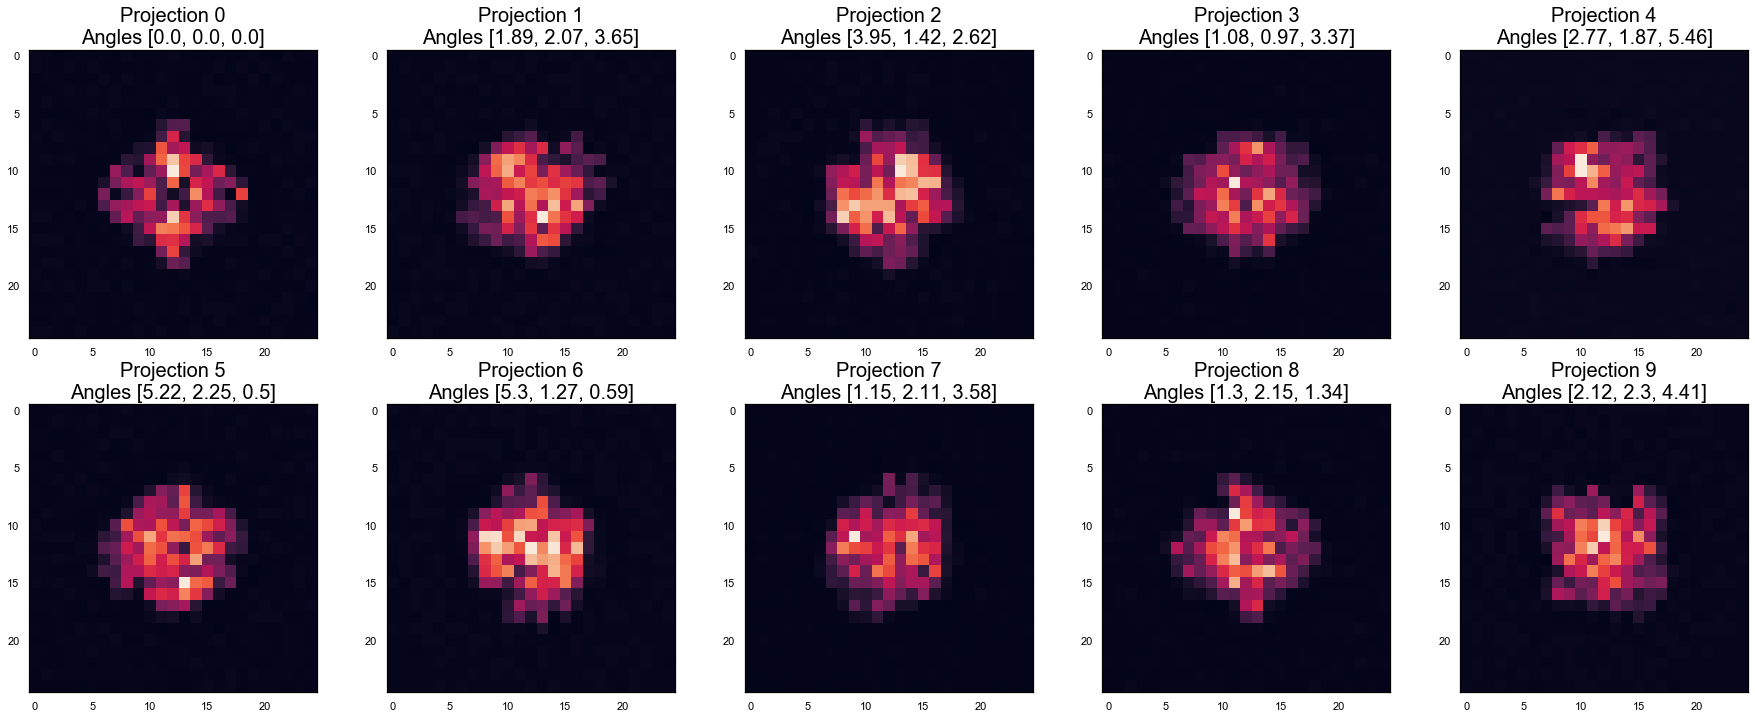

The 171-th iteration


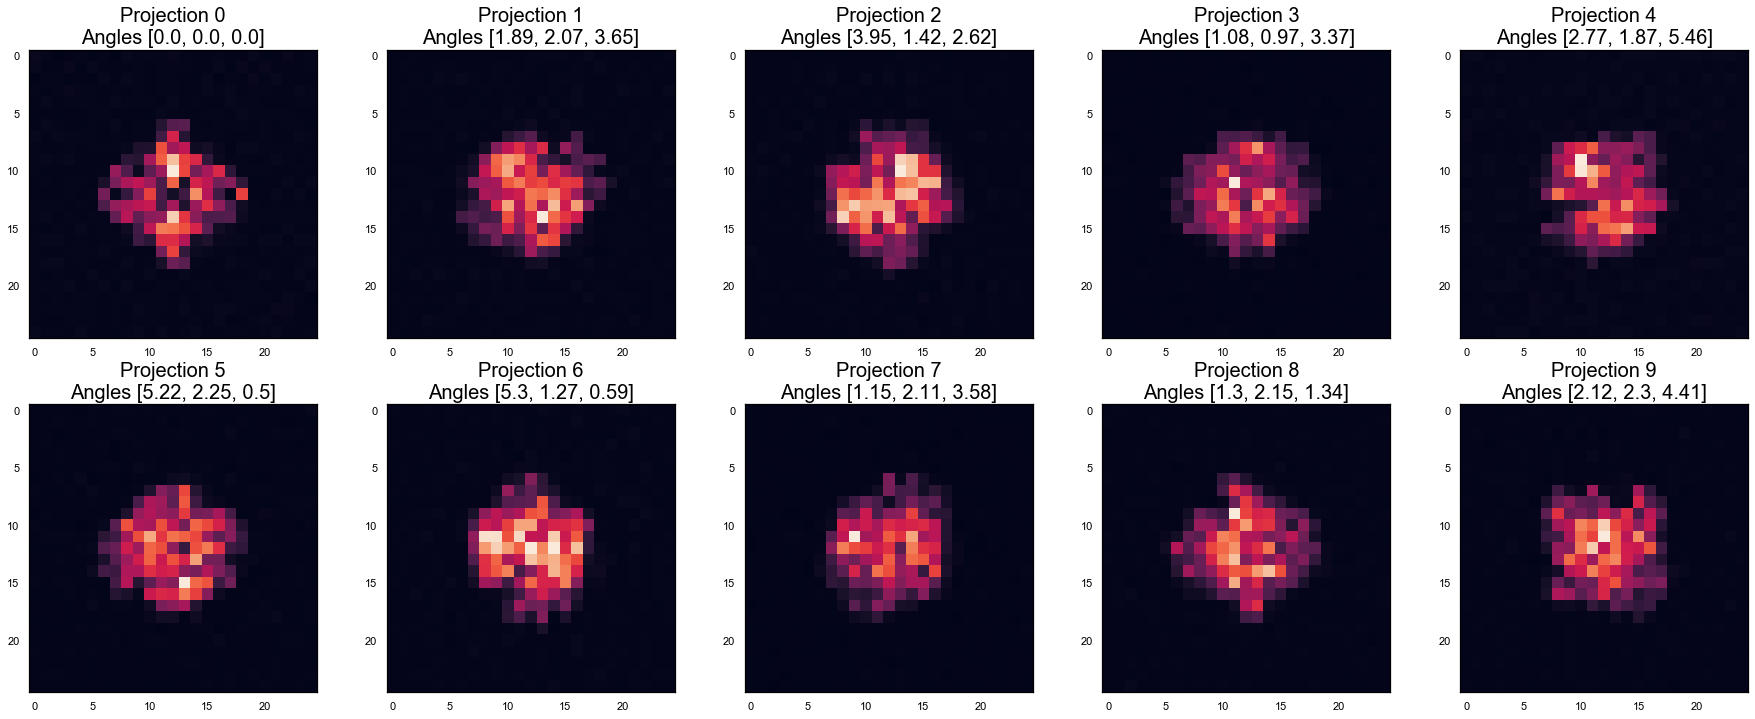

The 181-th iteration


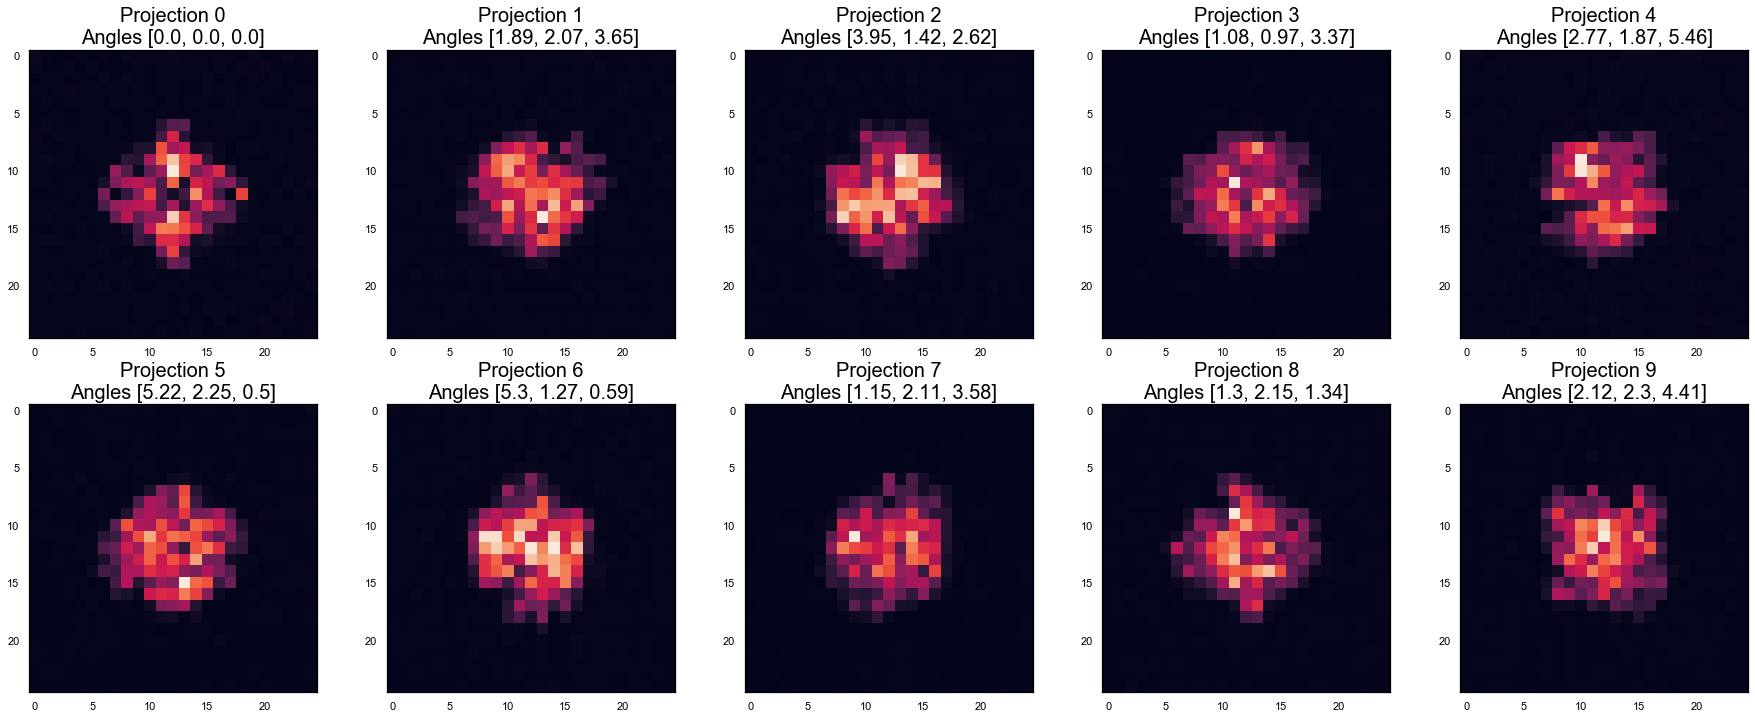

The 191-th iteration


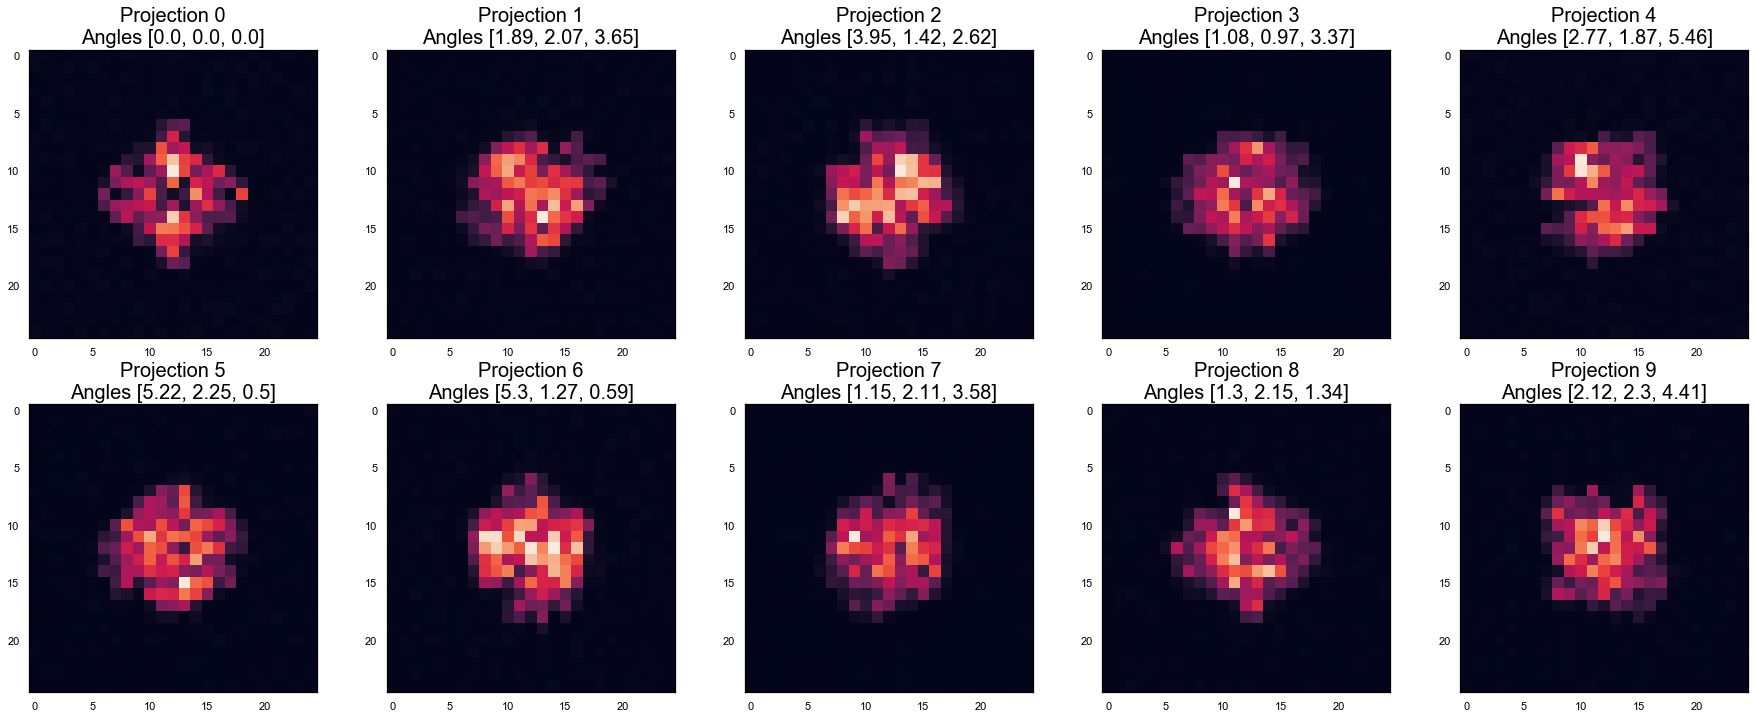

The 201-th iteration


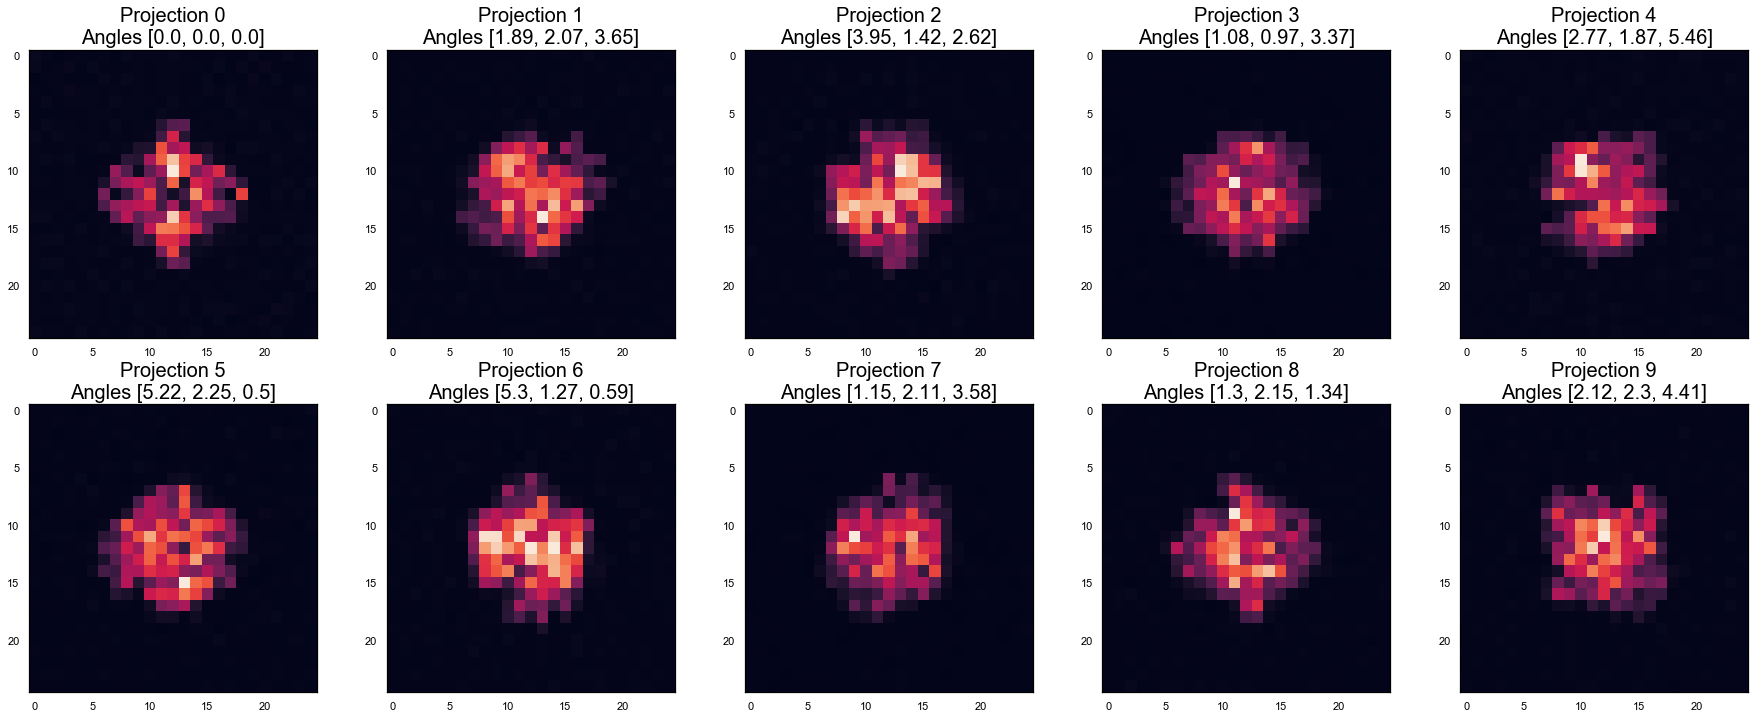

The 211-th iteration


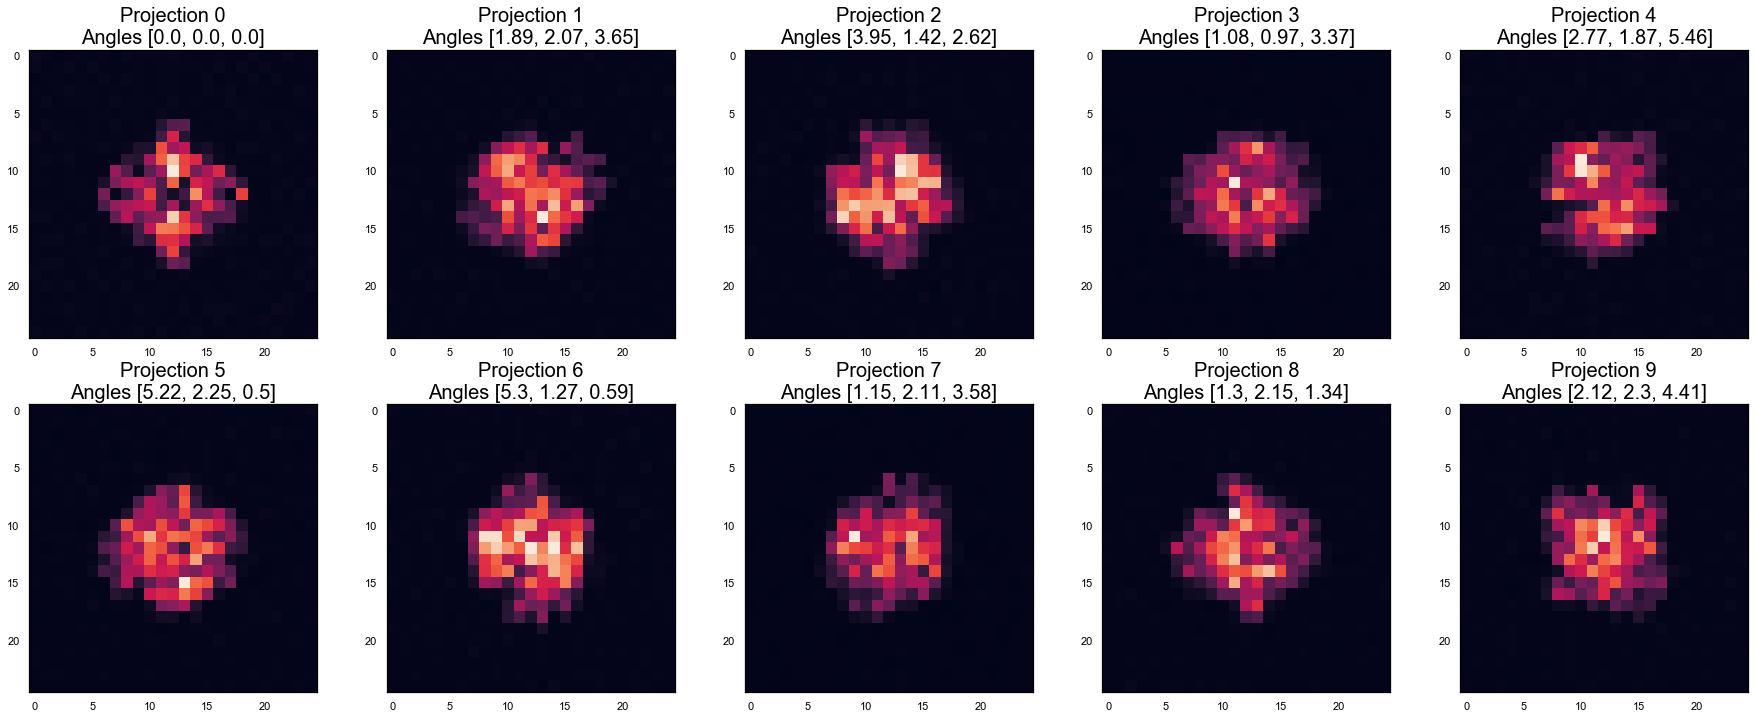

The 221-th iteration


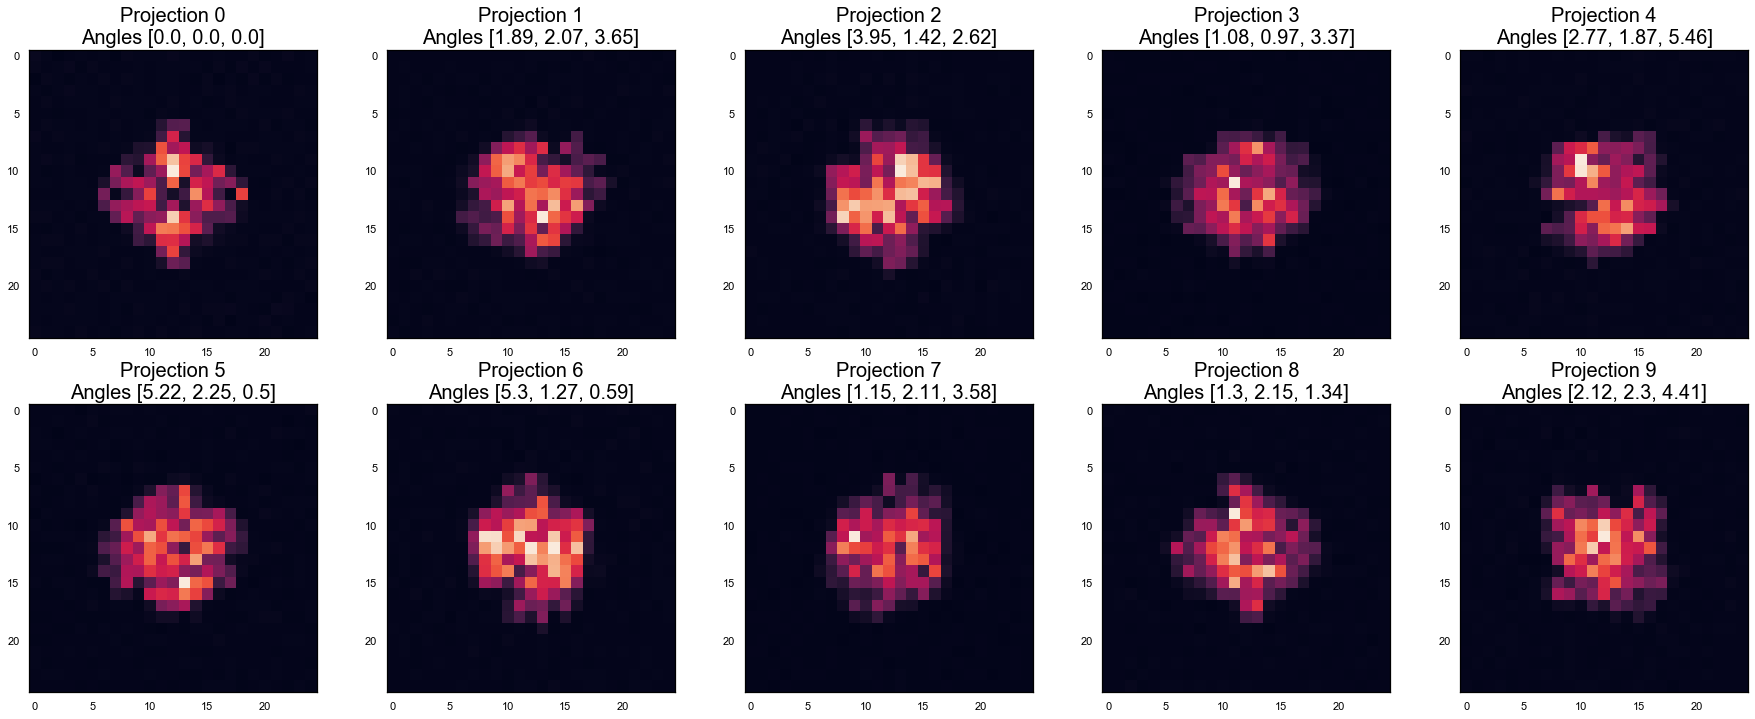

The 231-th iteration


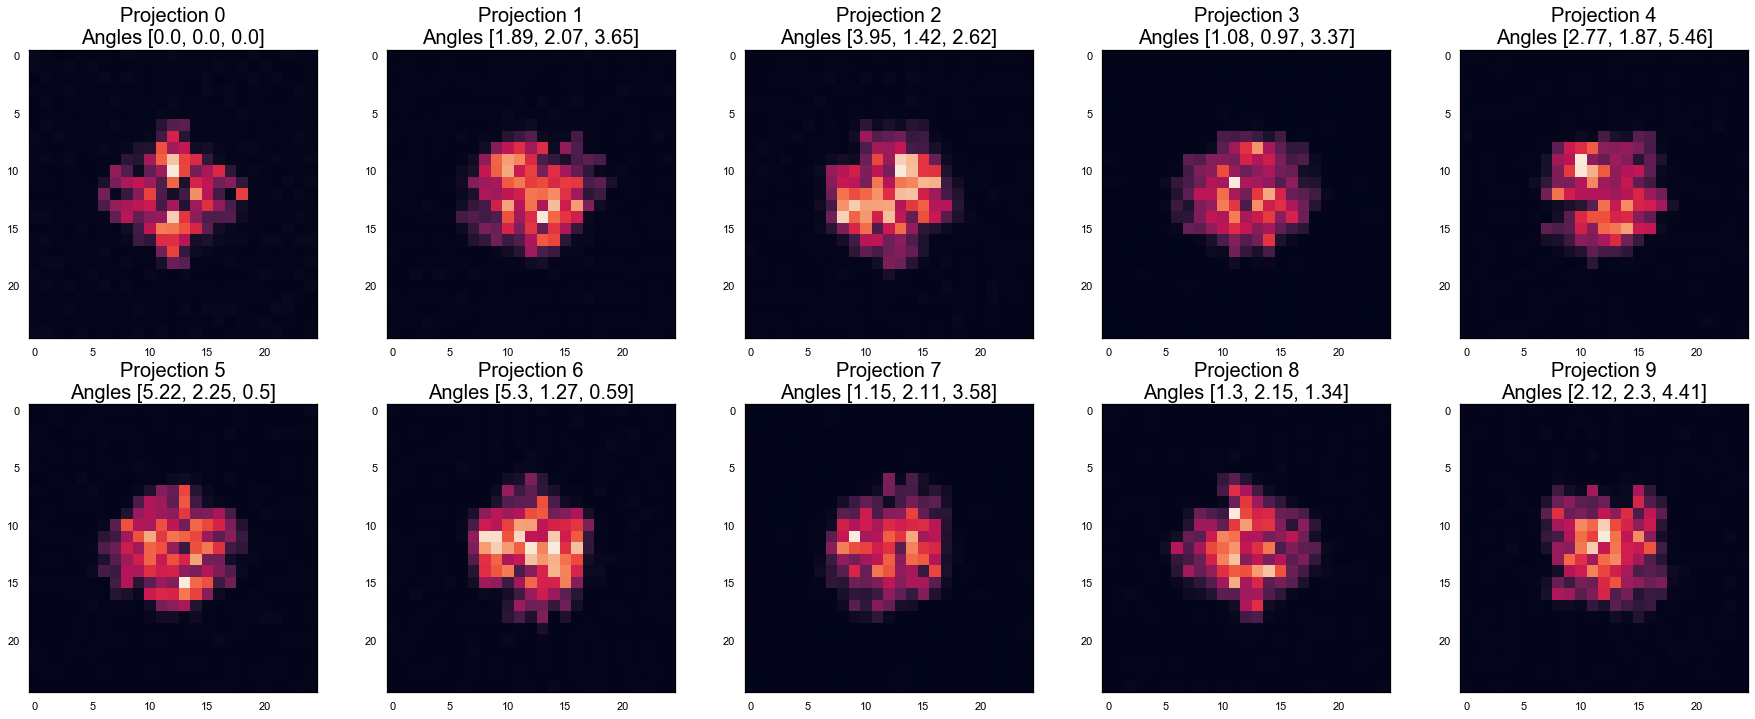

The 241-th iteration


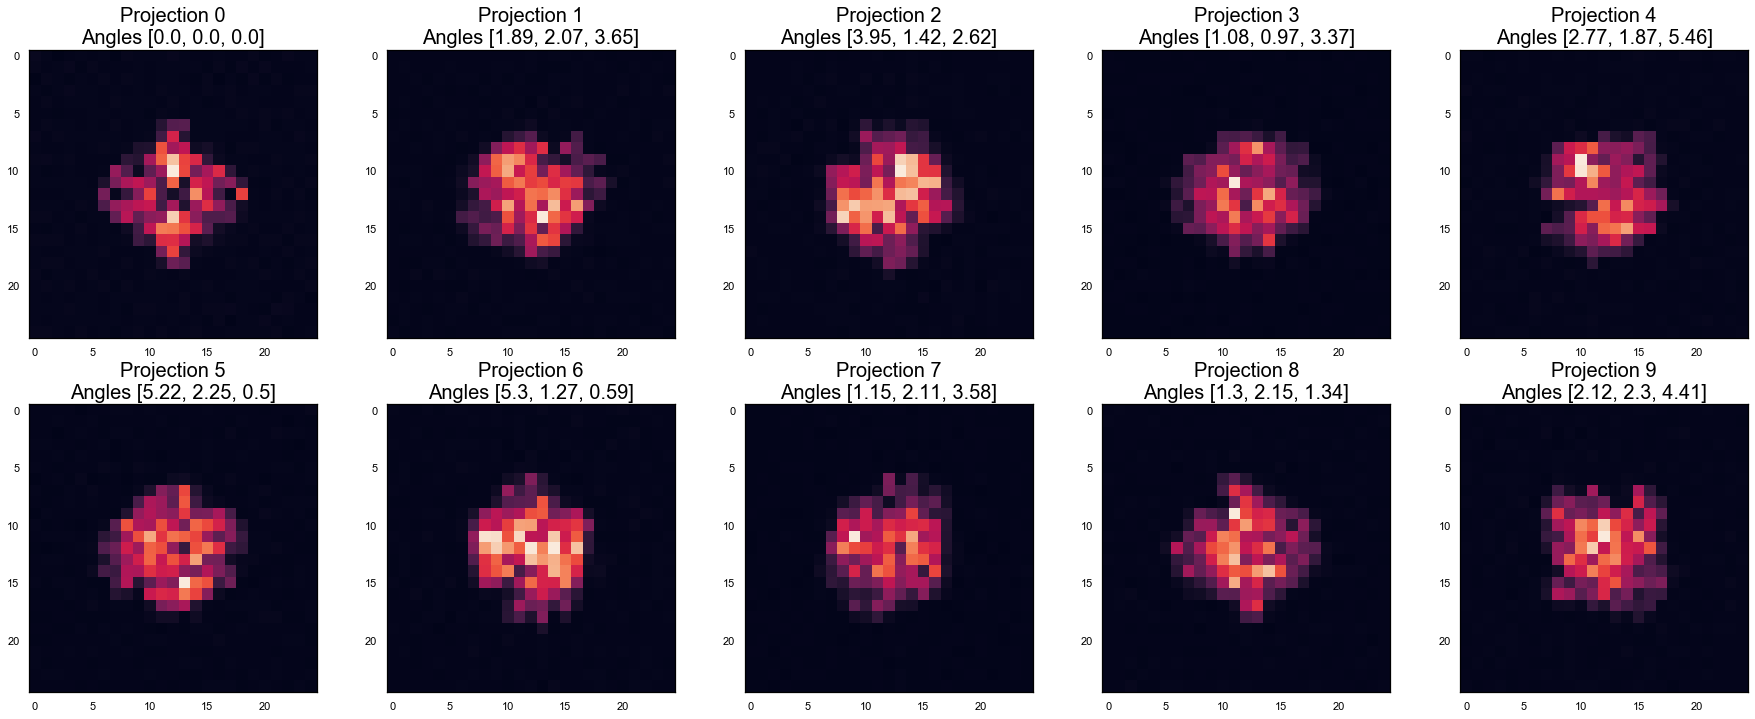

The 251-th iteration


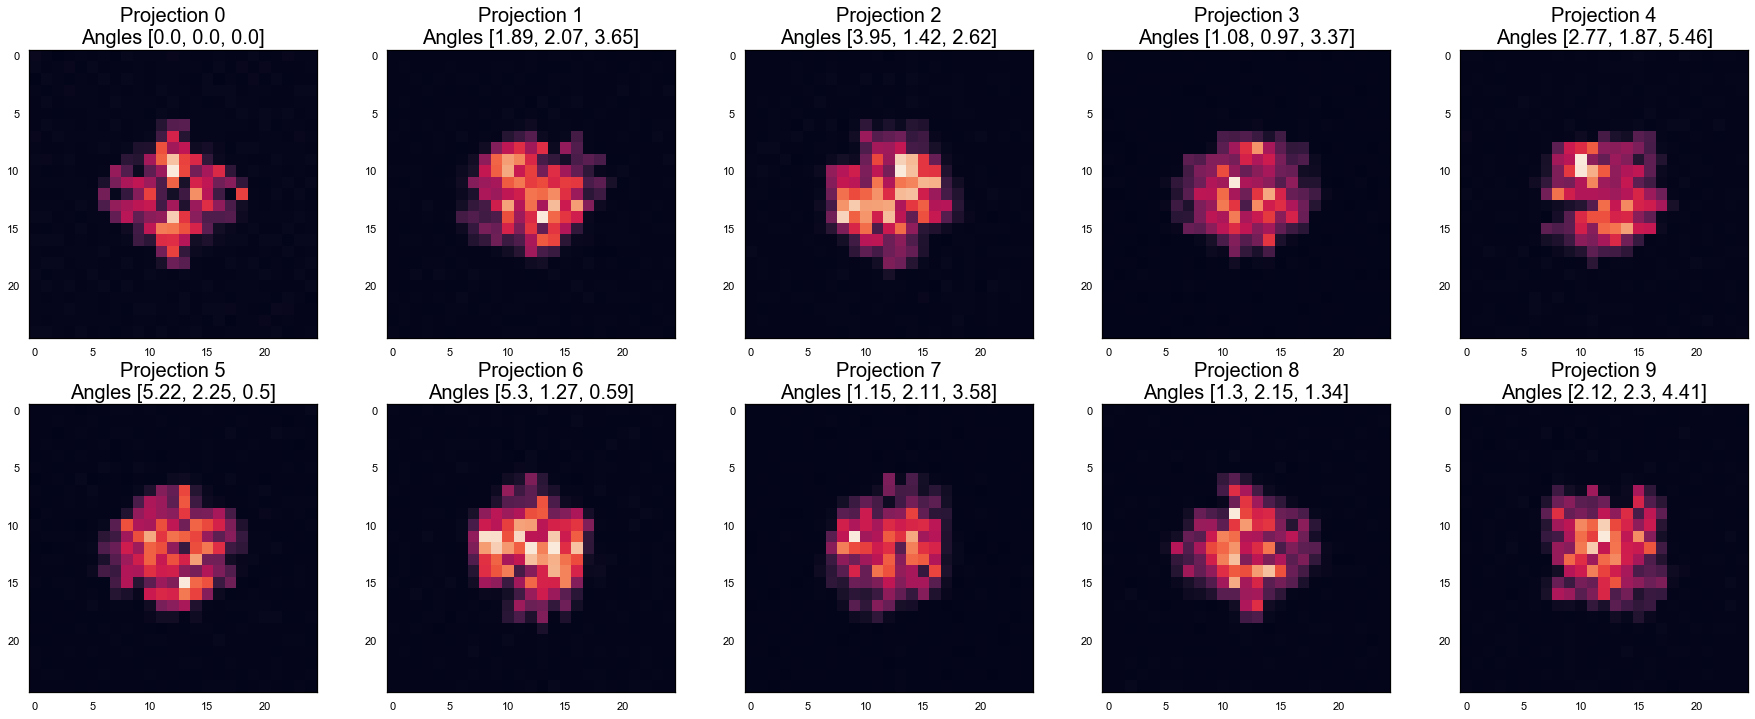

The 261-th iteration


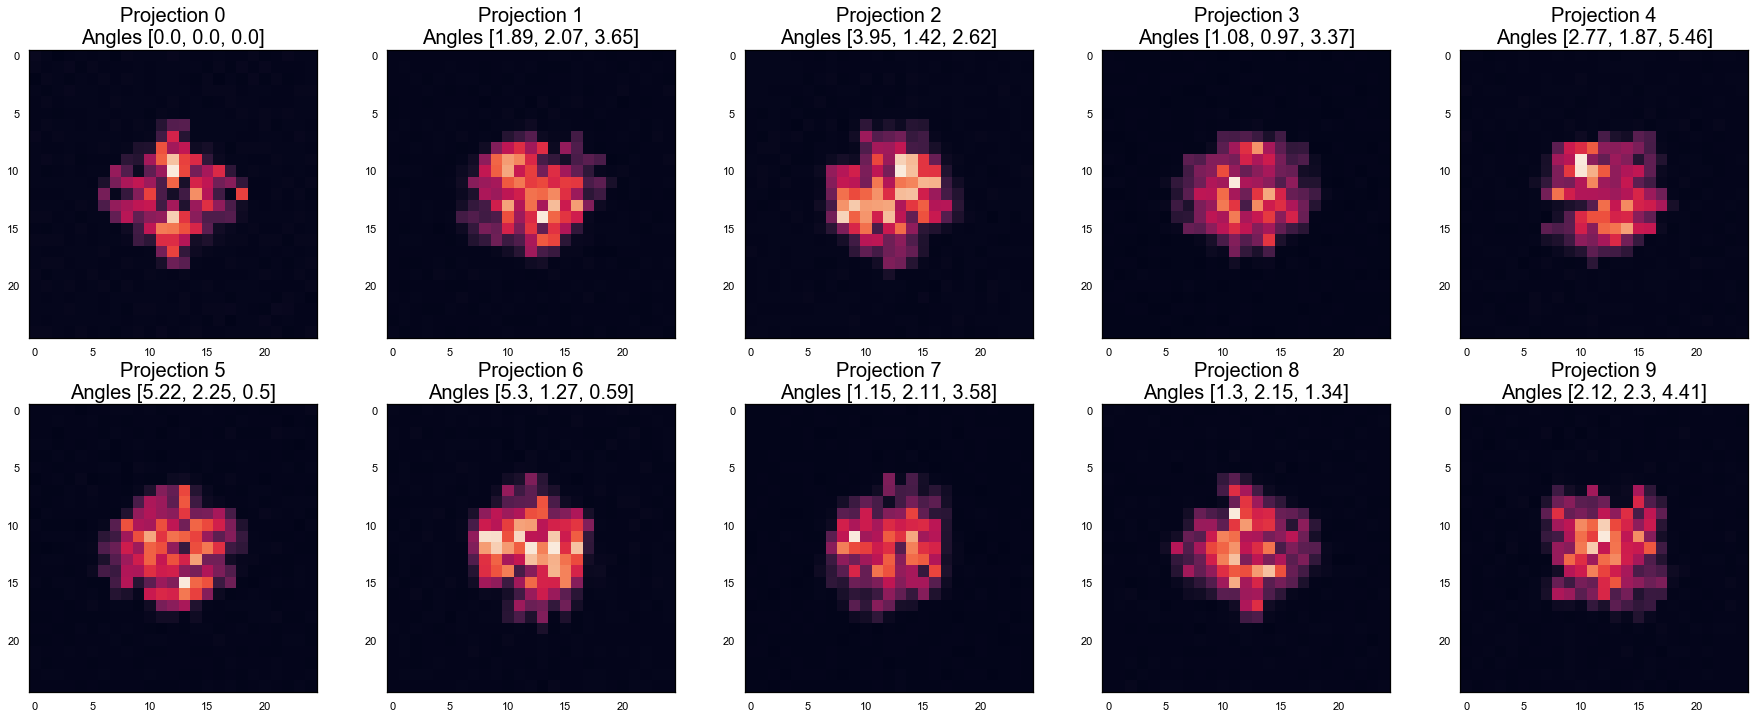

The 271-th iteration


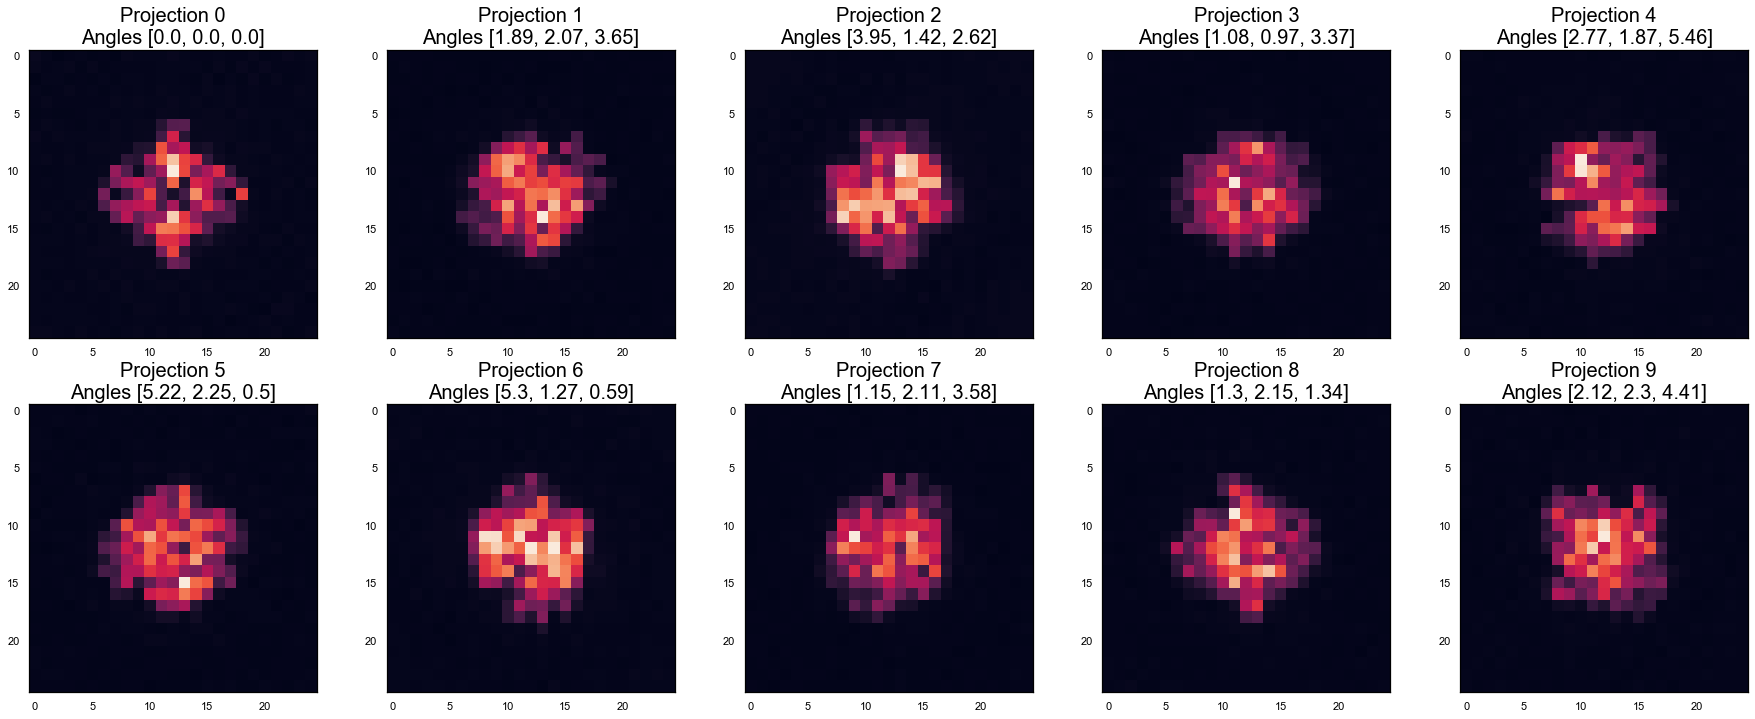

The 281-th iteration


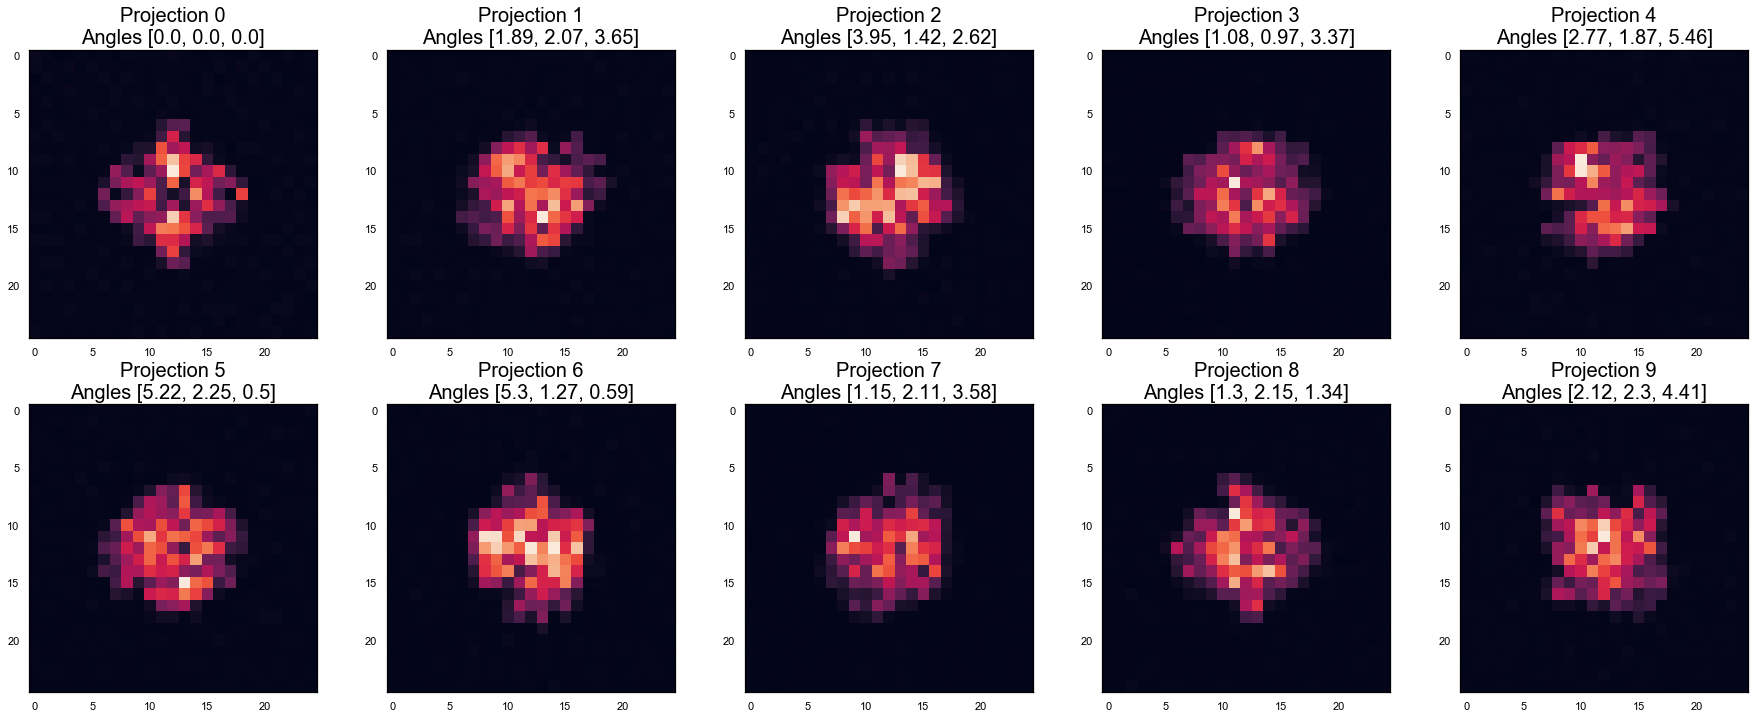

The 291-th iteration


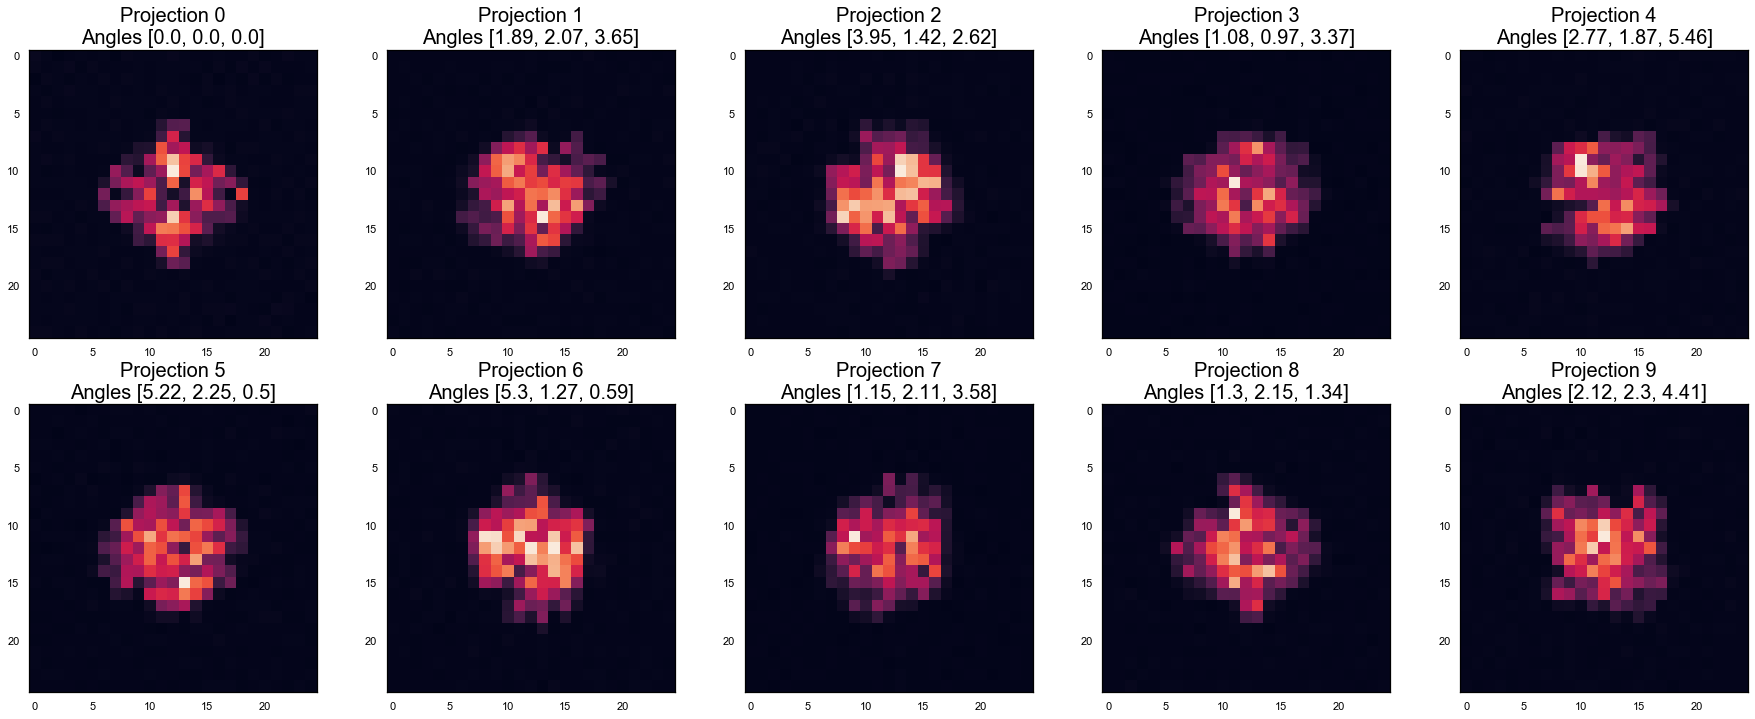

The 301-th iteration


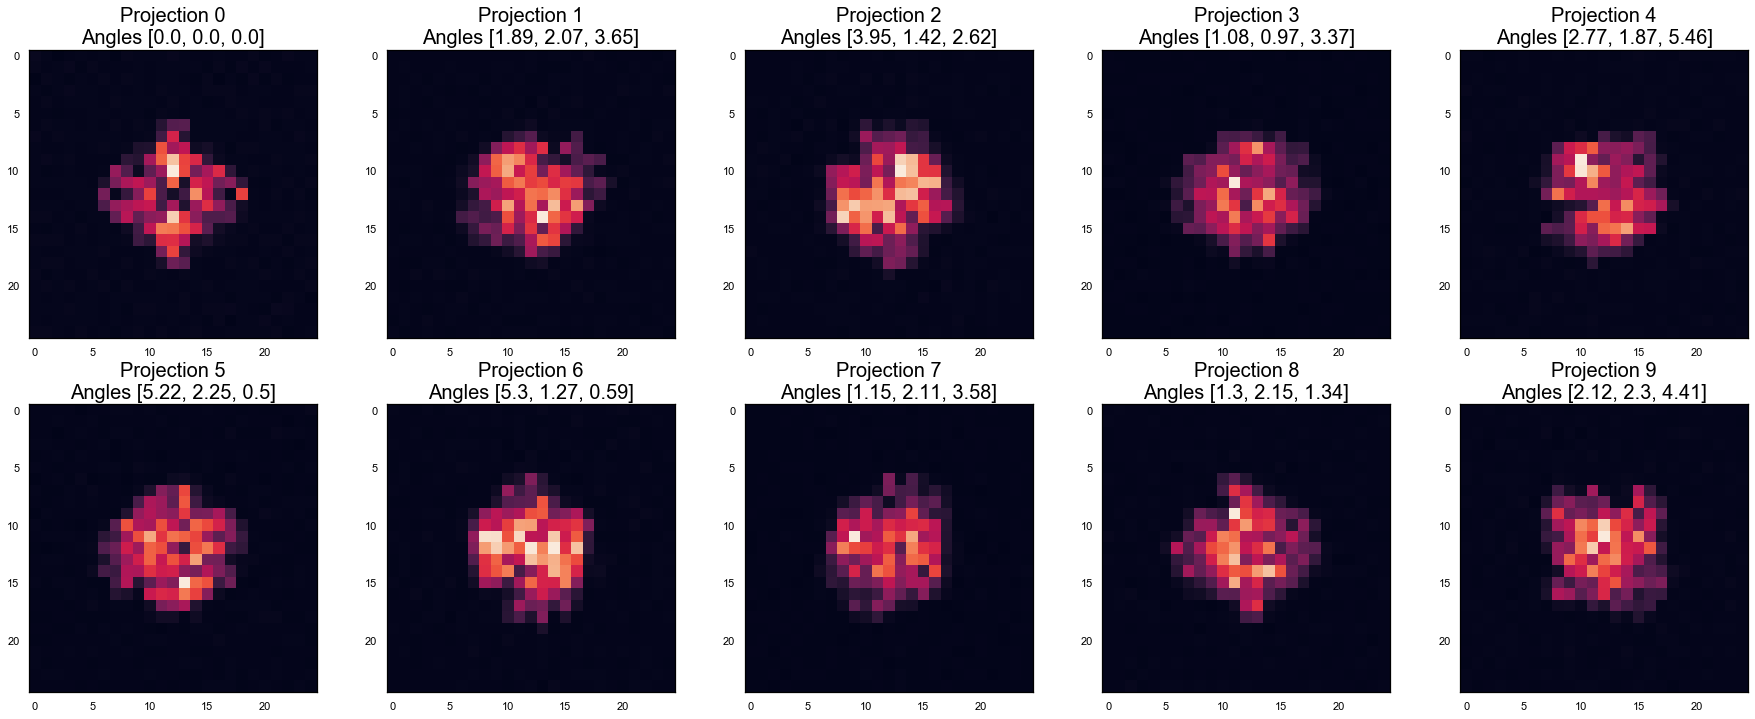

The 311-th iteration


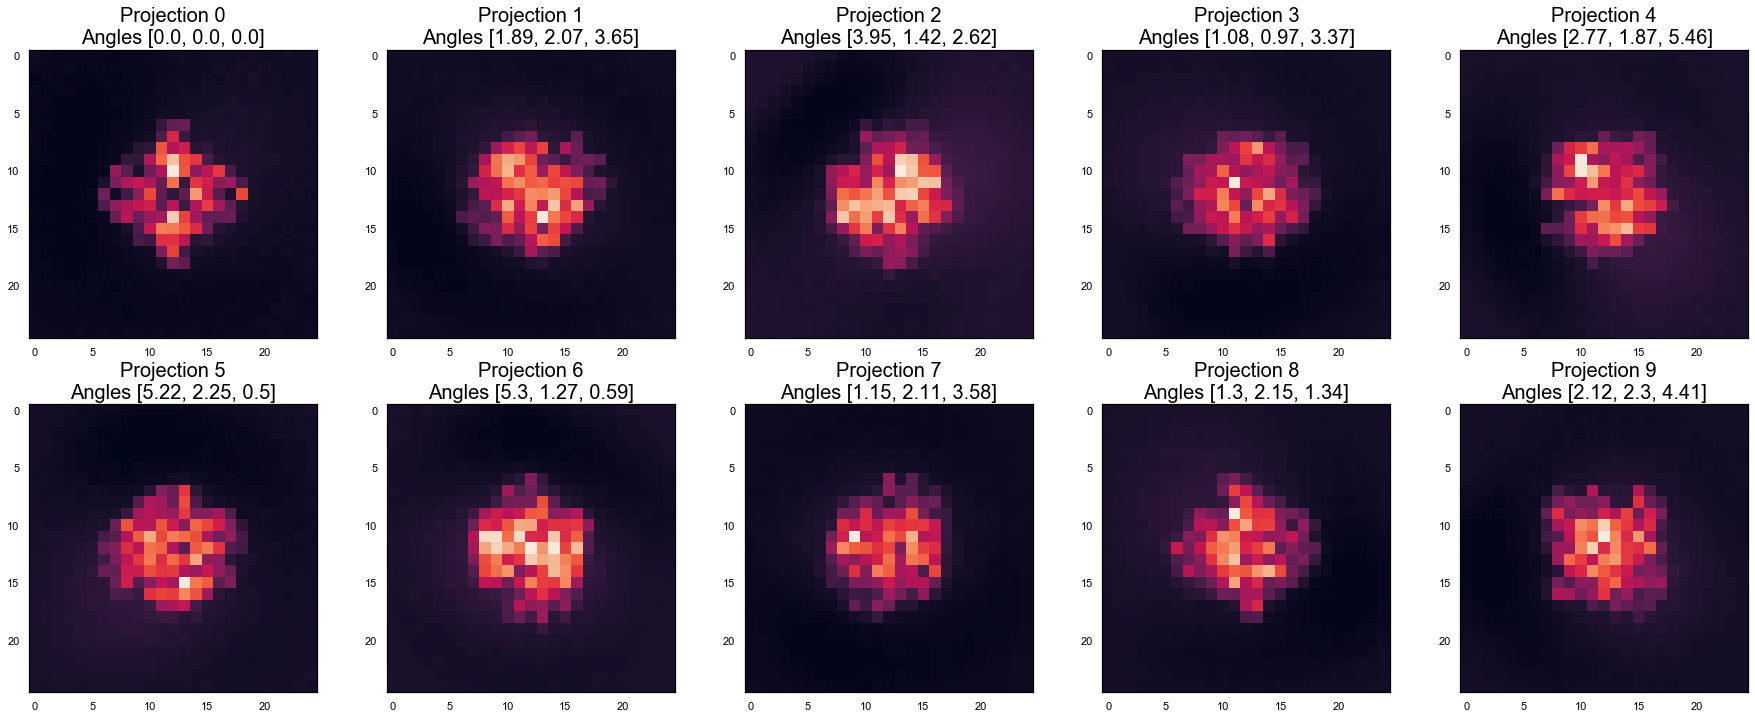

The 321-th iteration


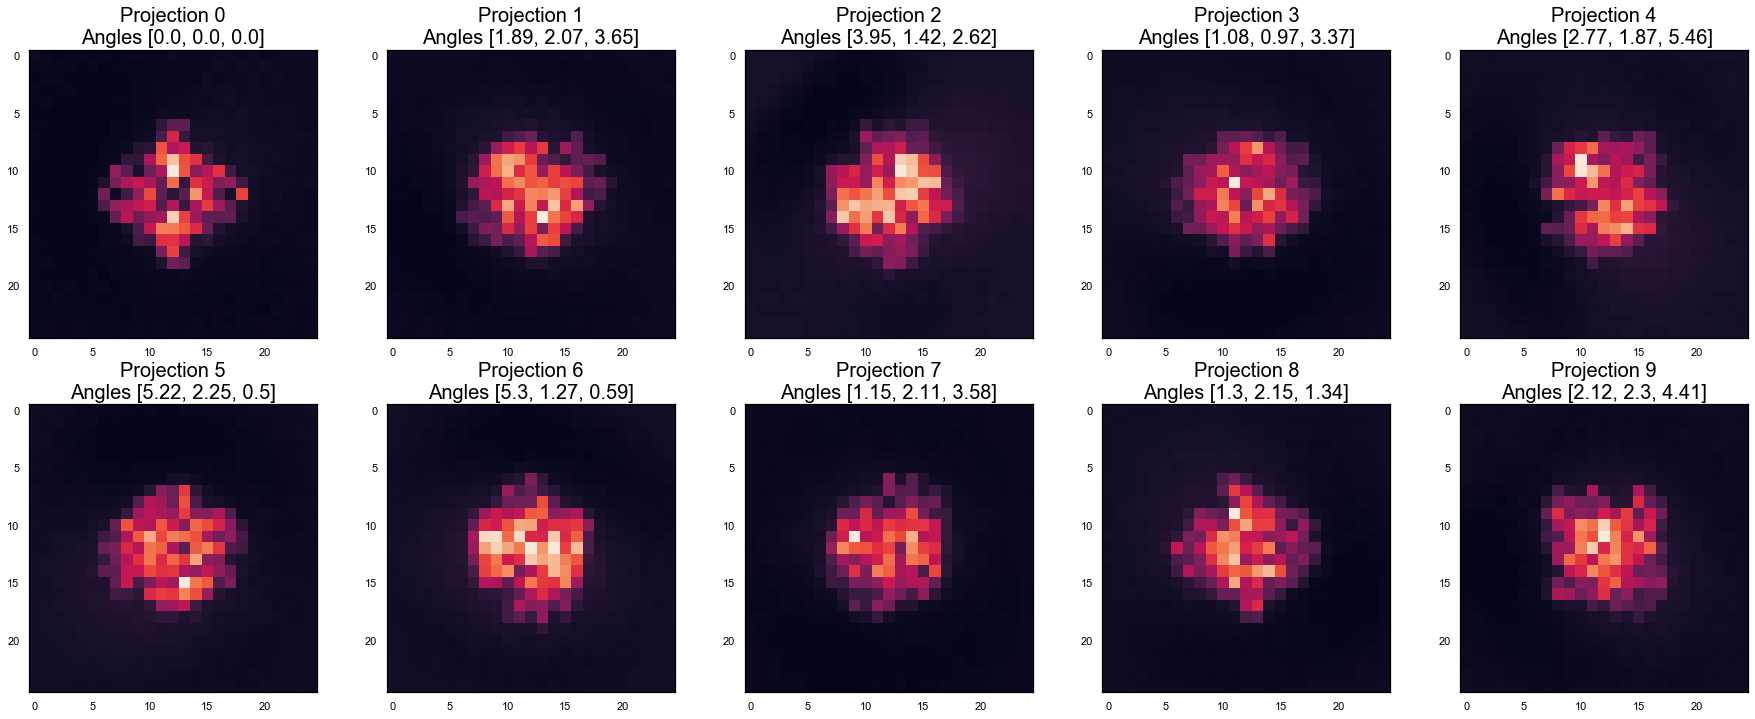

The 331-th iteration


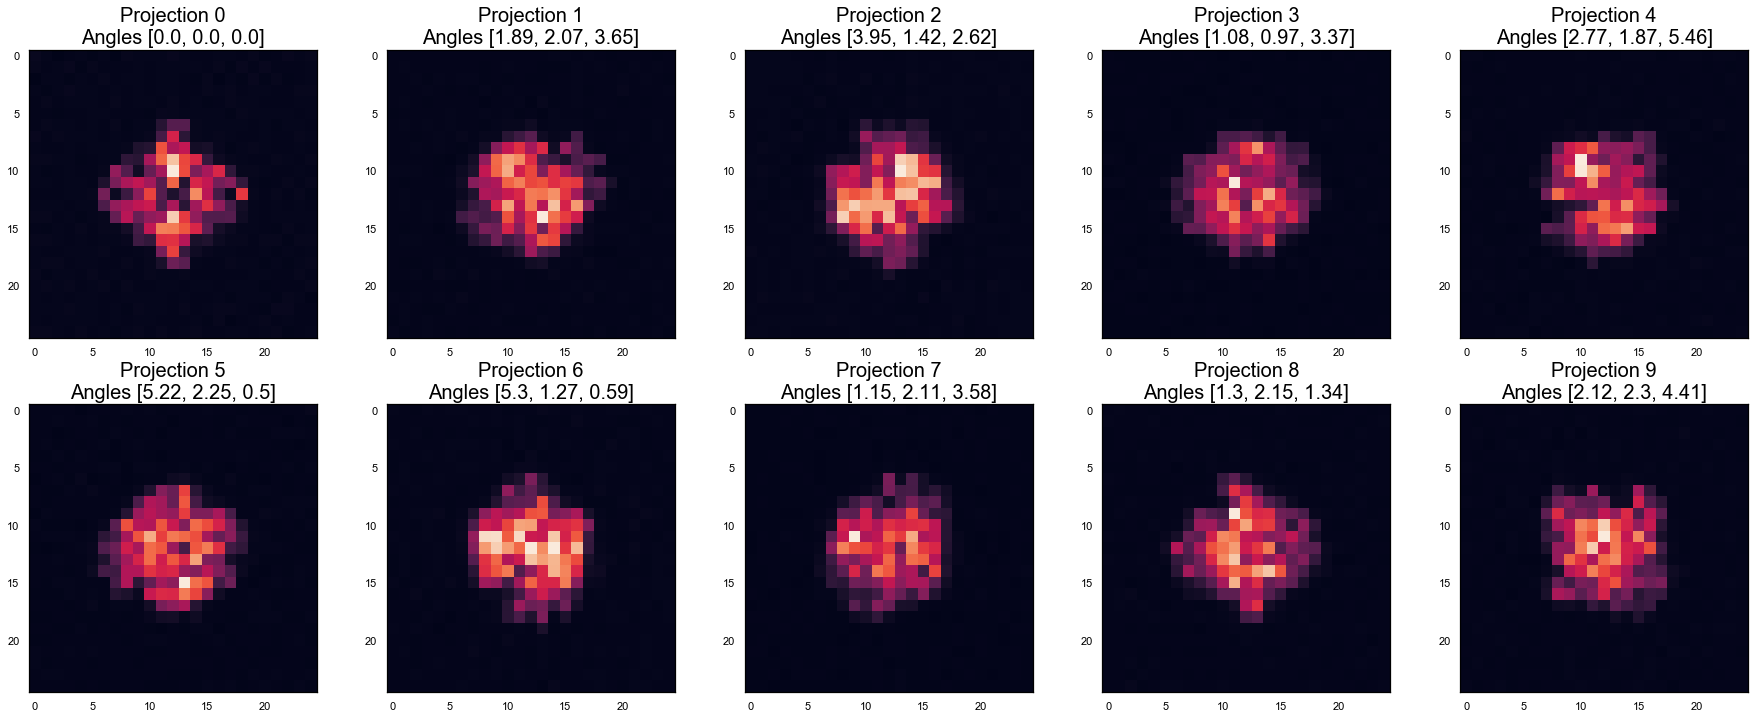

The 341-th iteration


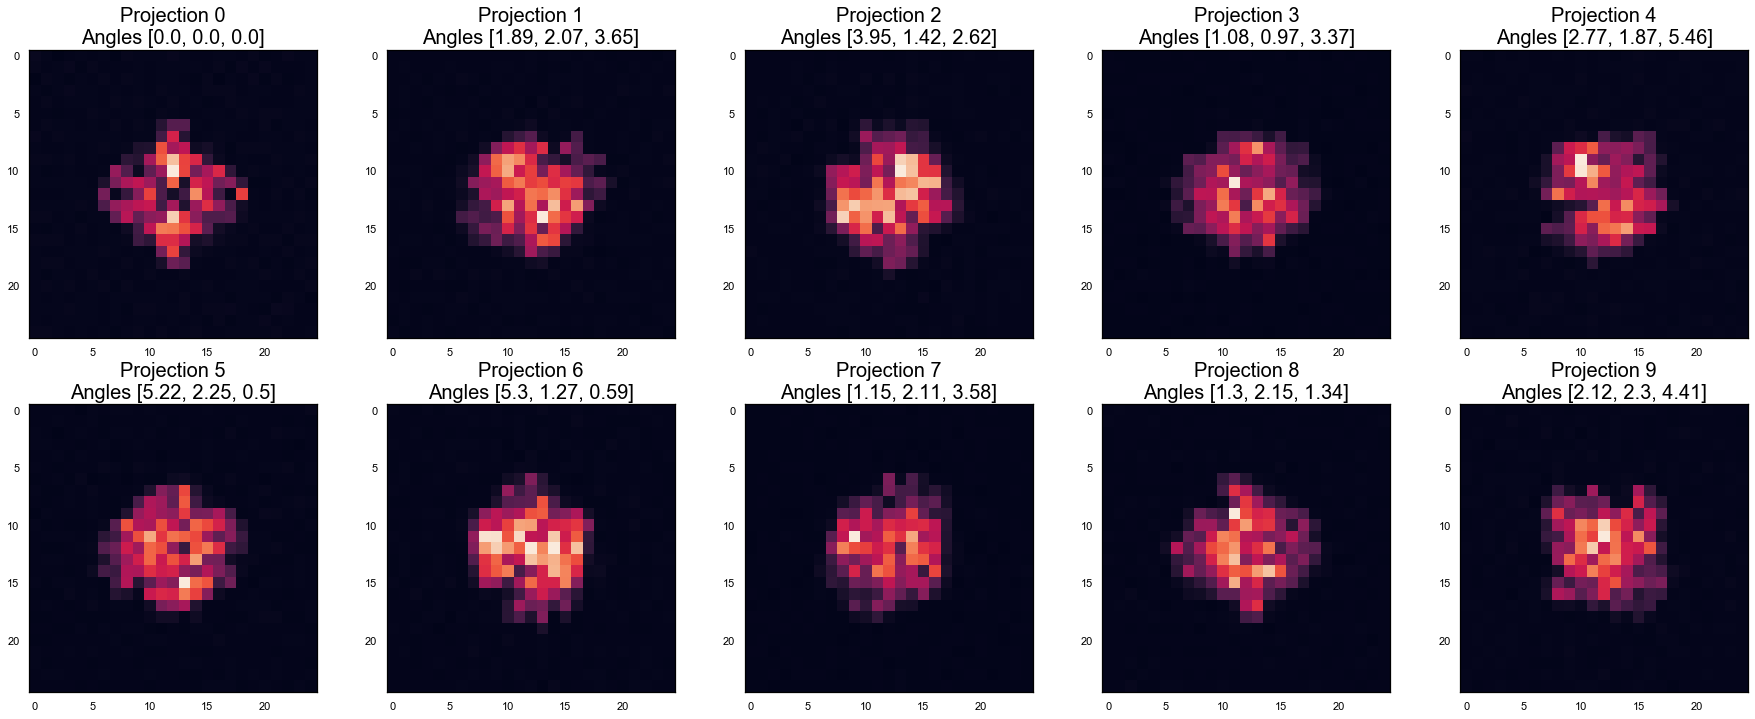

The 351-th iteration


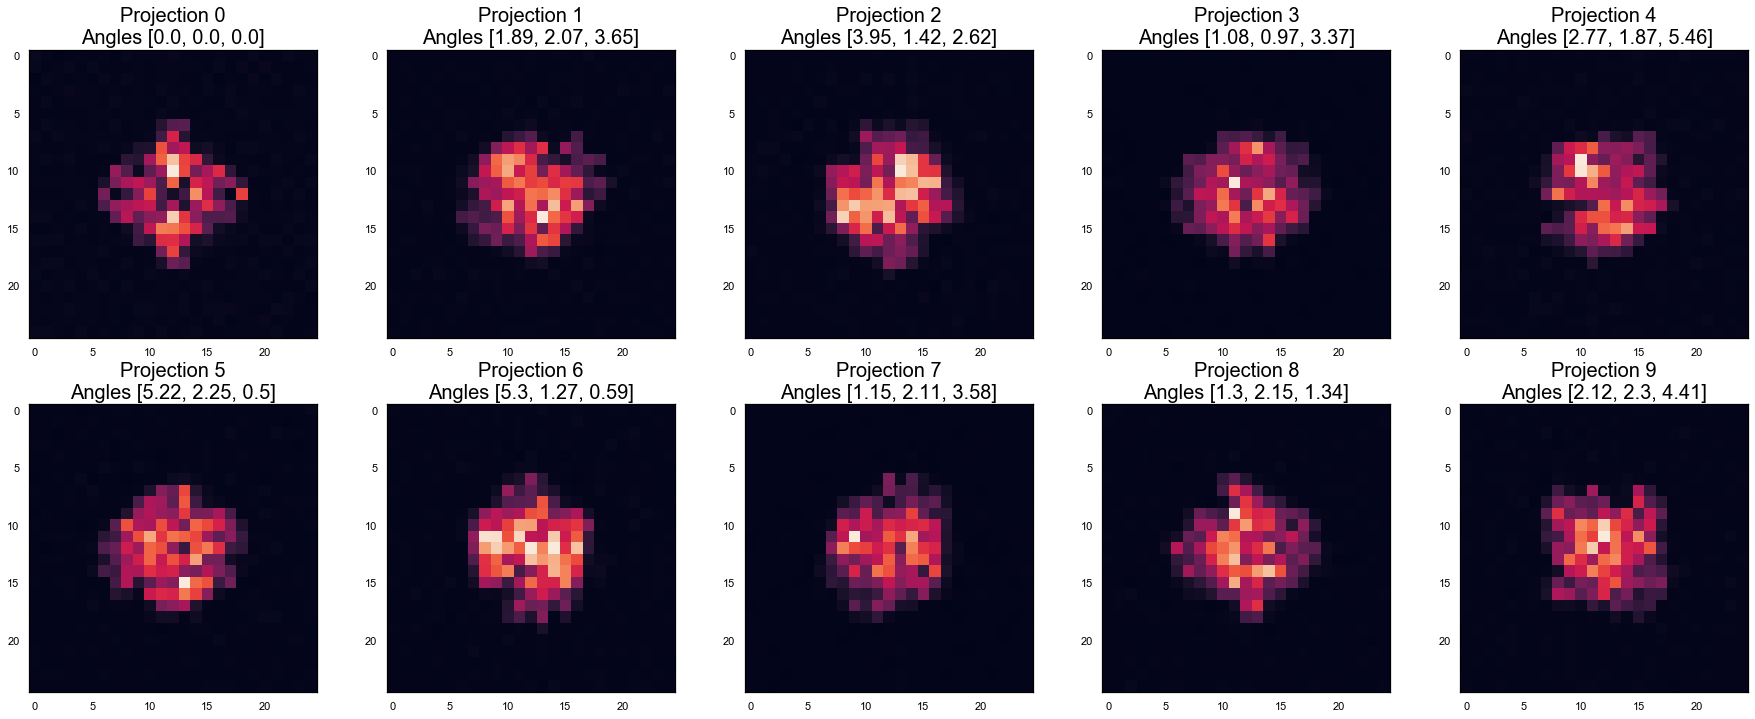

The 361-th iteration


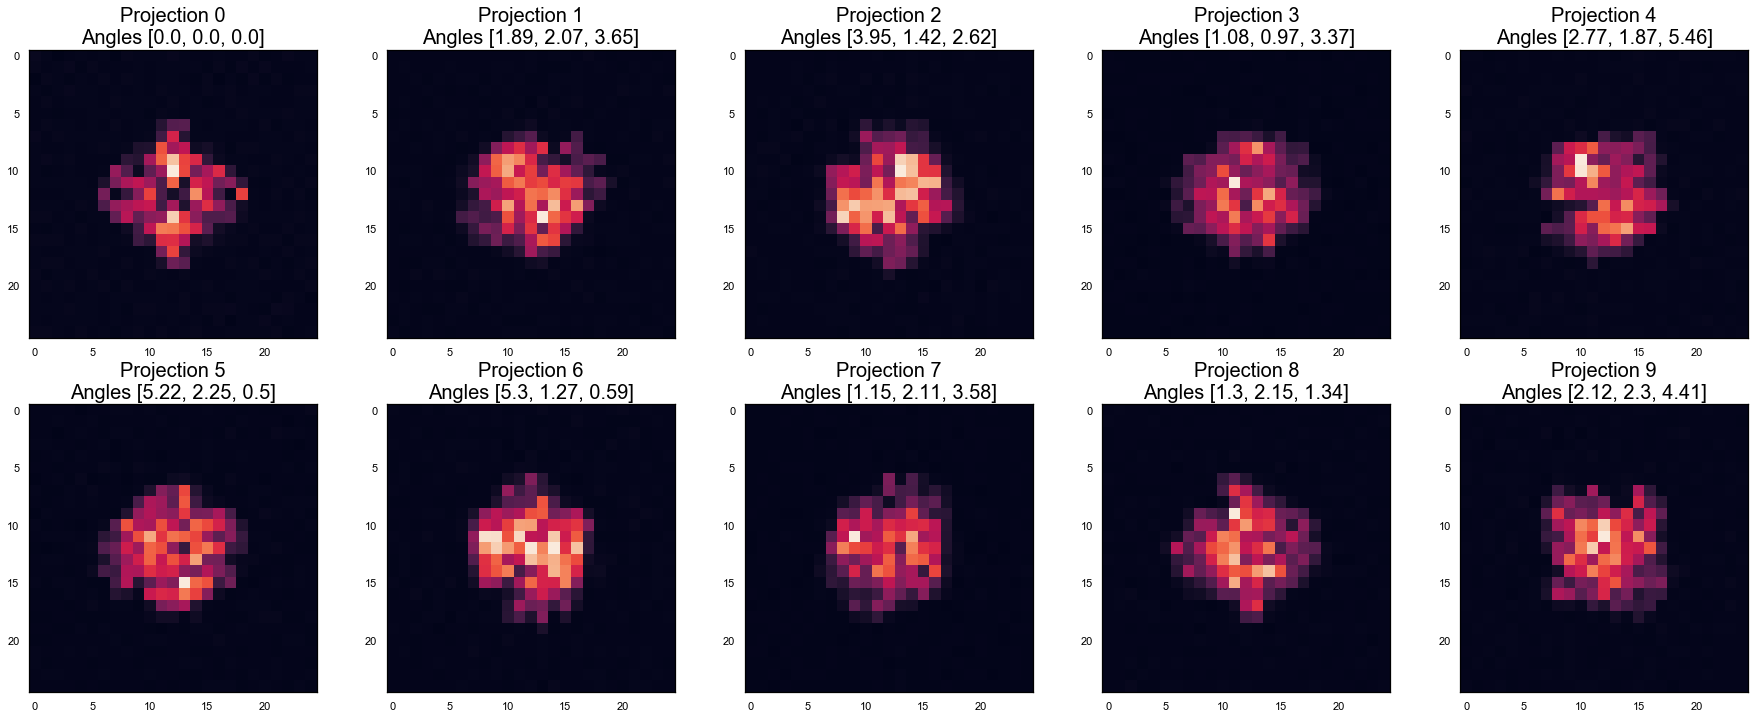

The 371-th iteration


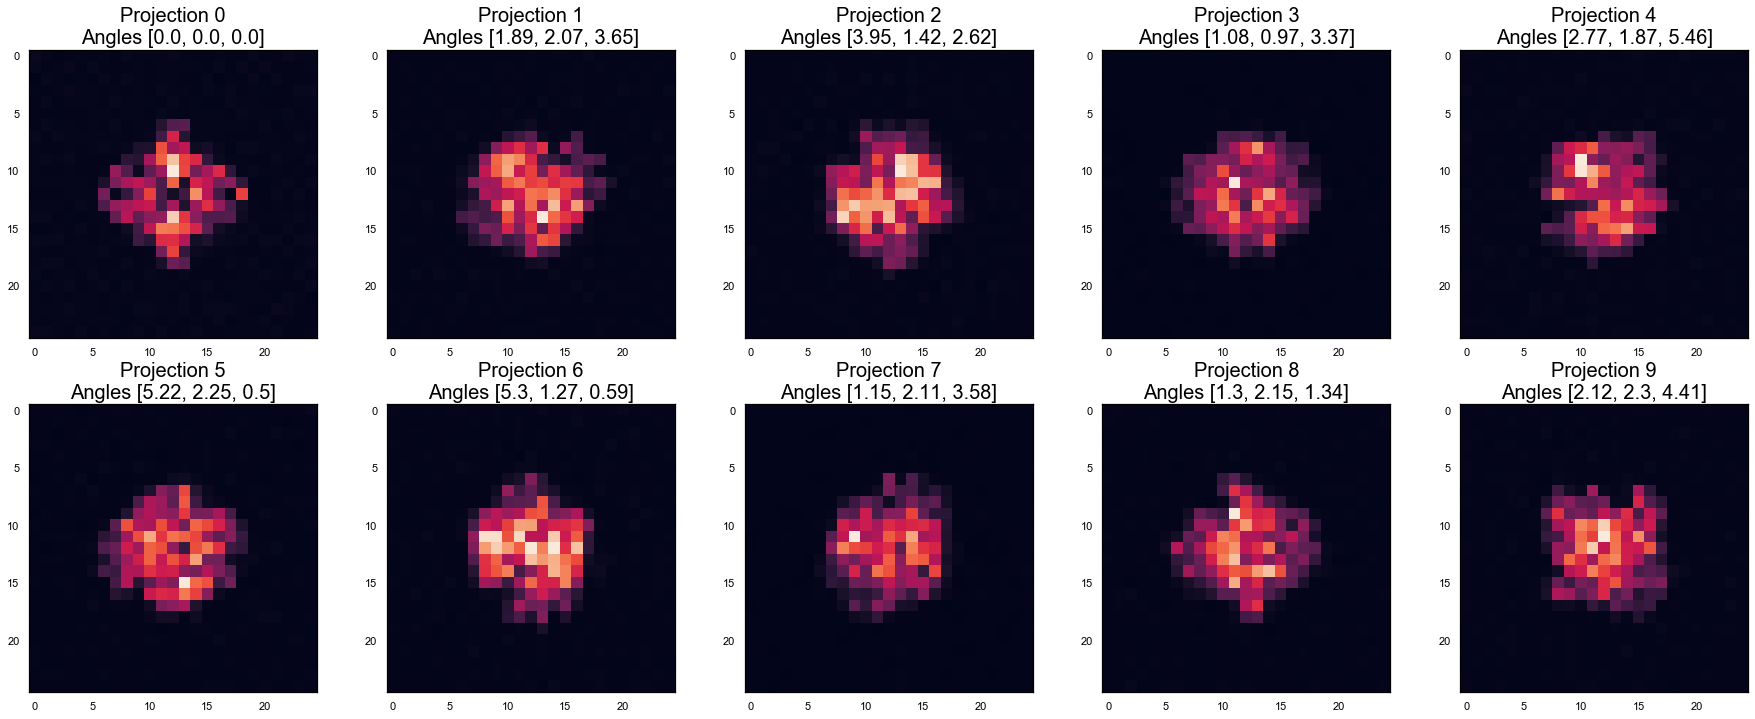

The 381-th iteration


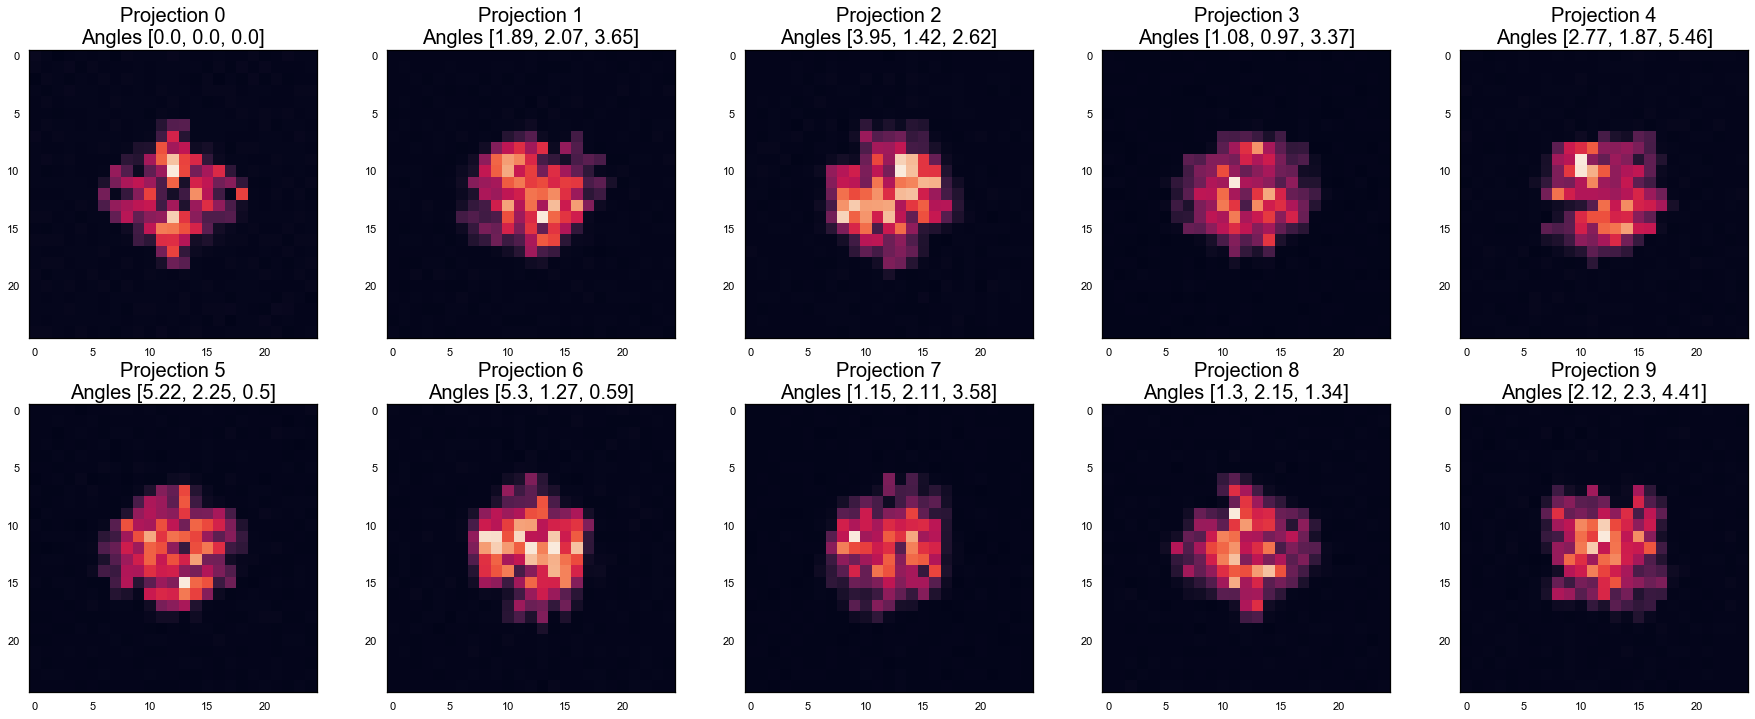

The 391-th iteration


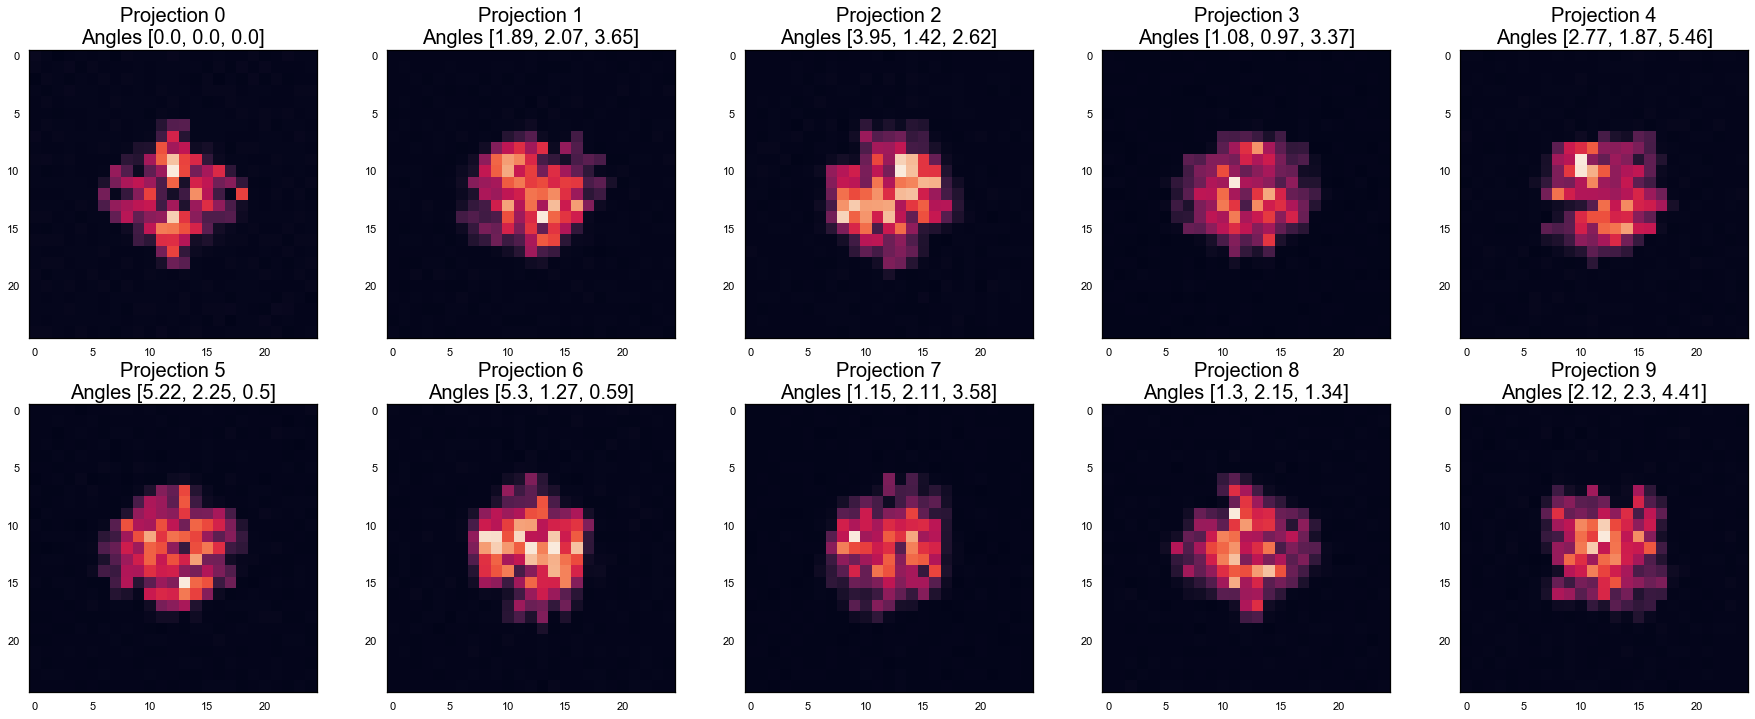

The 401-th iteration


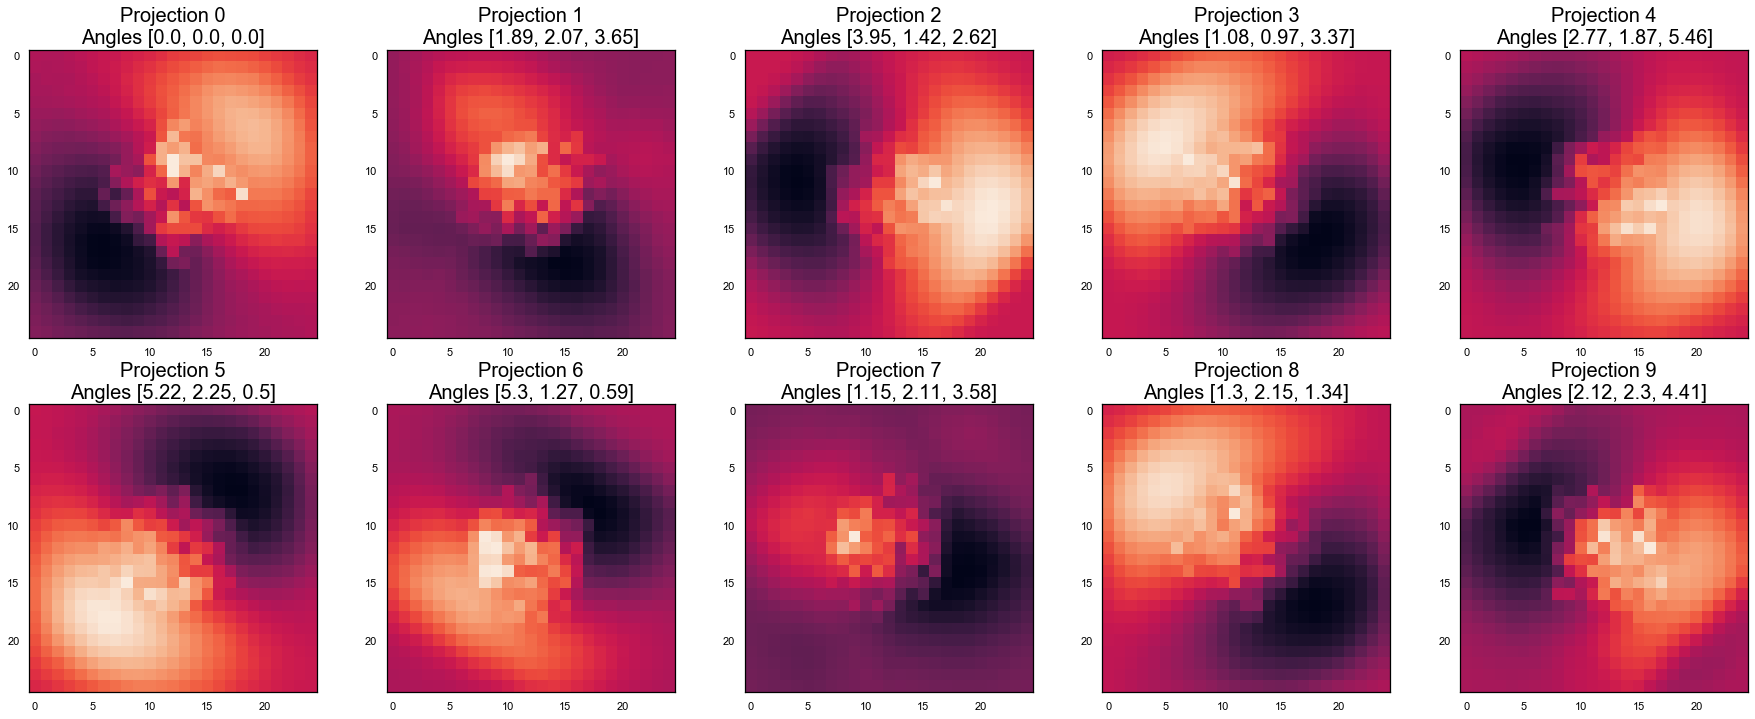

The 411-th iteration


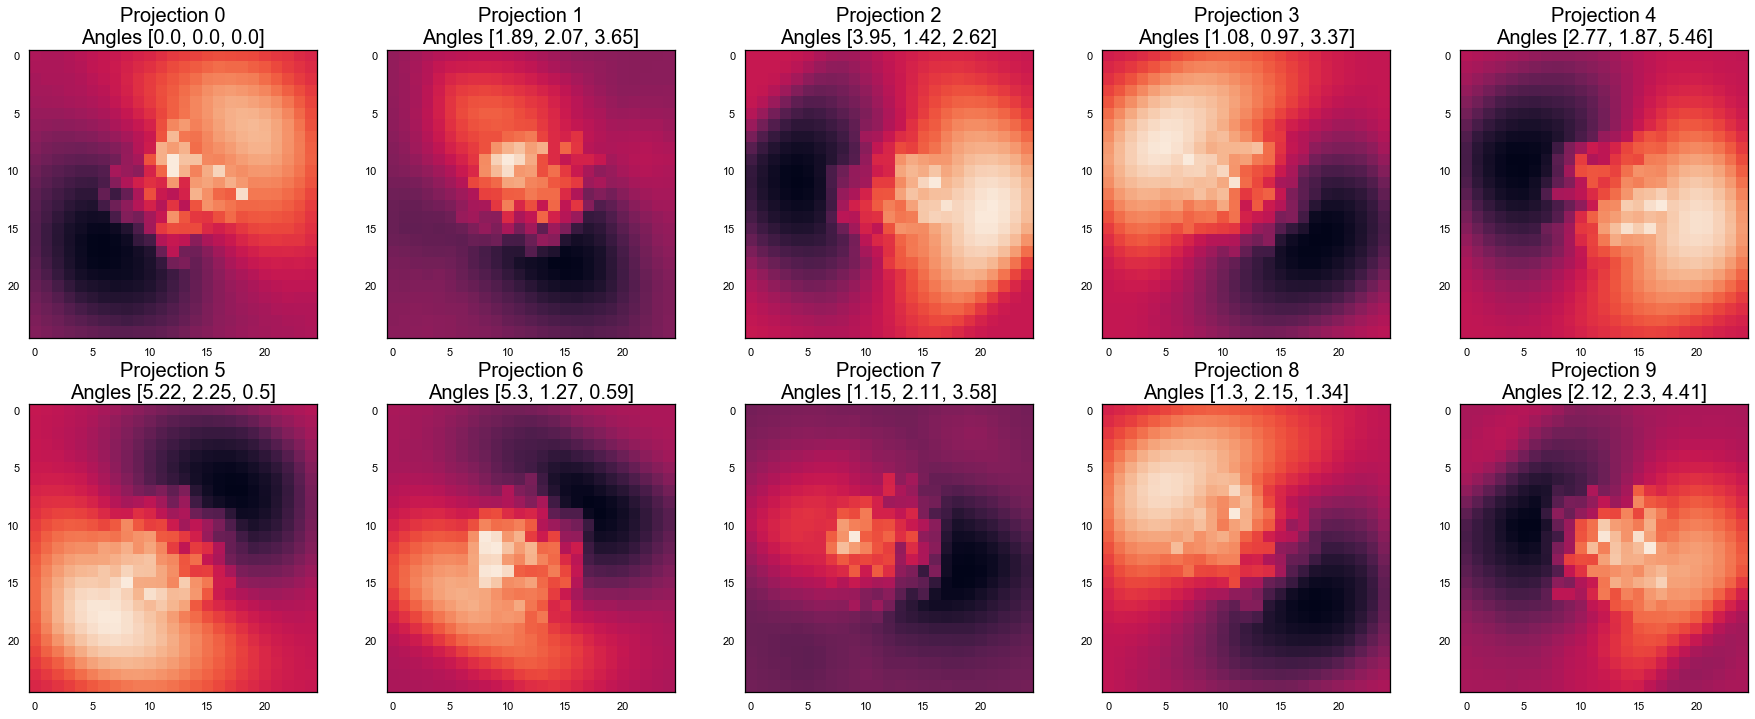

The 421-th iteration


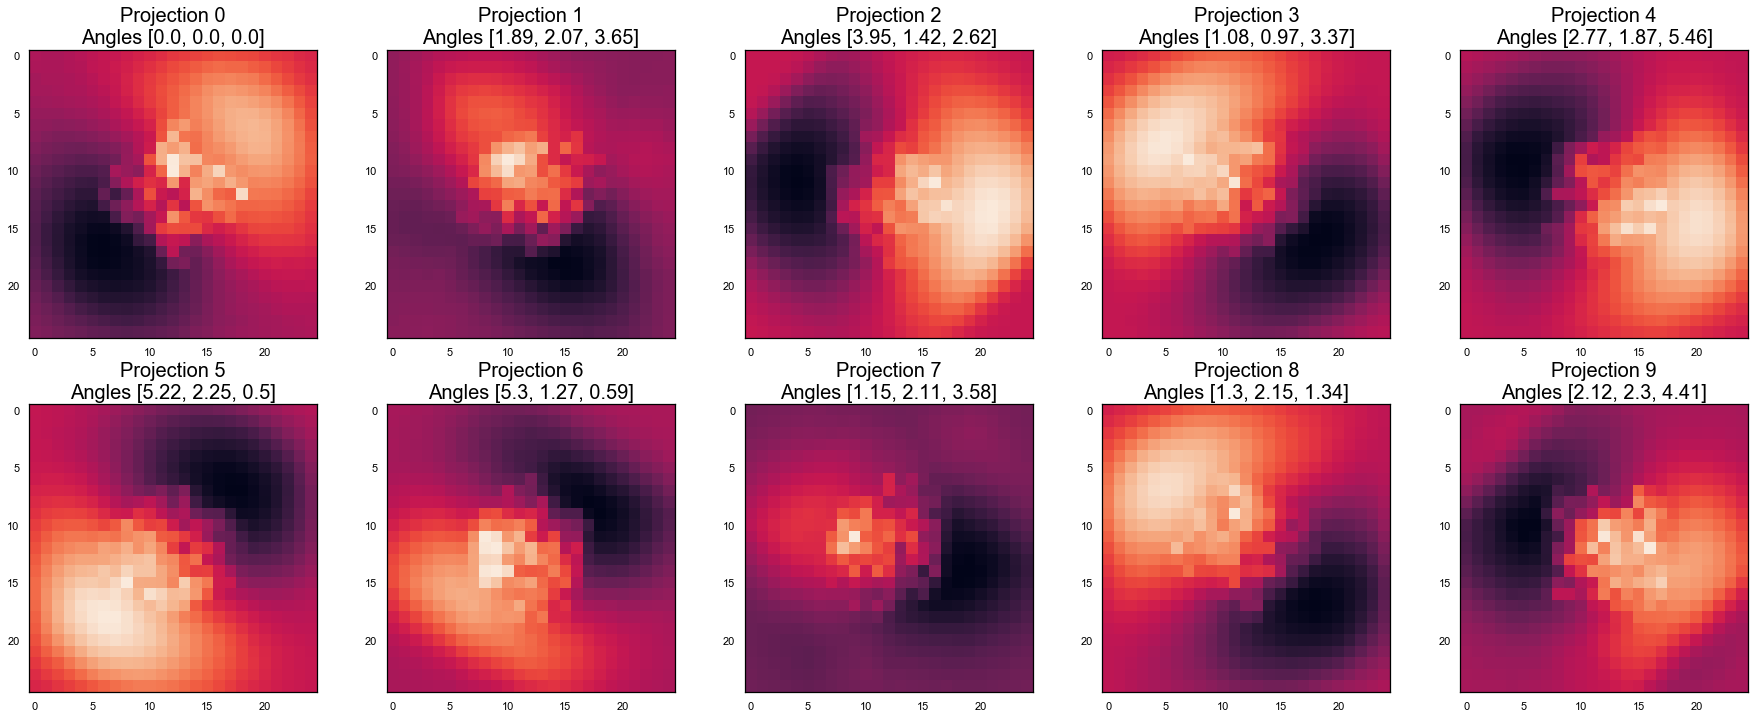

The 431-th iteration


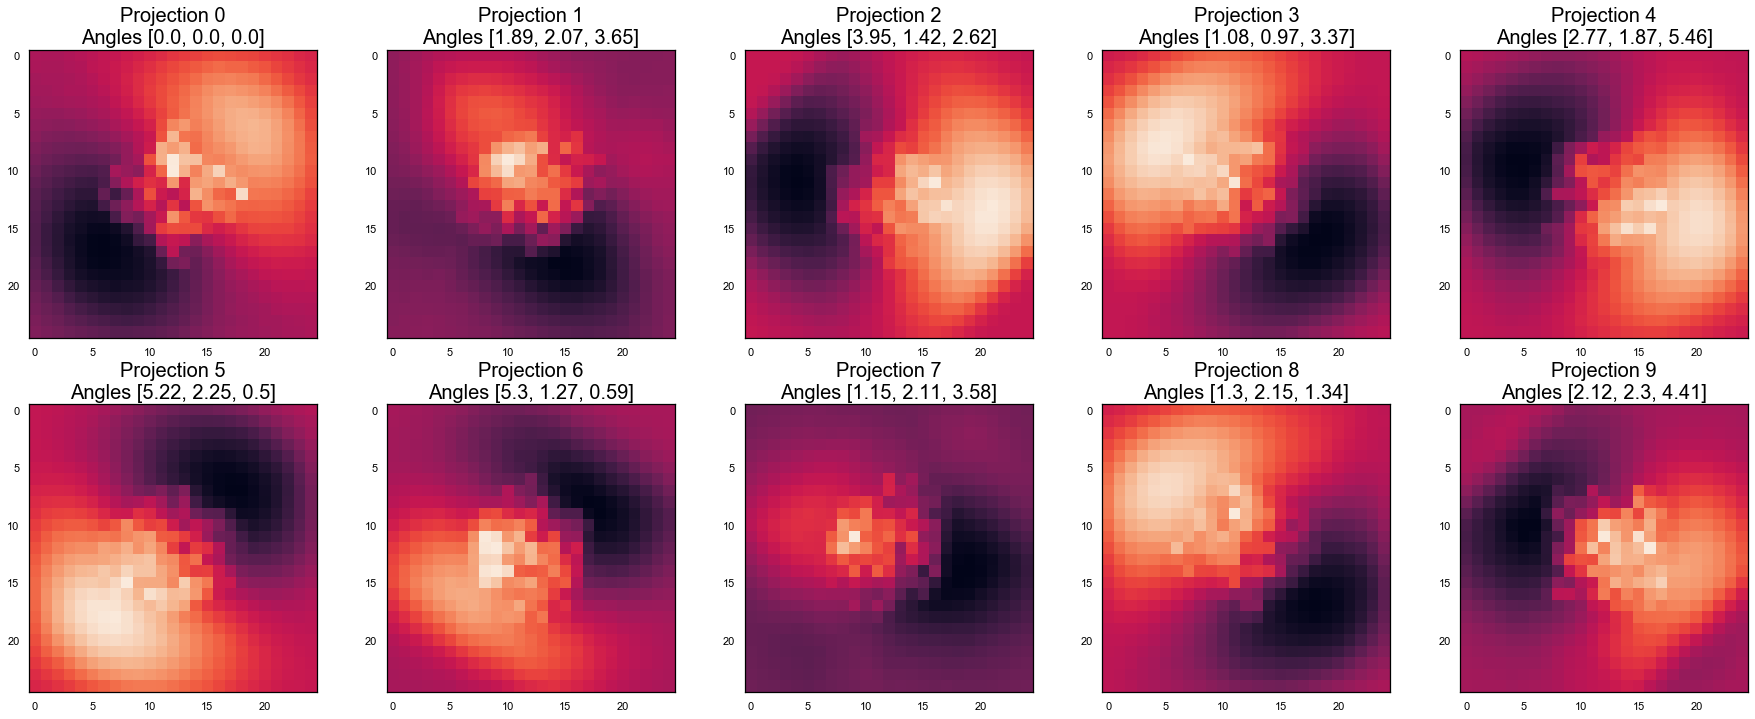

The 441-th iteration


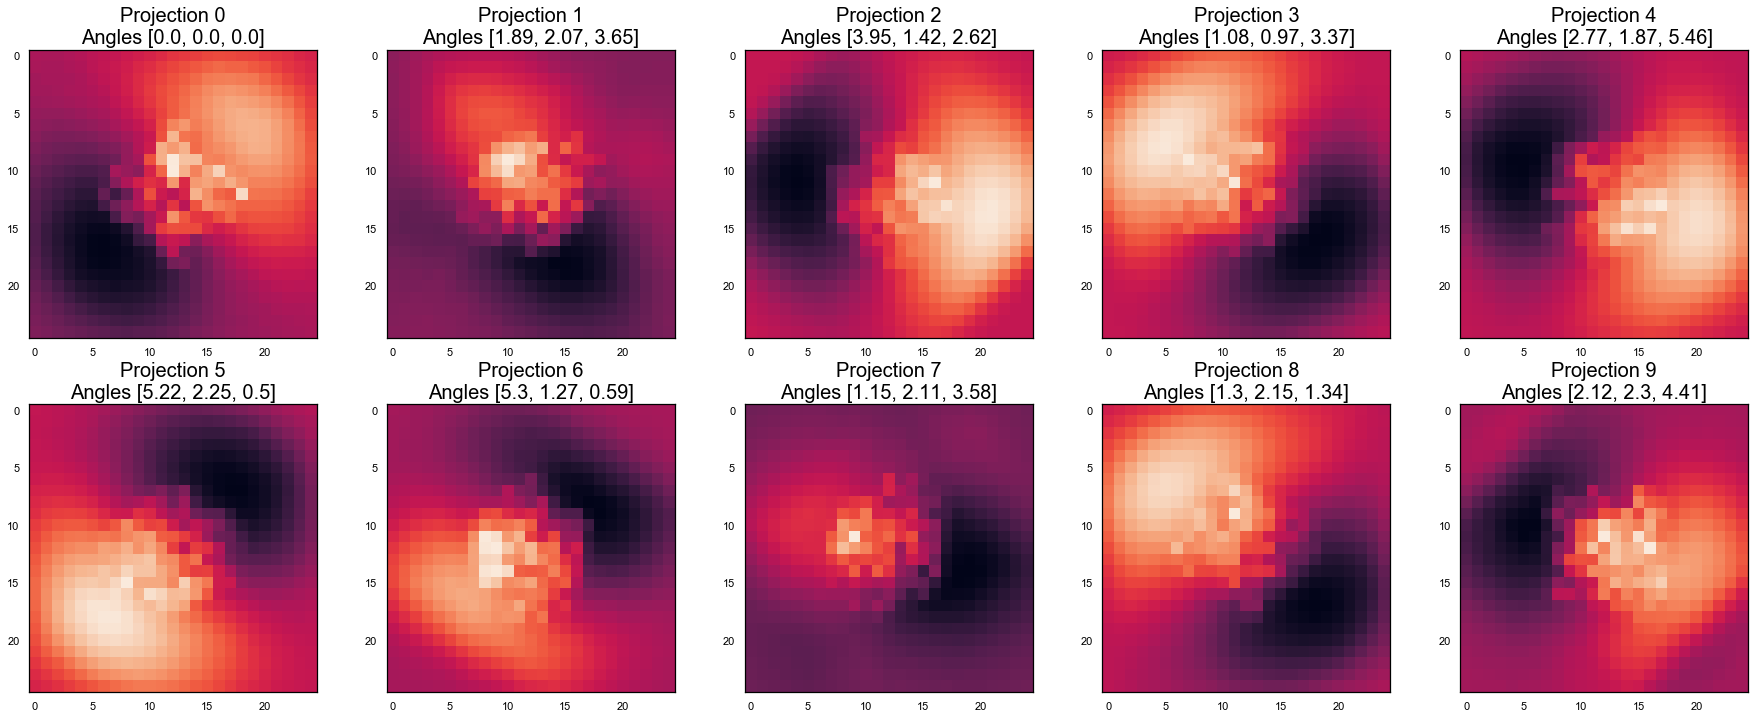

The 451-th iteration


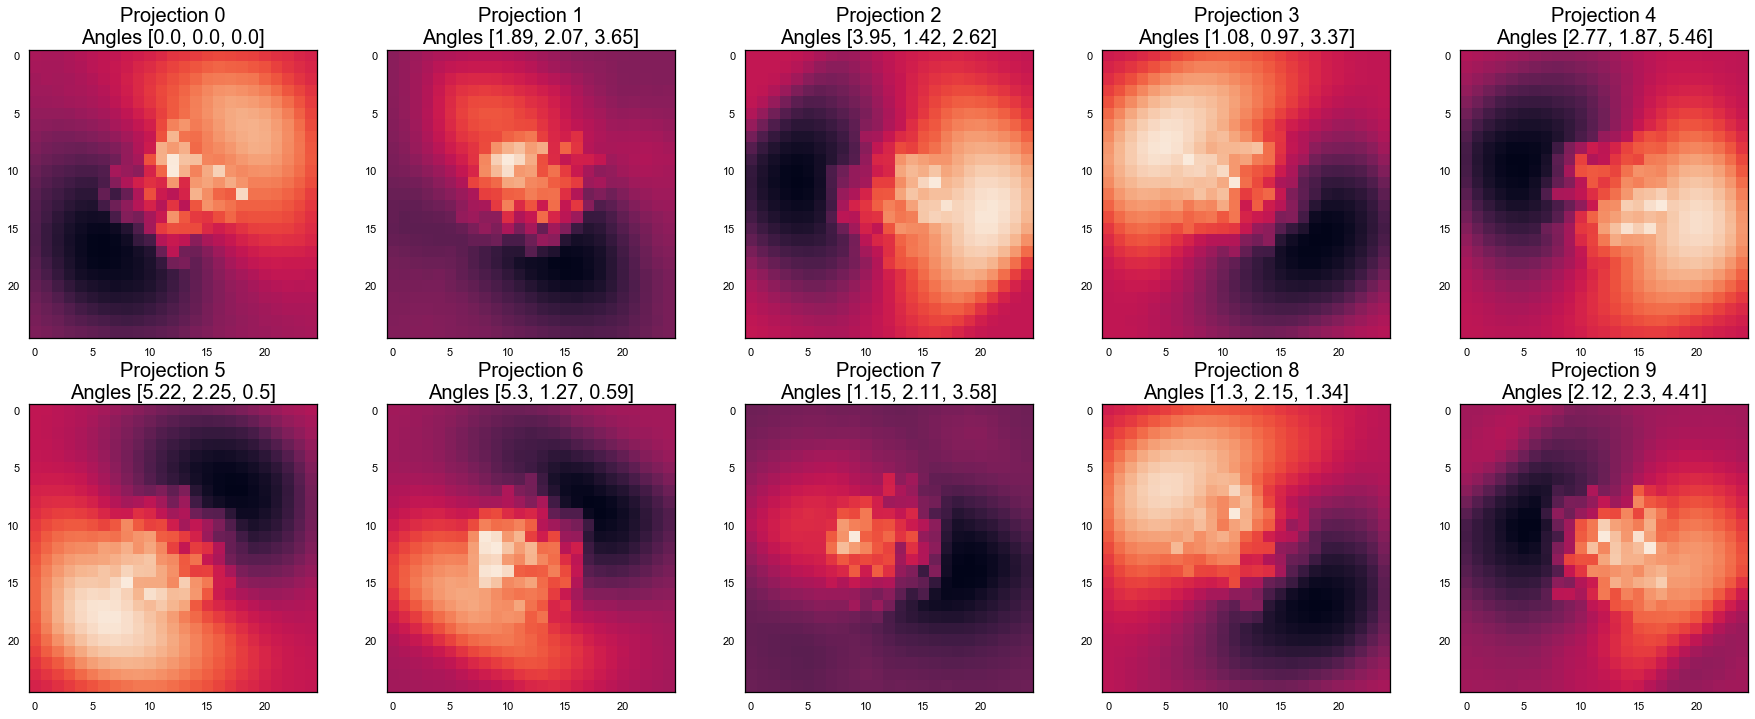

The 461-th iteration


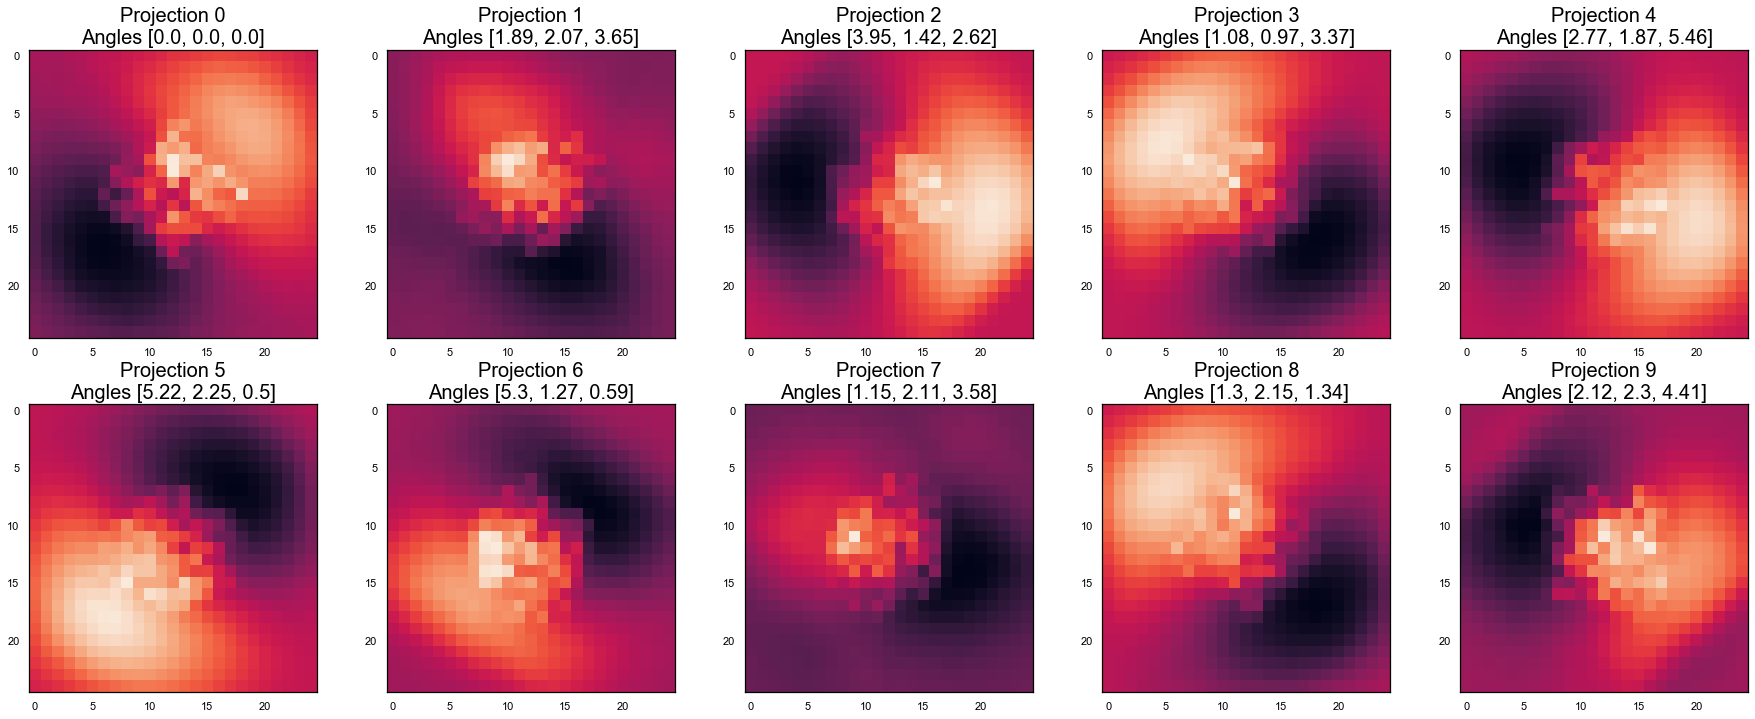

The 471-th iteration


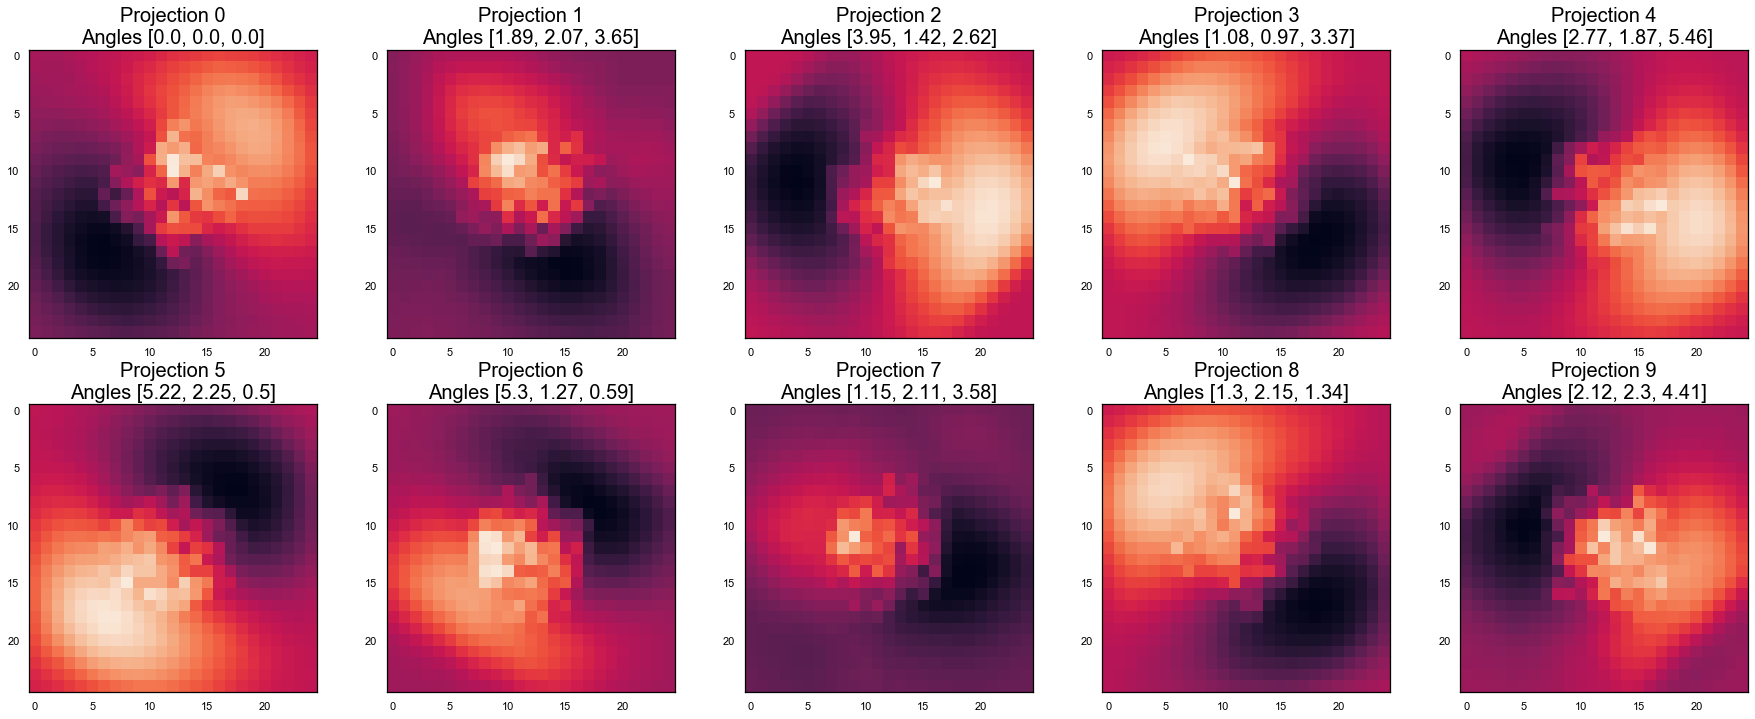

The 481-th iteration


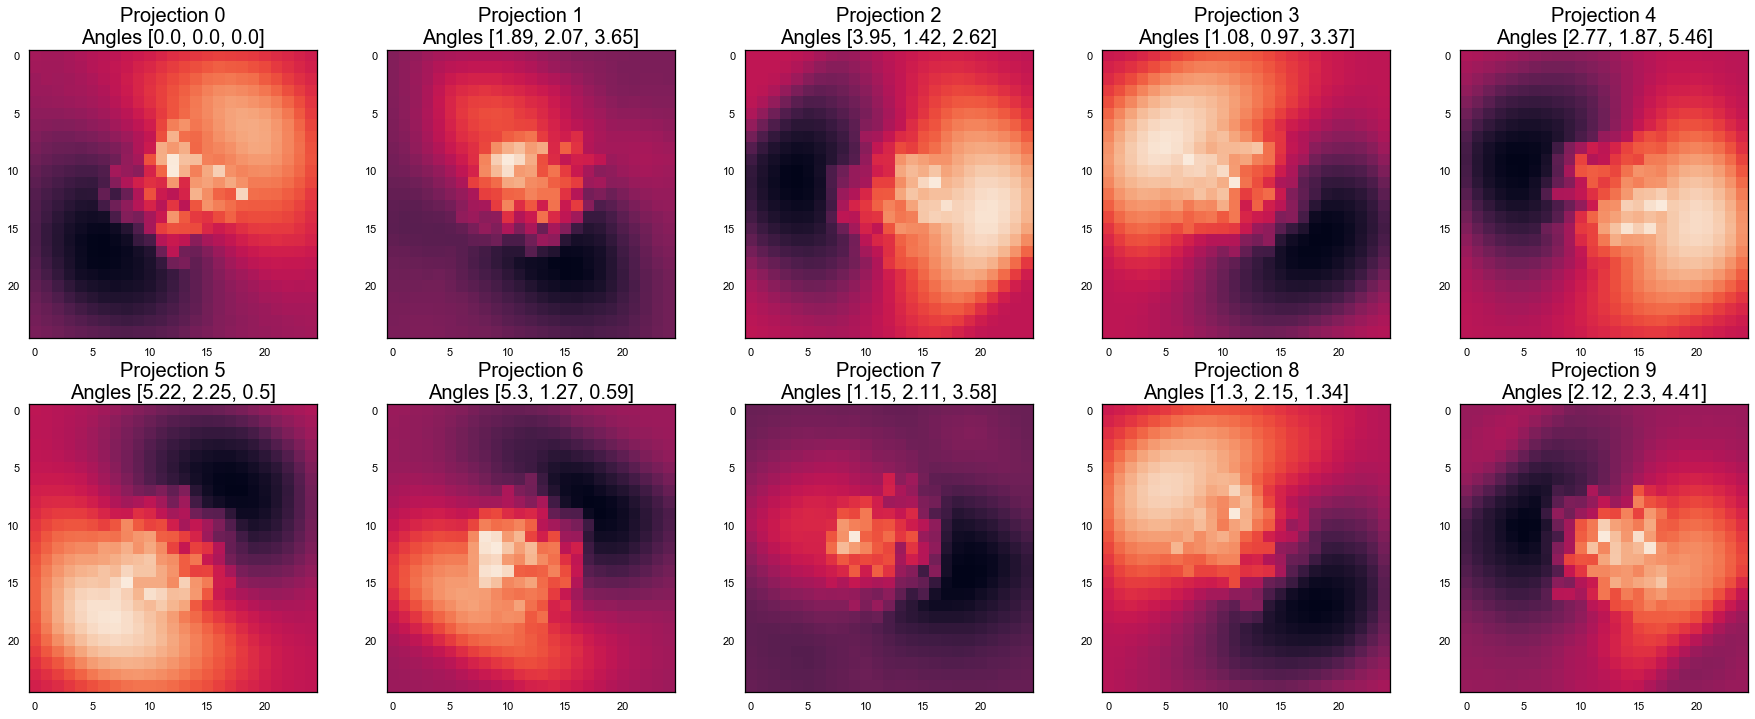

The 491-th iteration


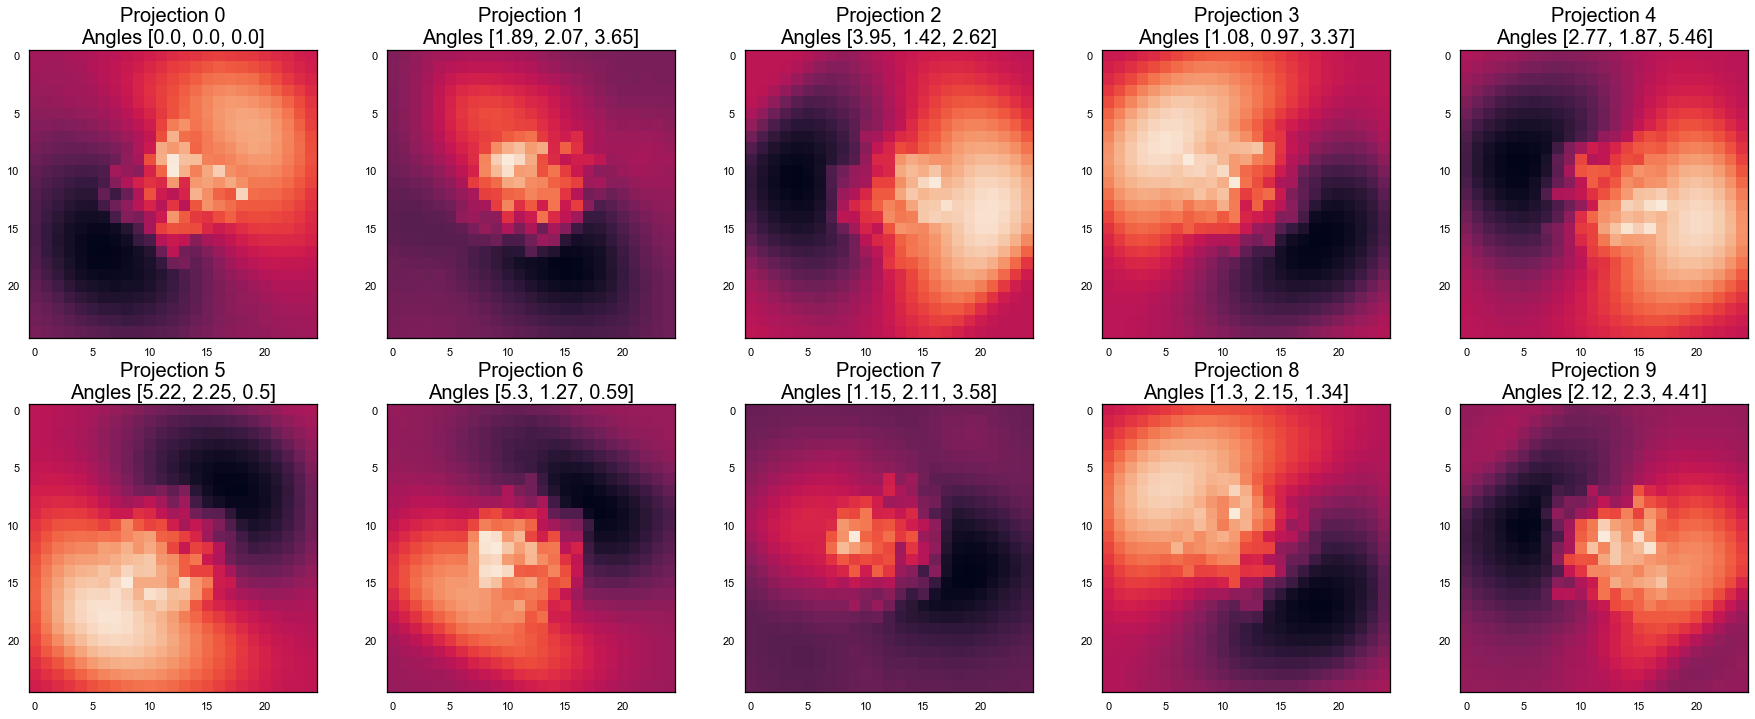

The 501-th iteration


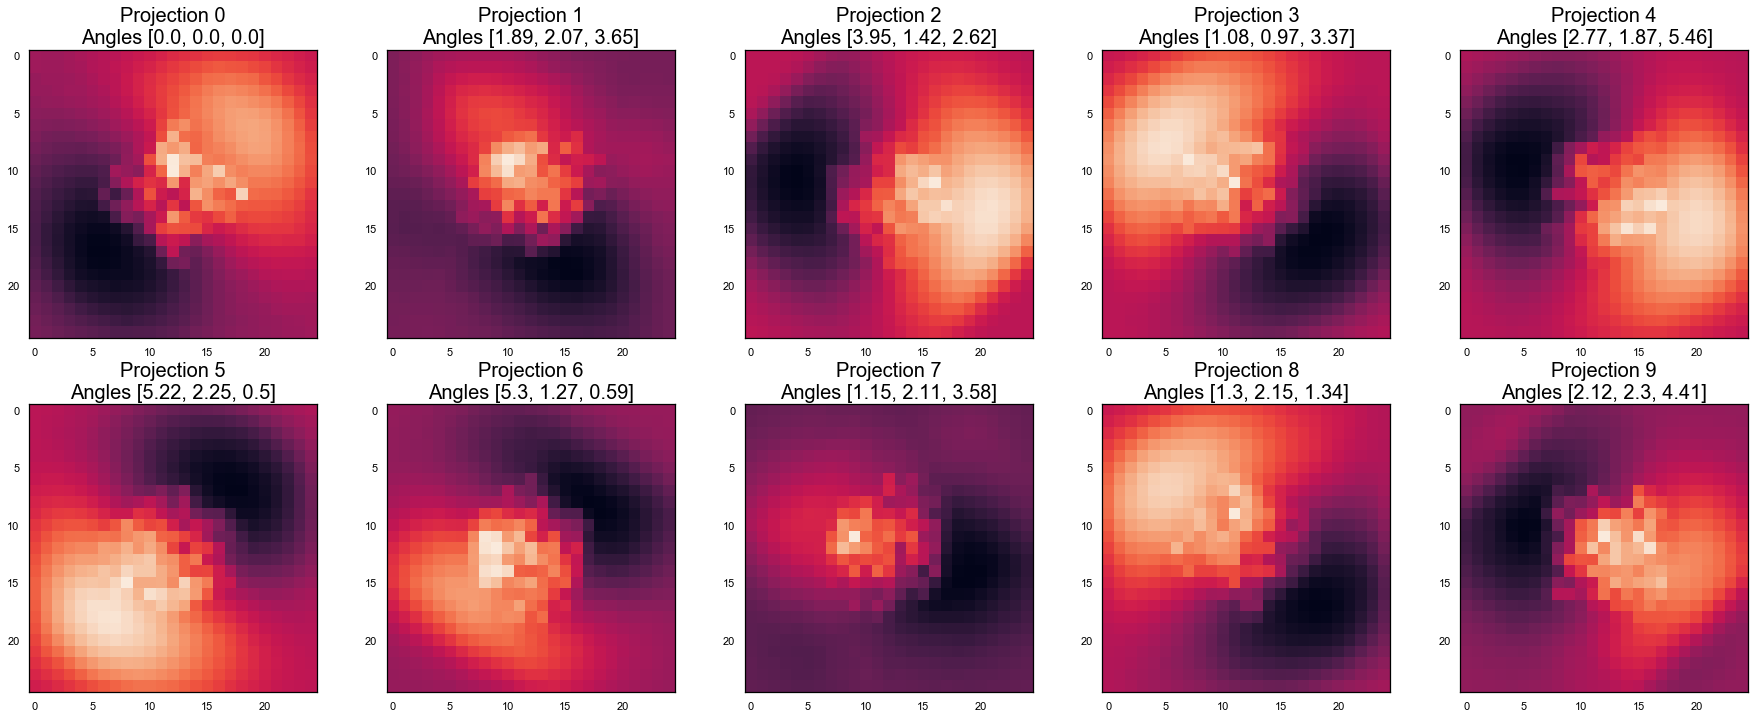

The 511-th iteration


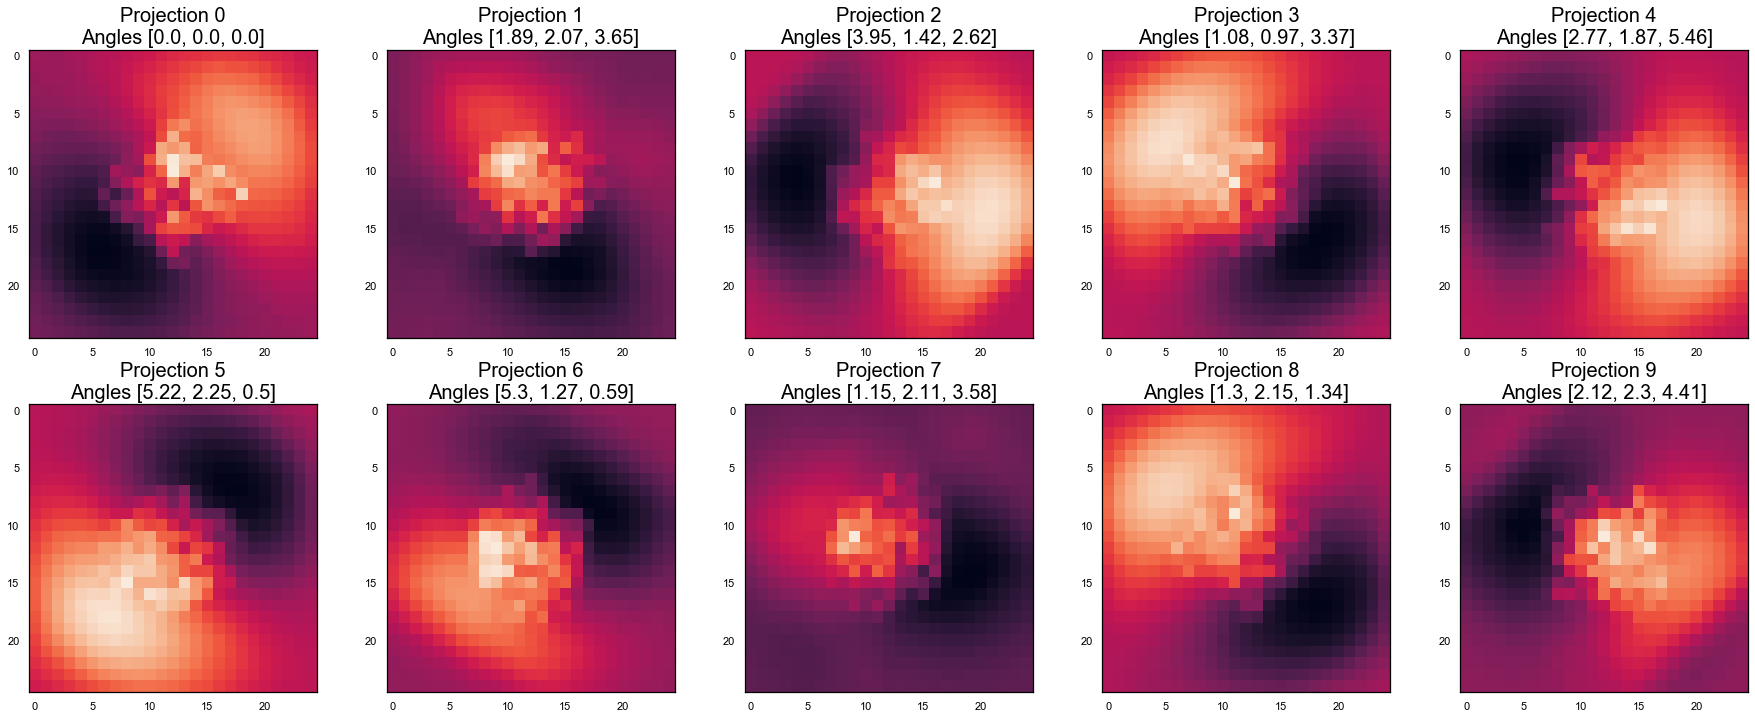

The 521-th iteration


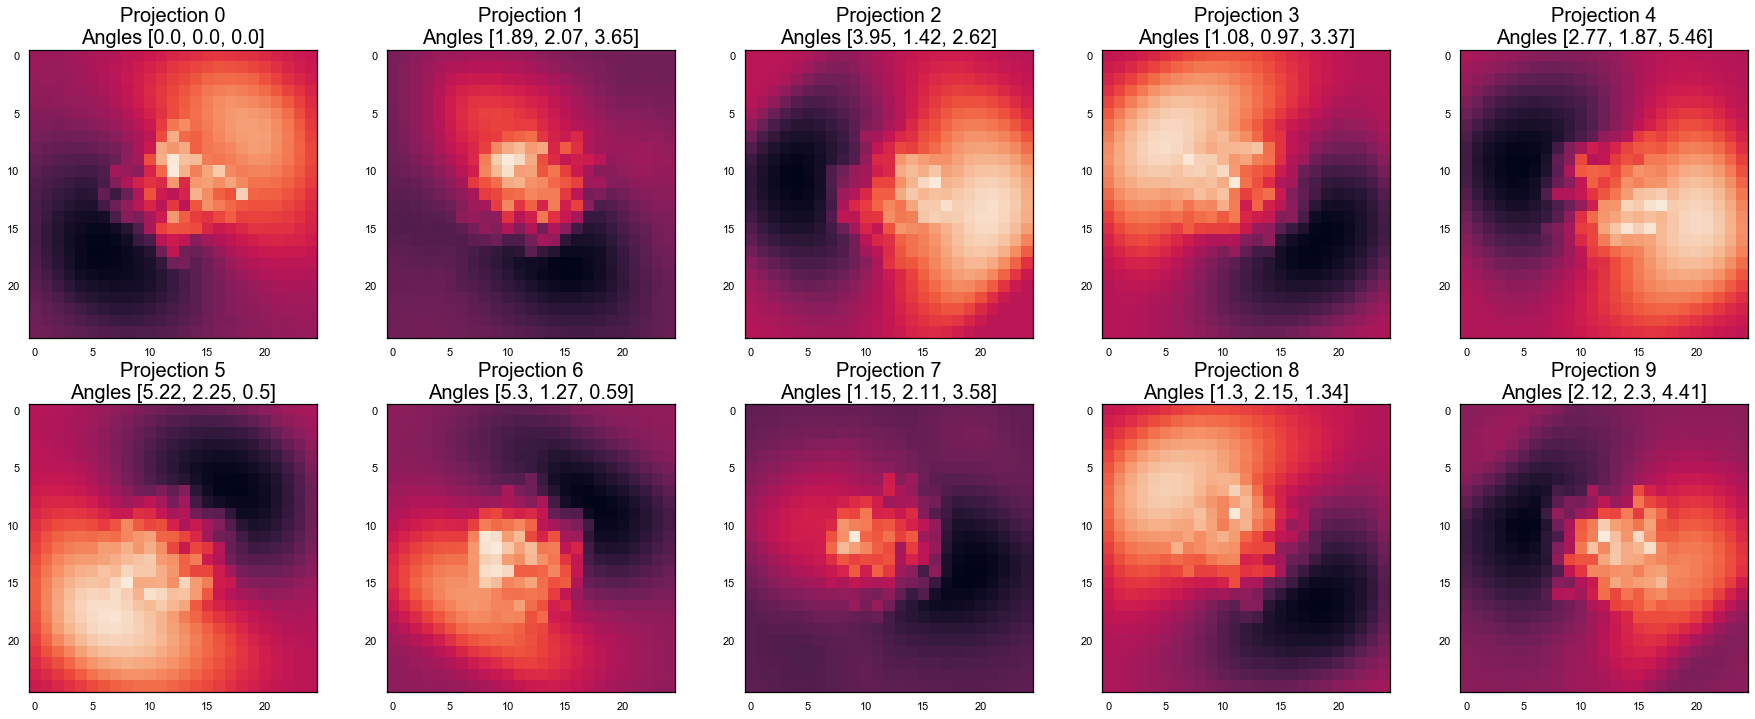

The 531-th iteration


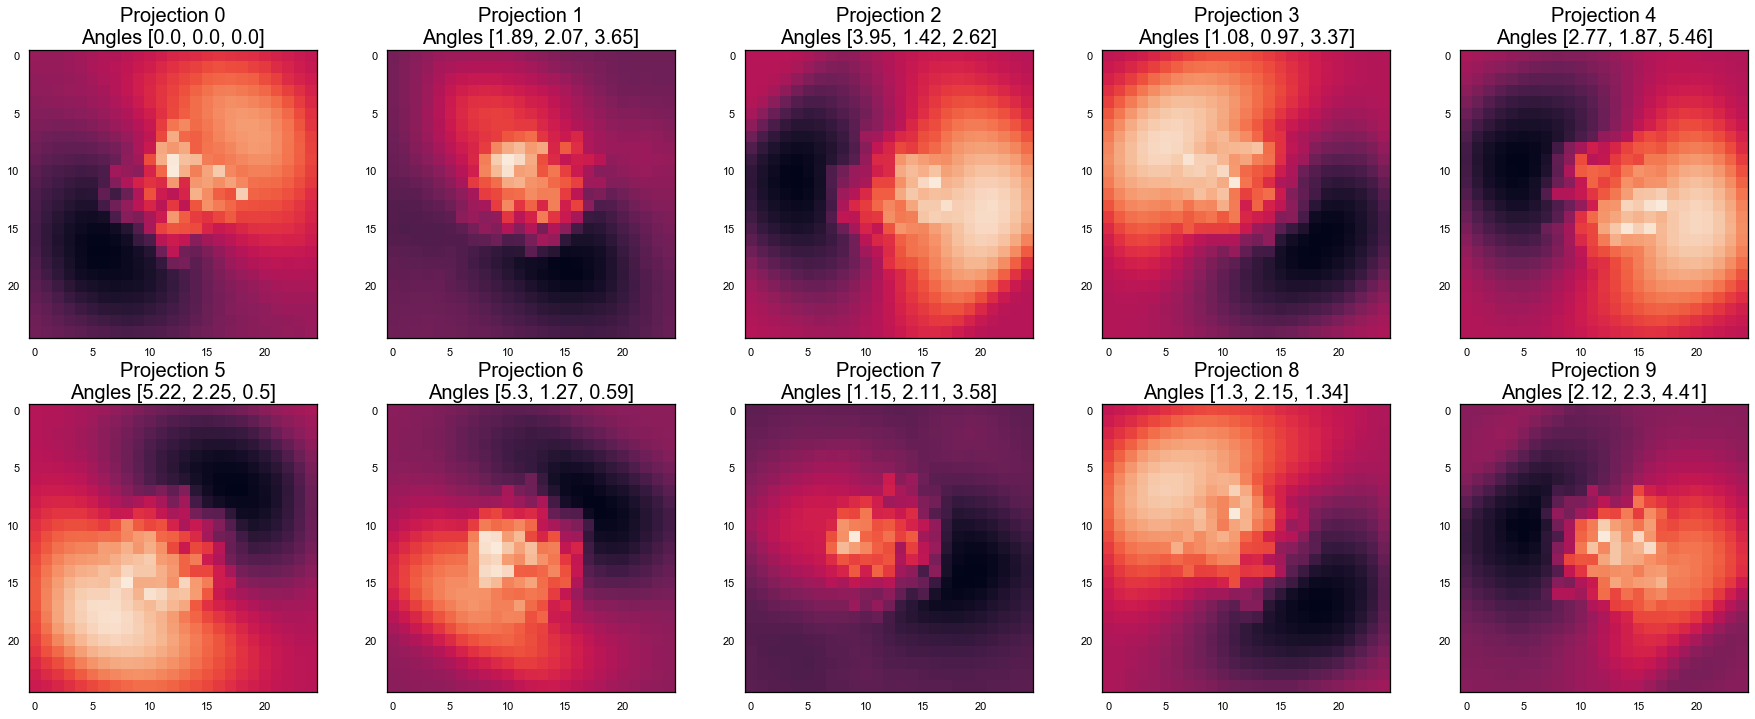

The 541-th iteration


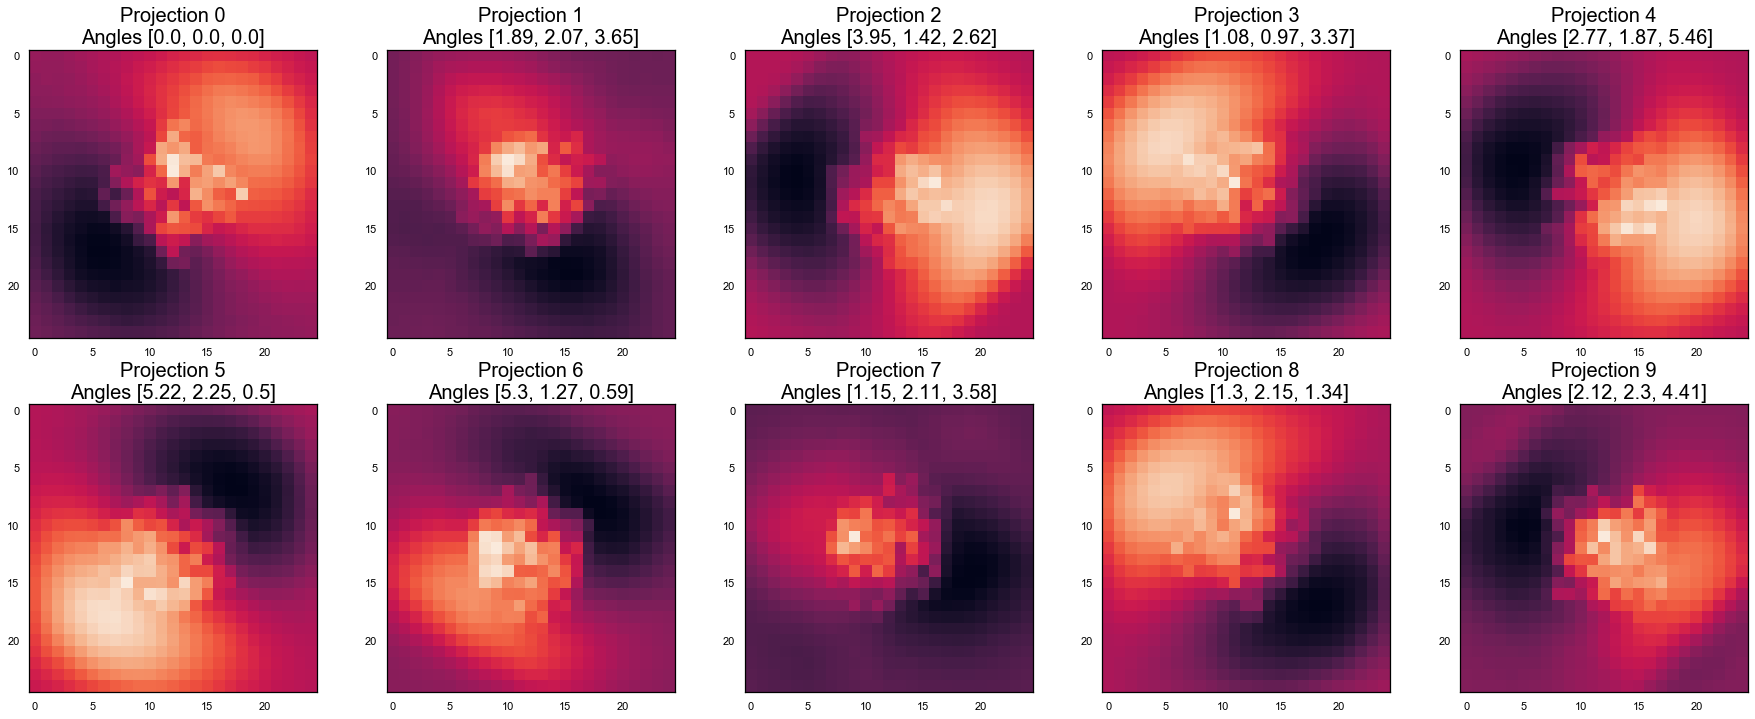

The 551-th iteration


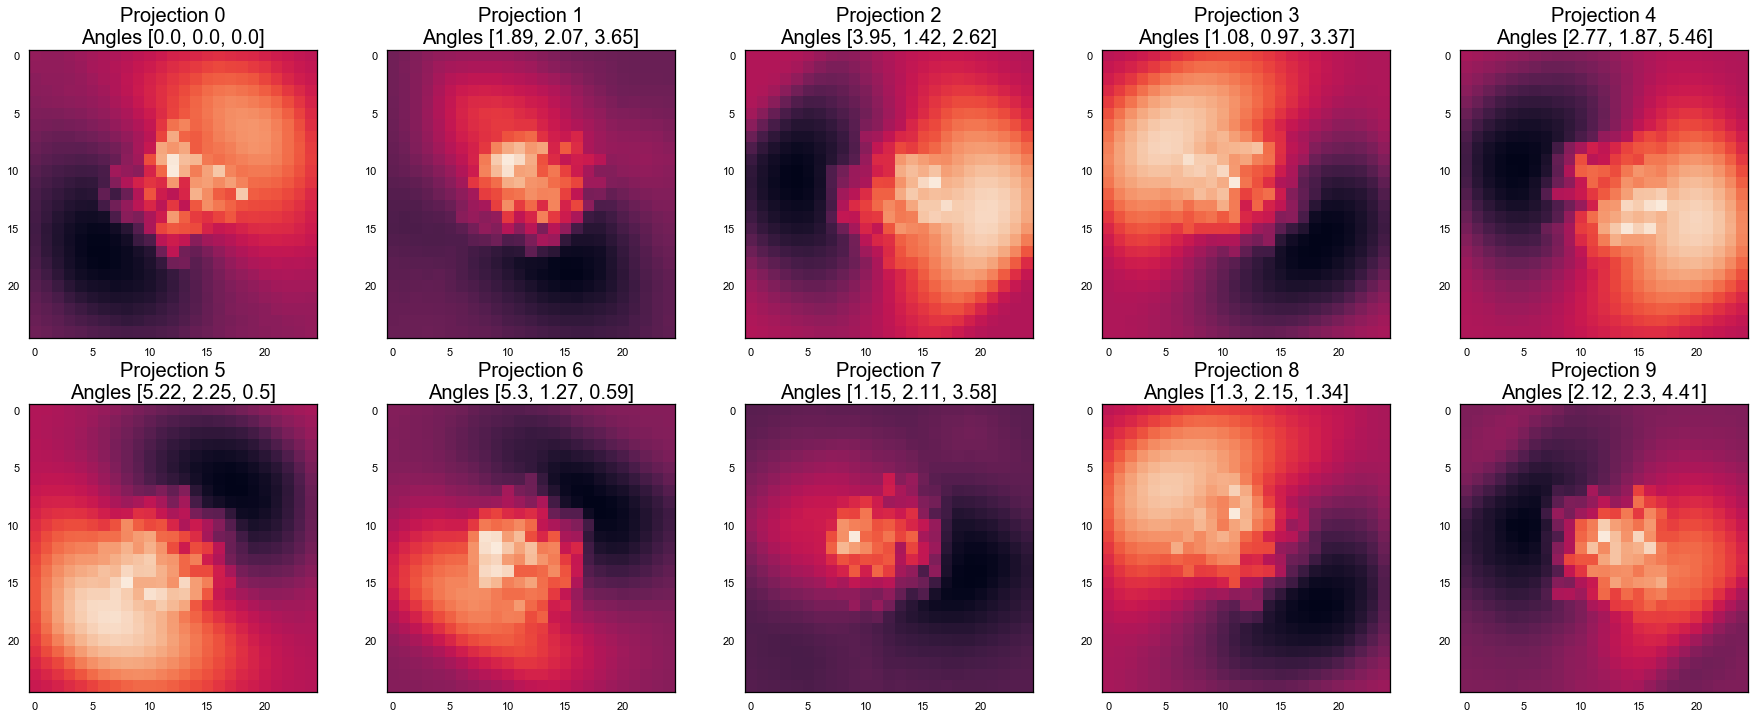

The 561-th iteration


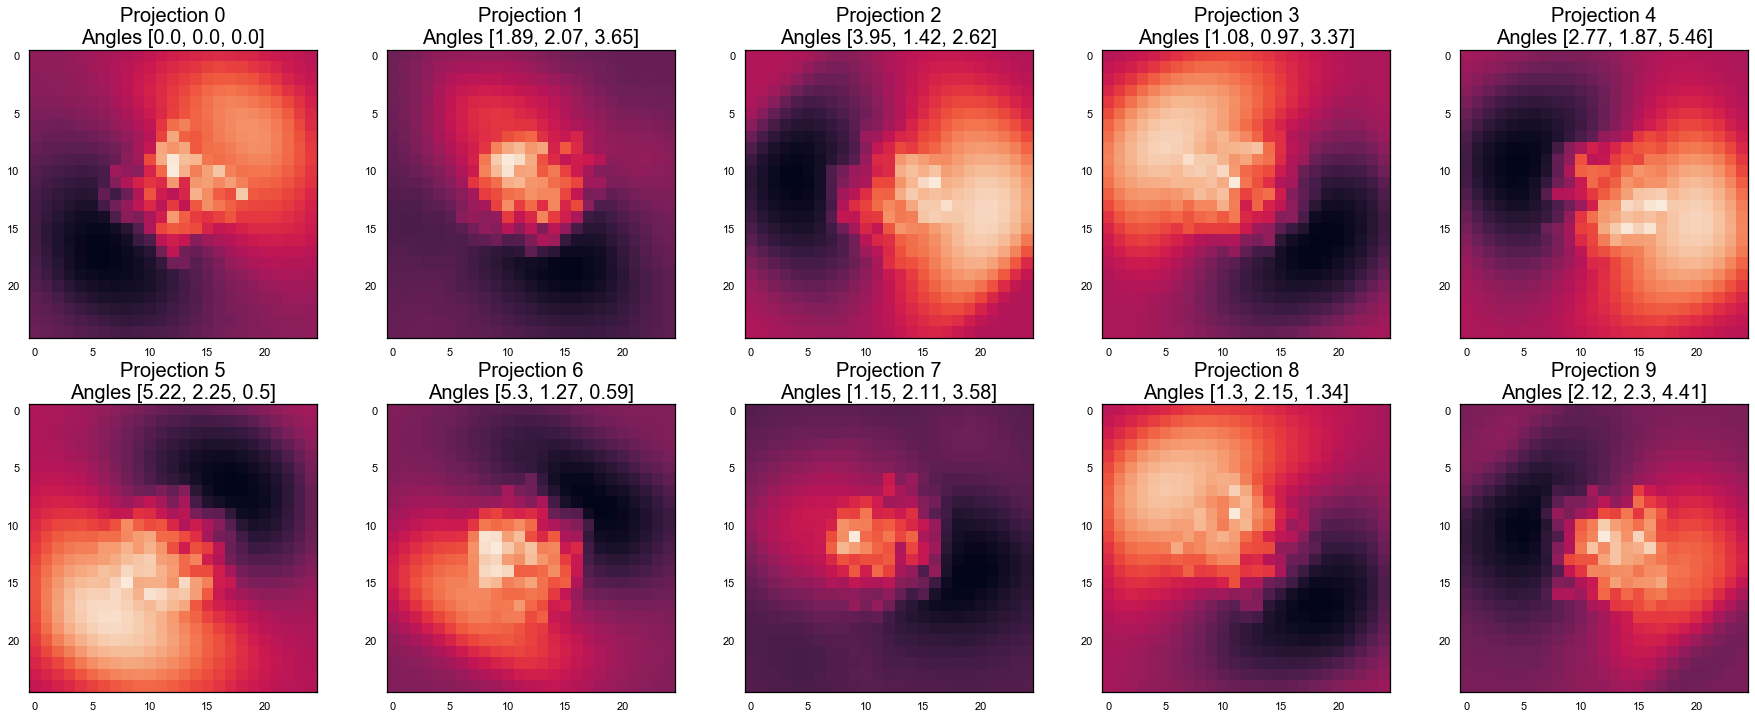

The 571-th iteration


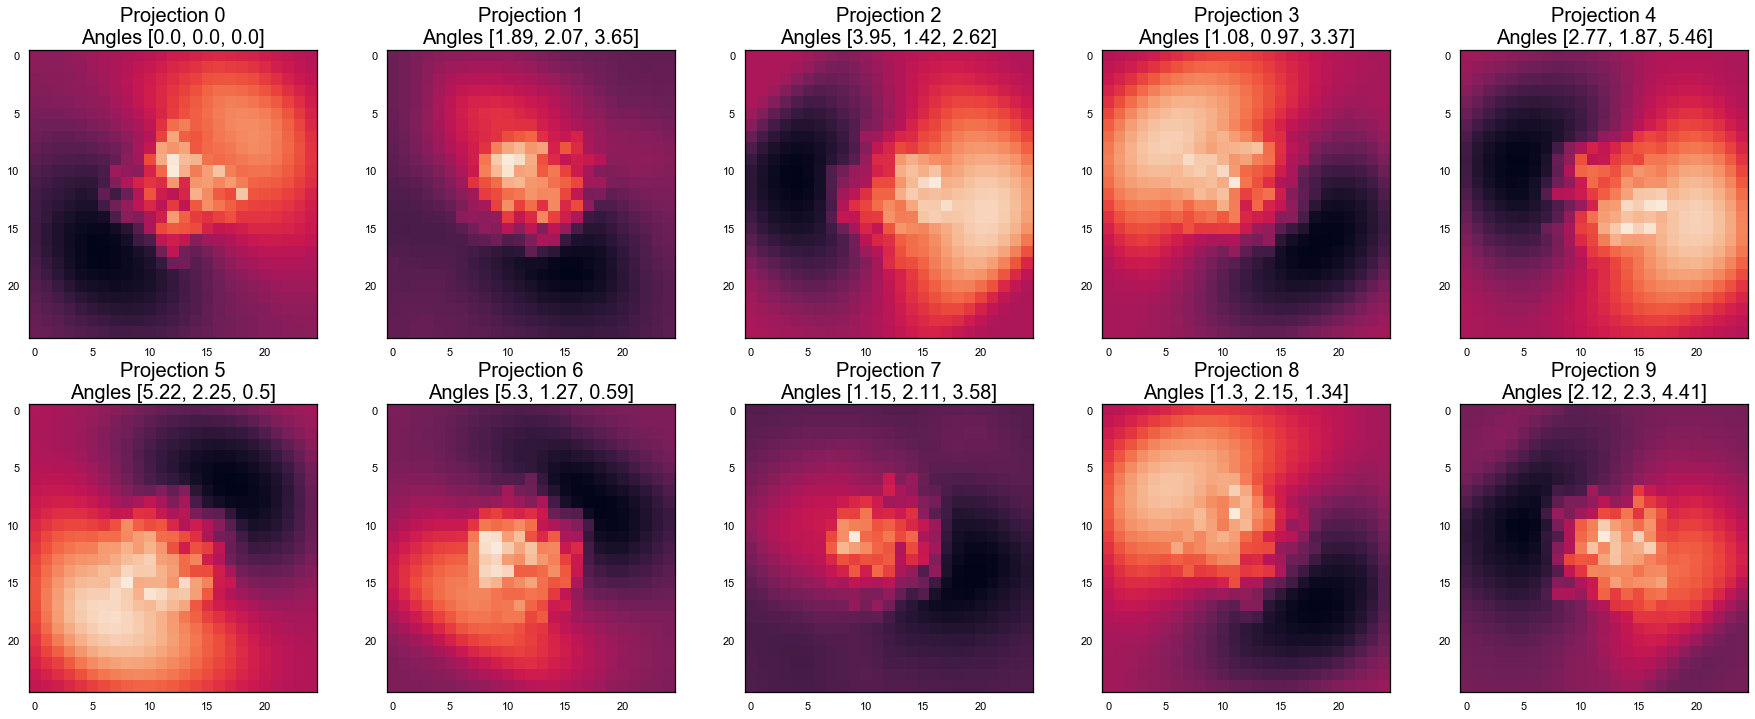

The 581-th iteration


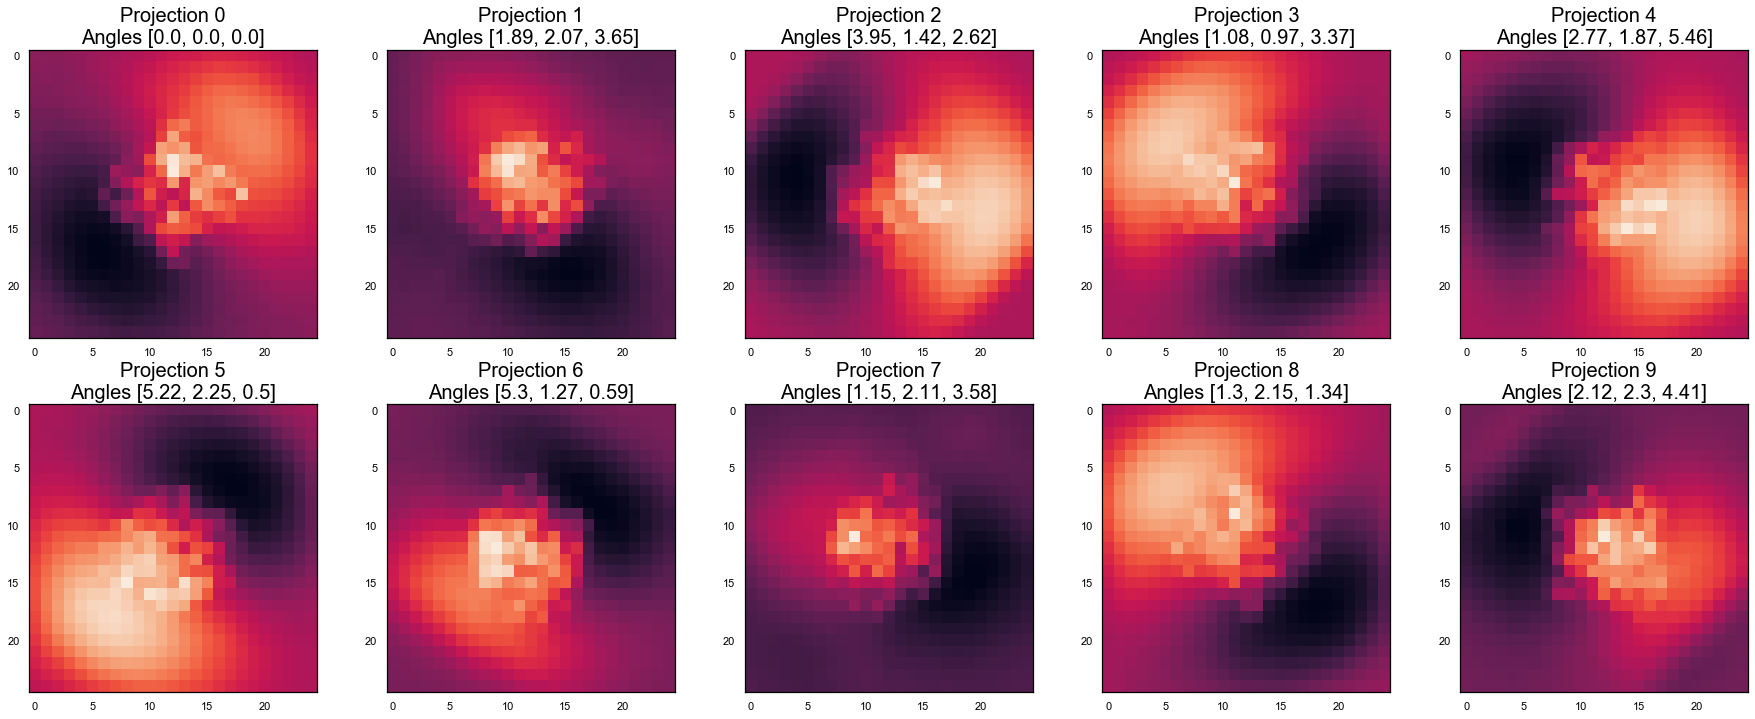

The 591-th iteration


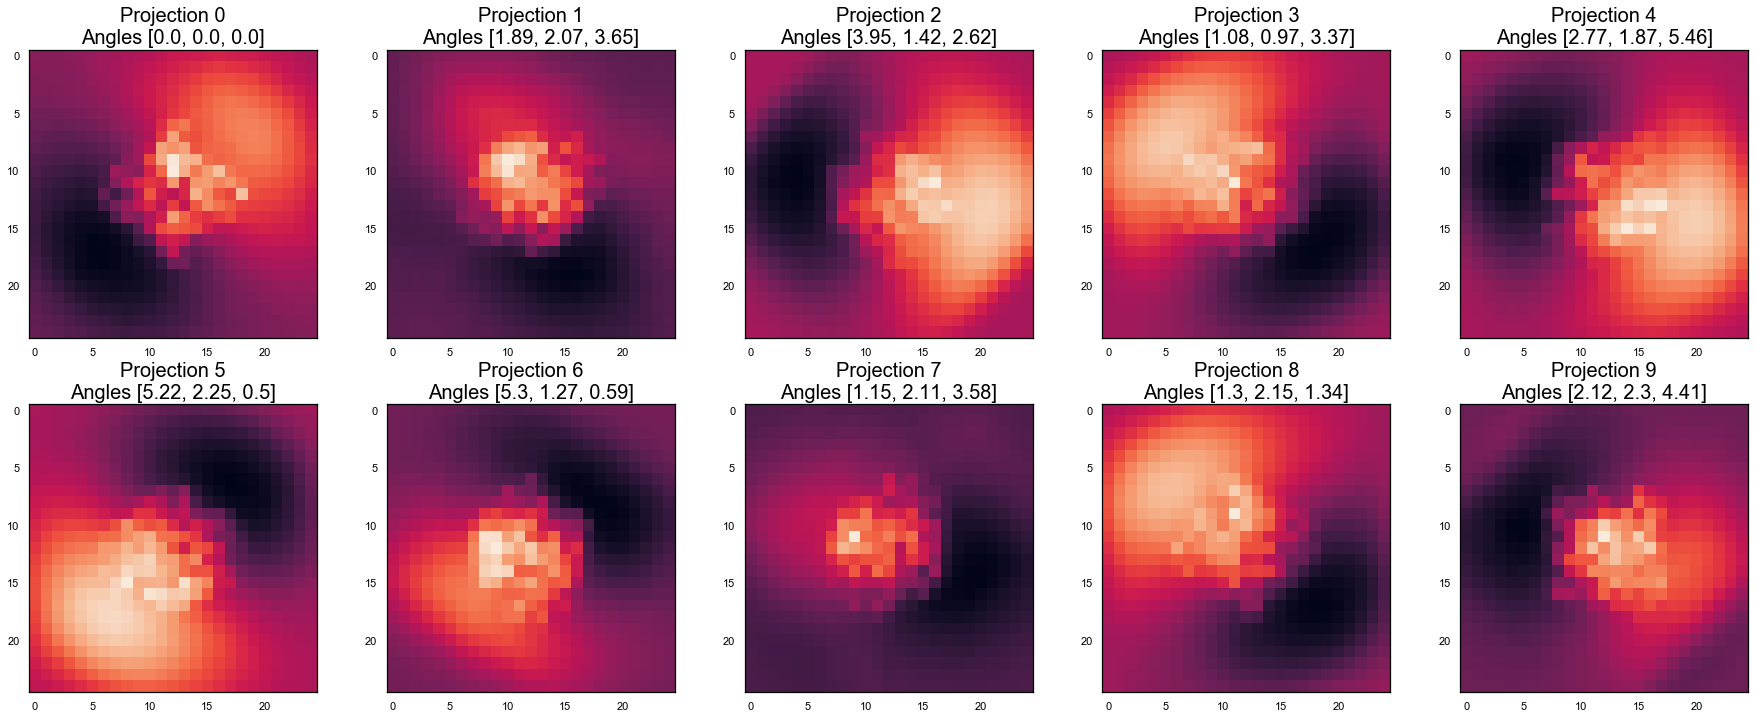

The 601-th iteration


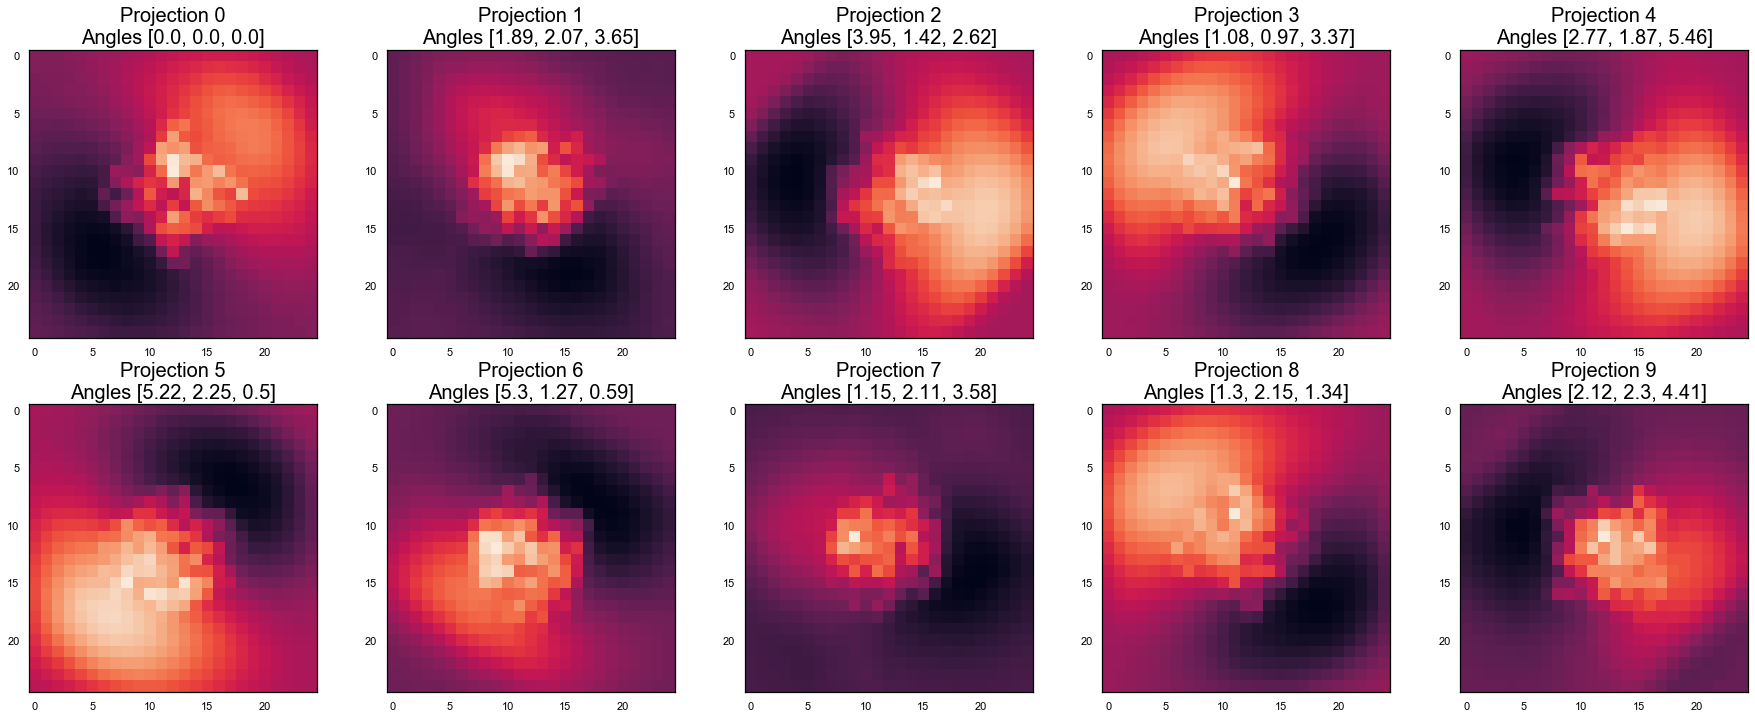

The 611-th iteration


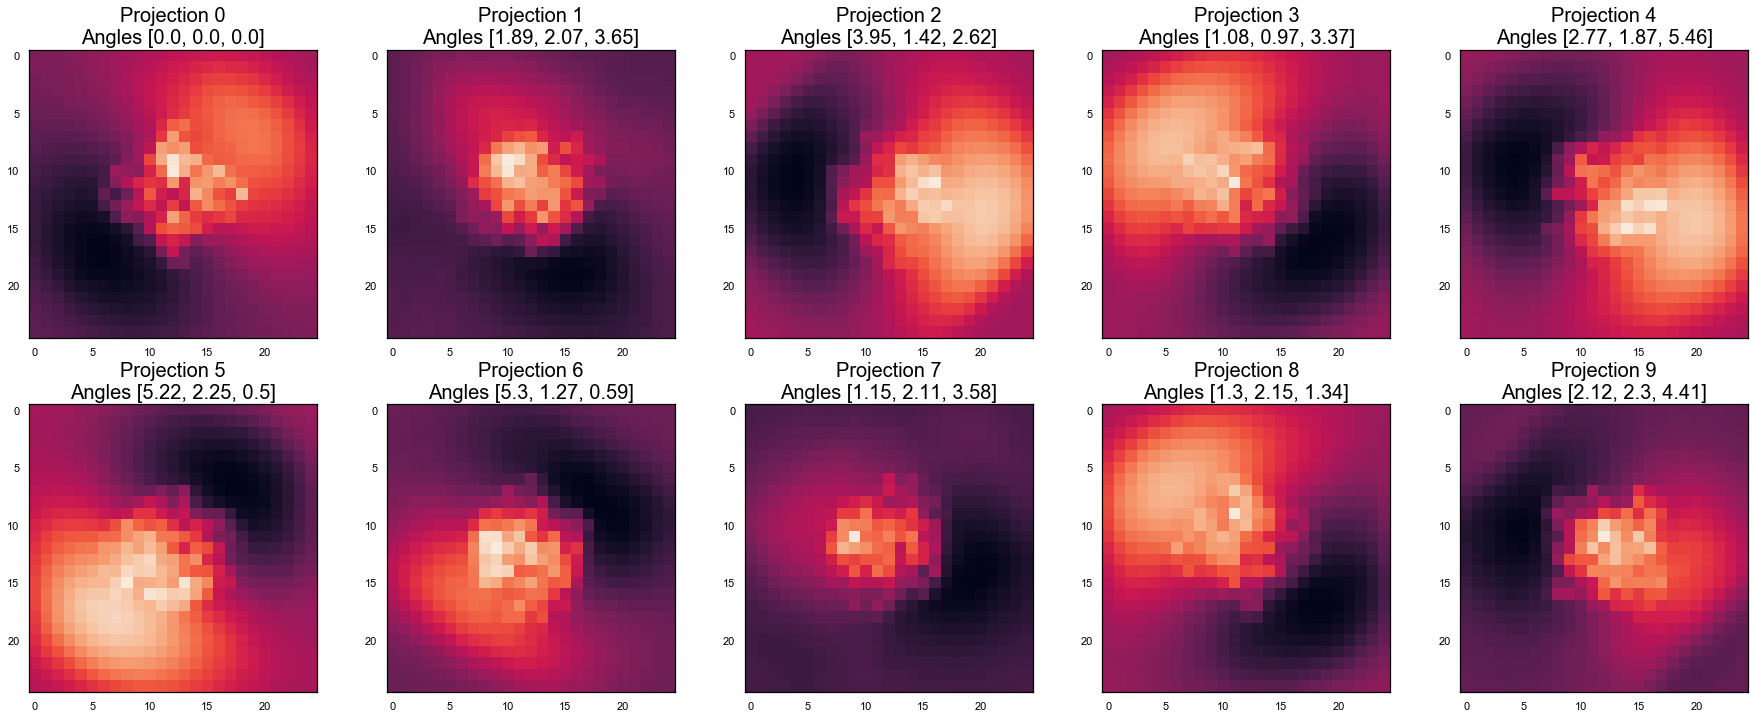

The 621-th iteration


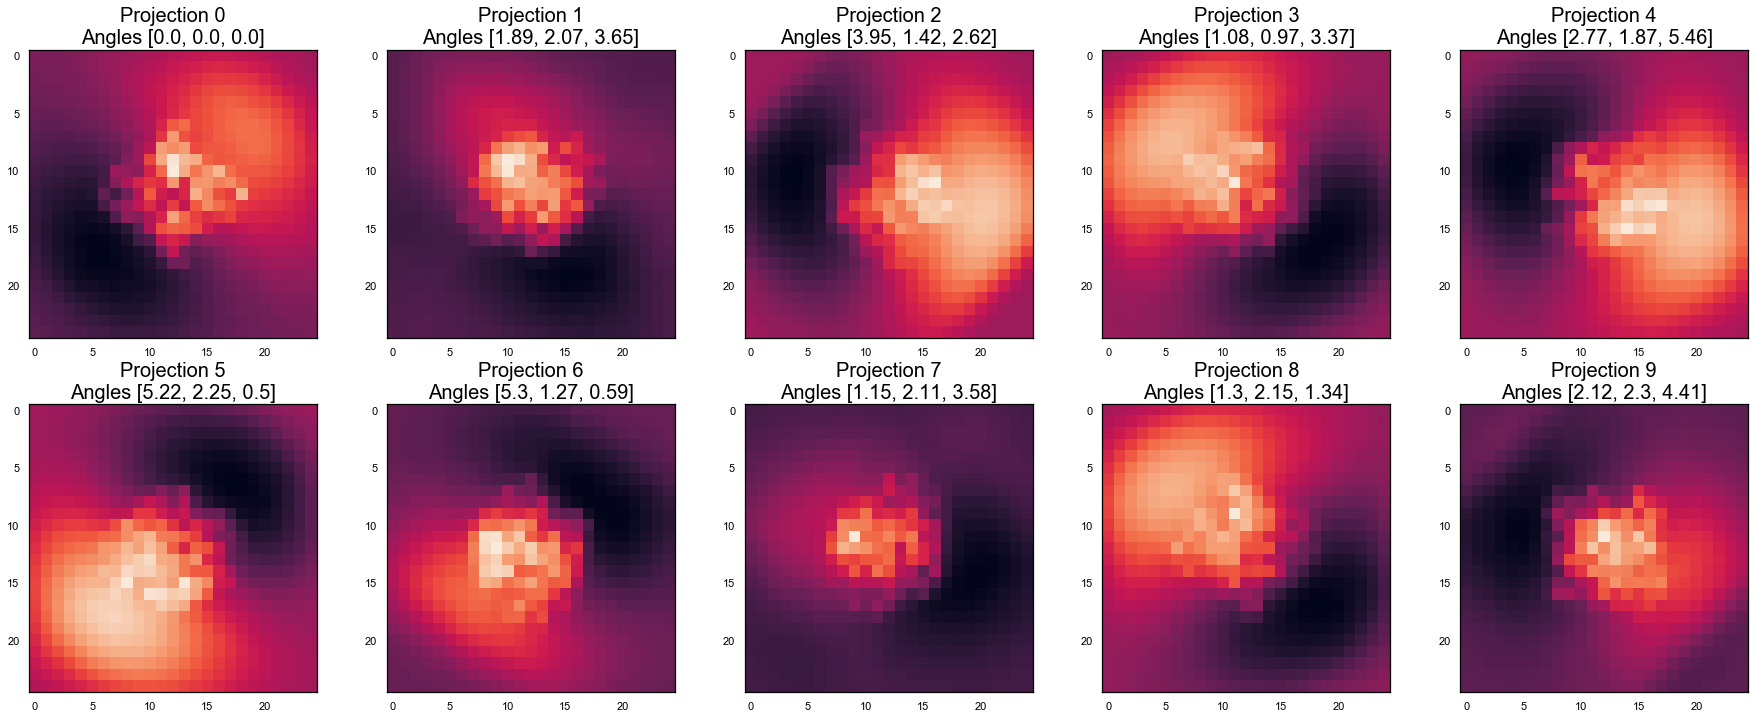

The 631-th iteration


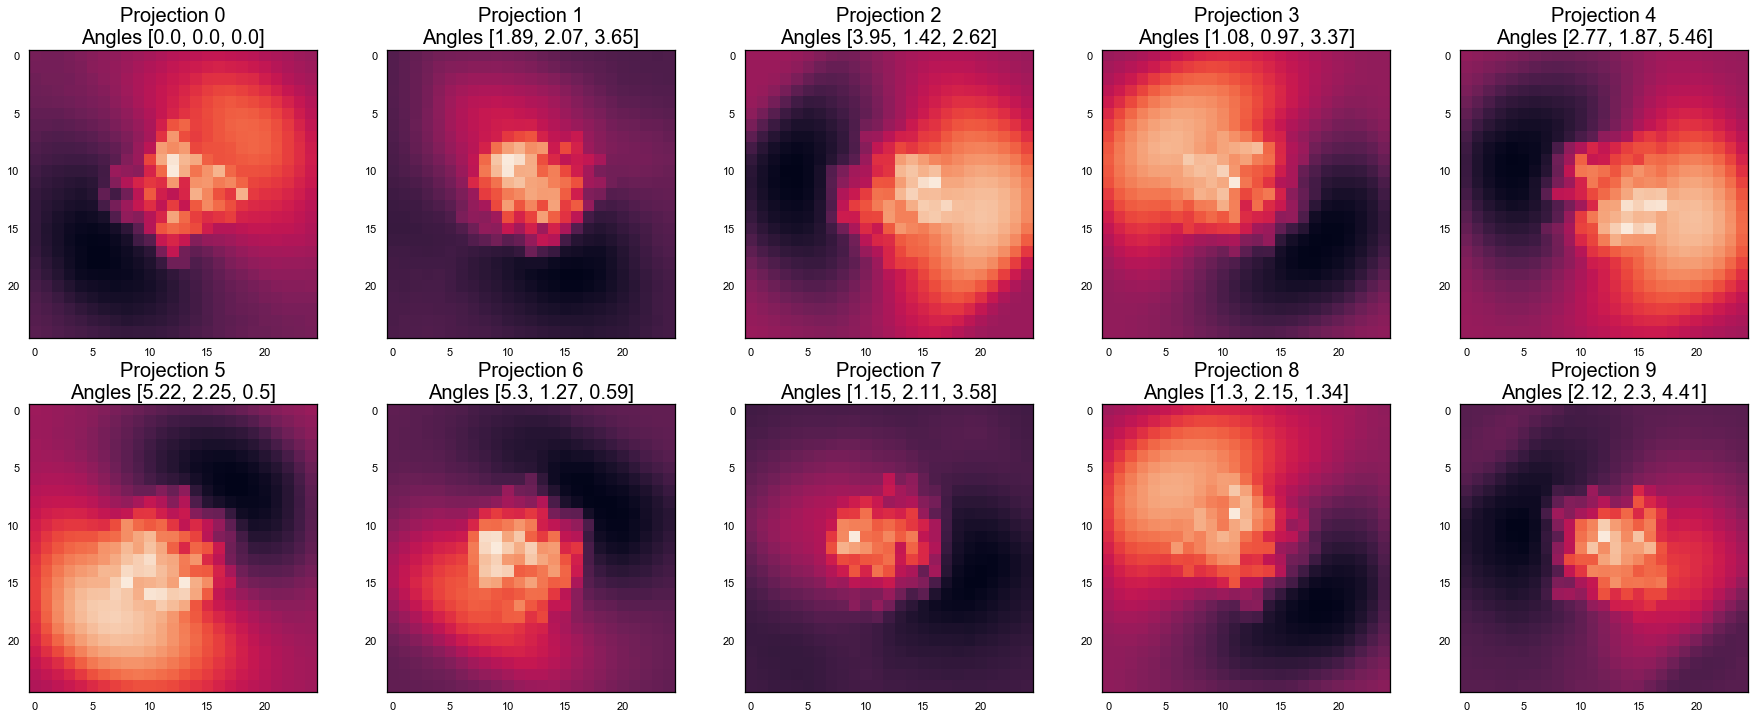

The 641-th iteration


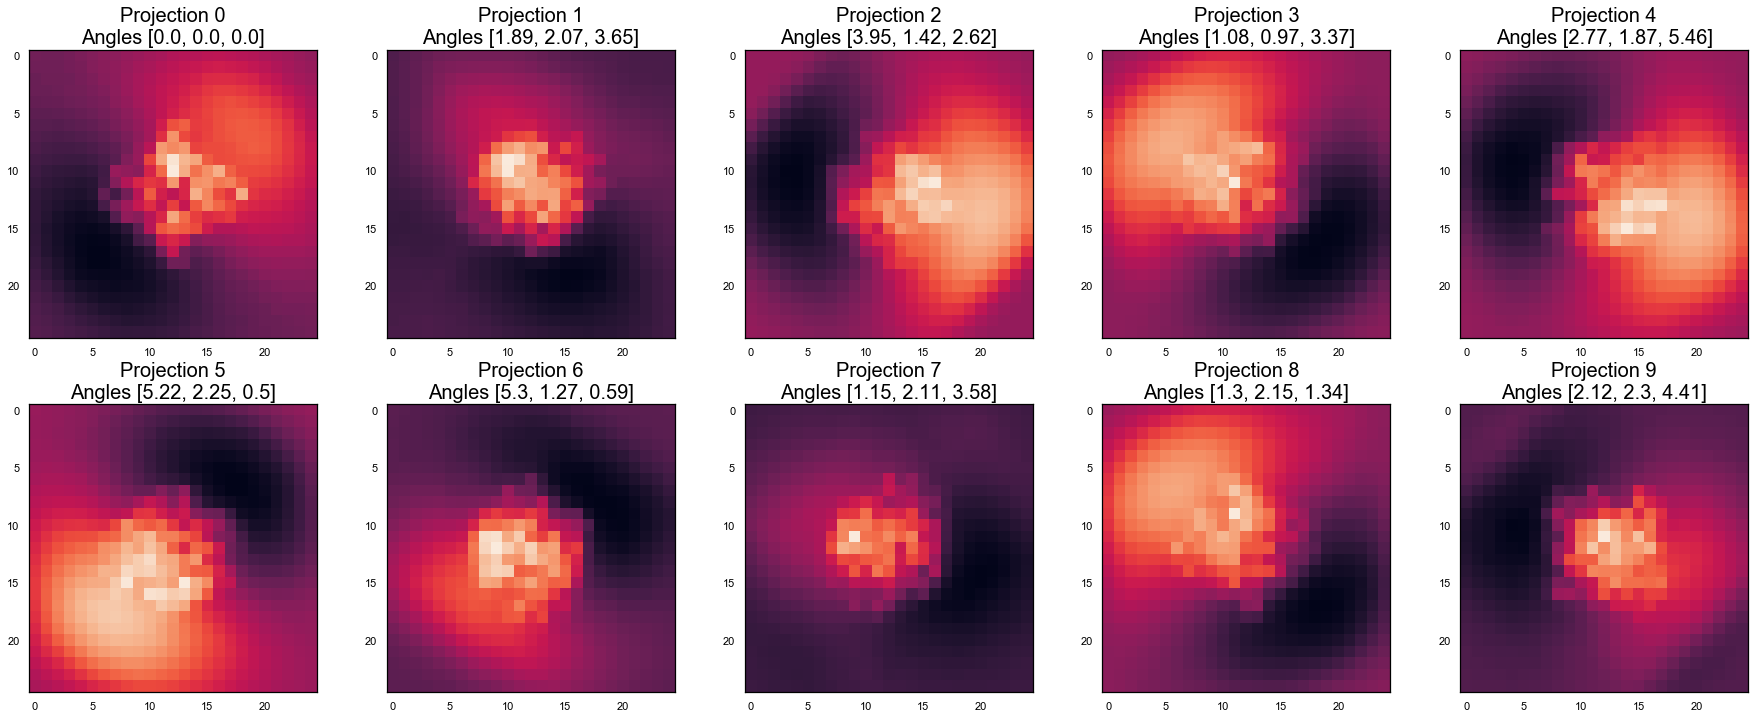

The 651-th iteration


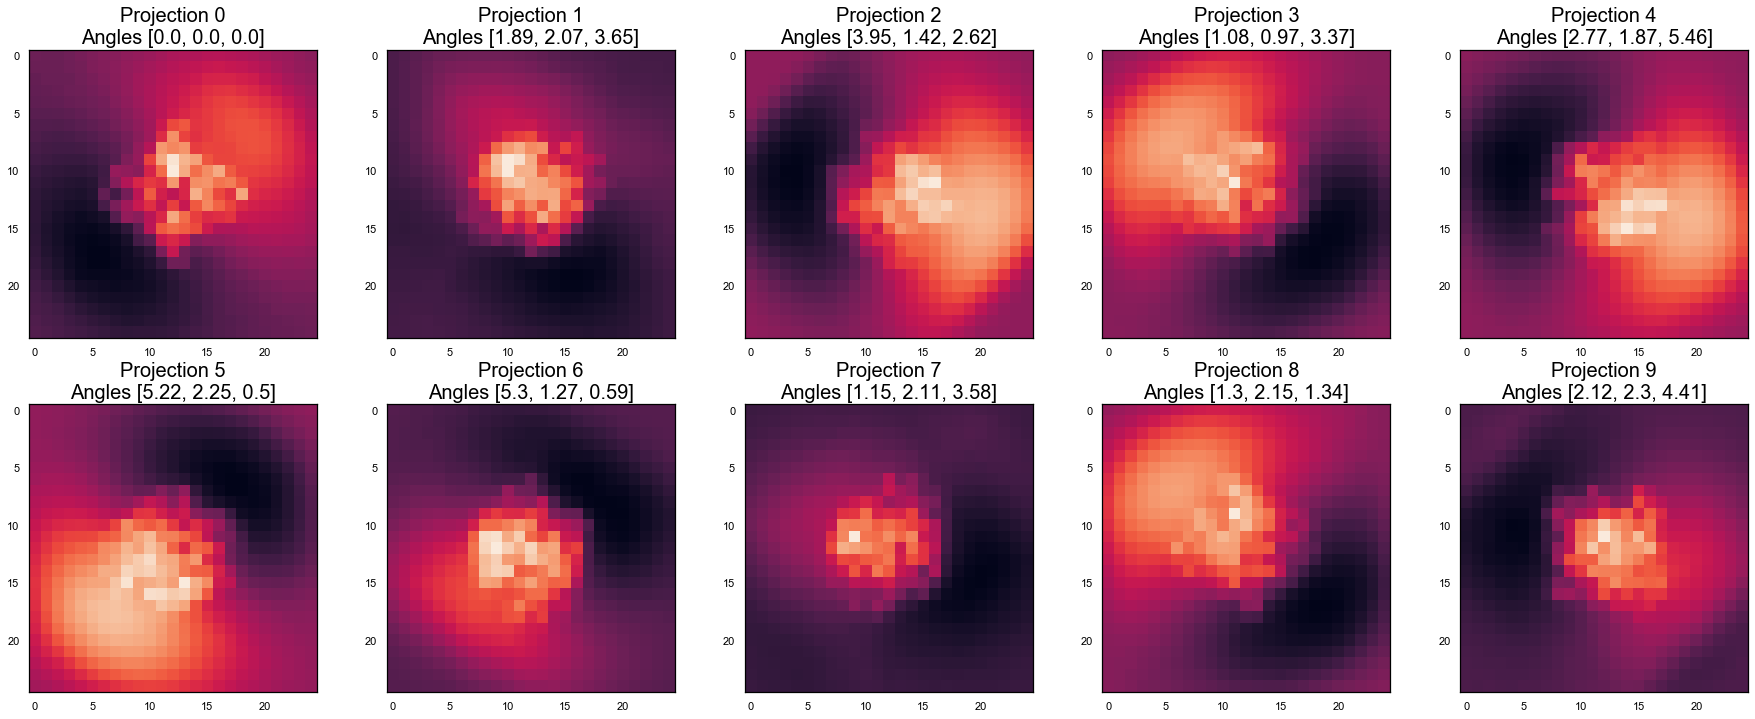

The 661-th iteration


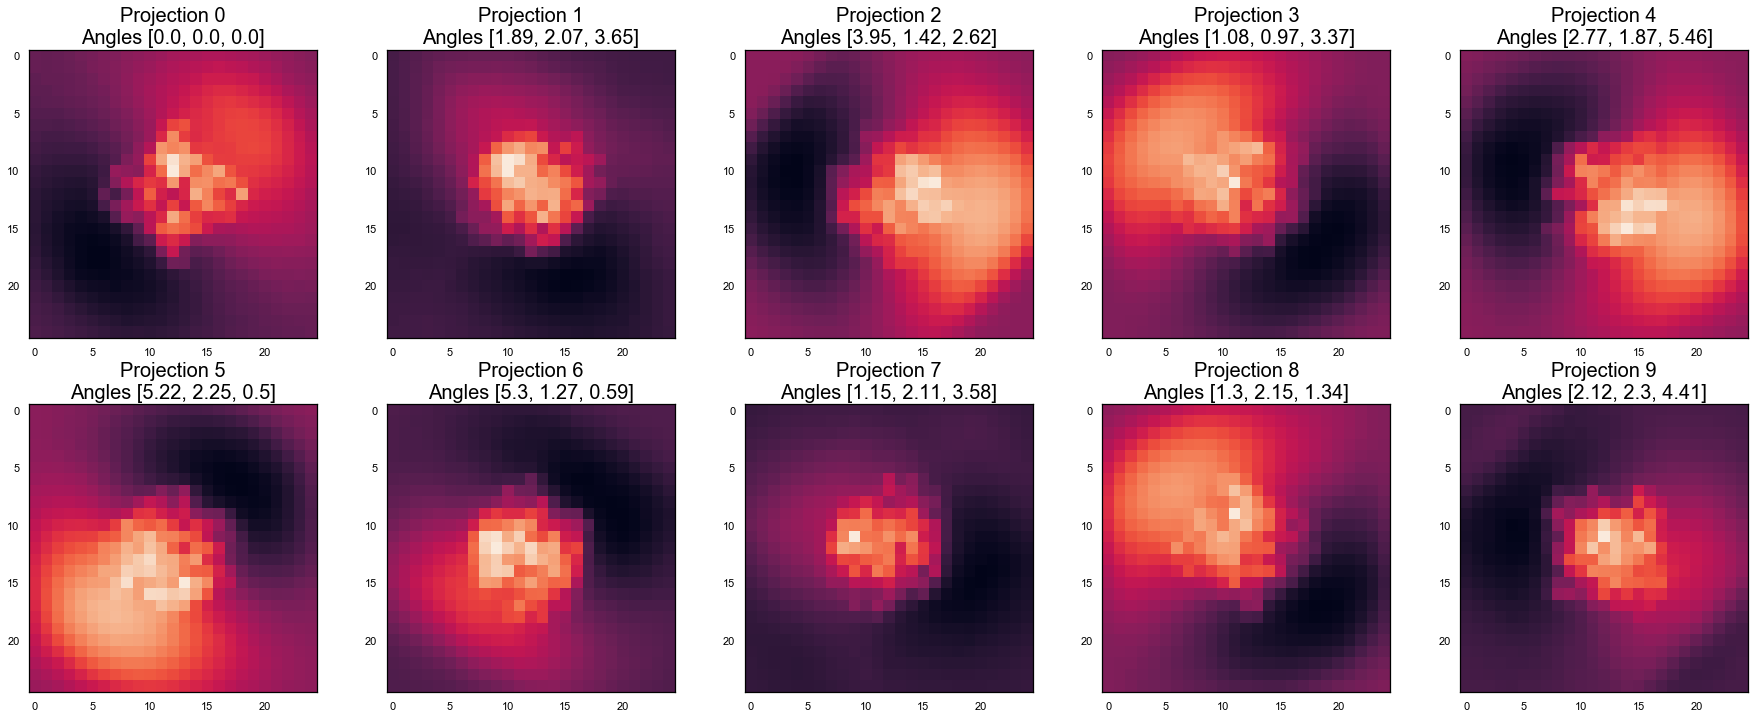

The 671-th iteration


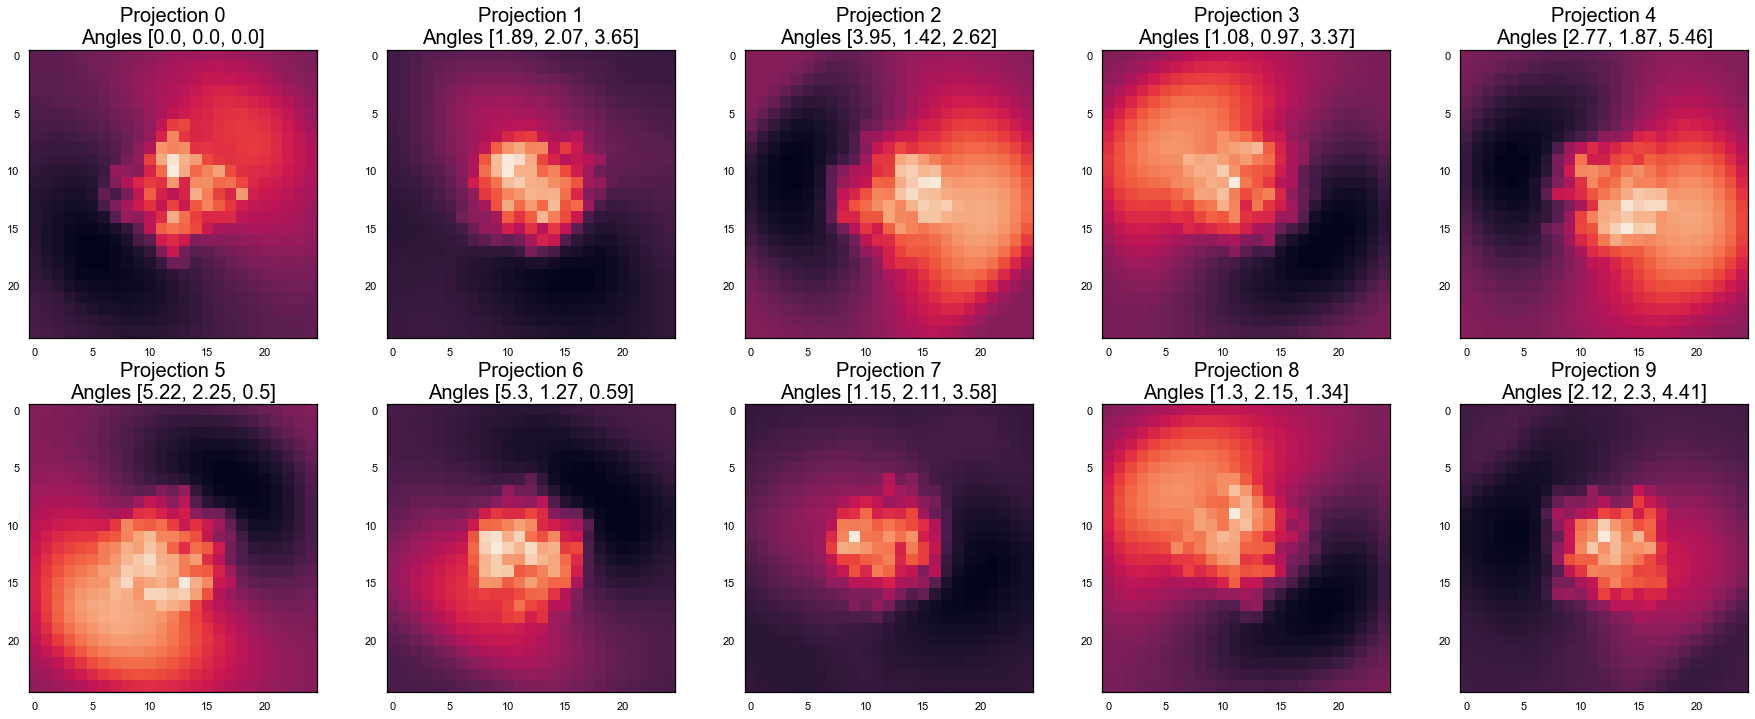

The 681-th iteration


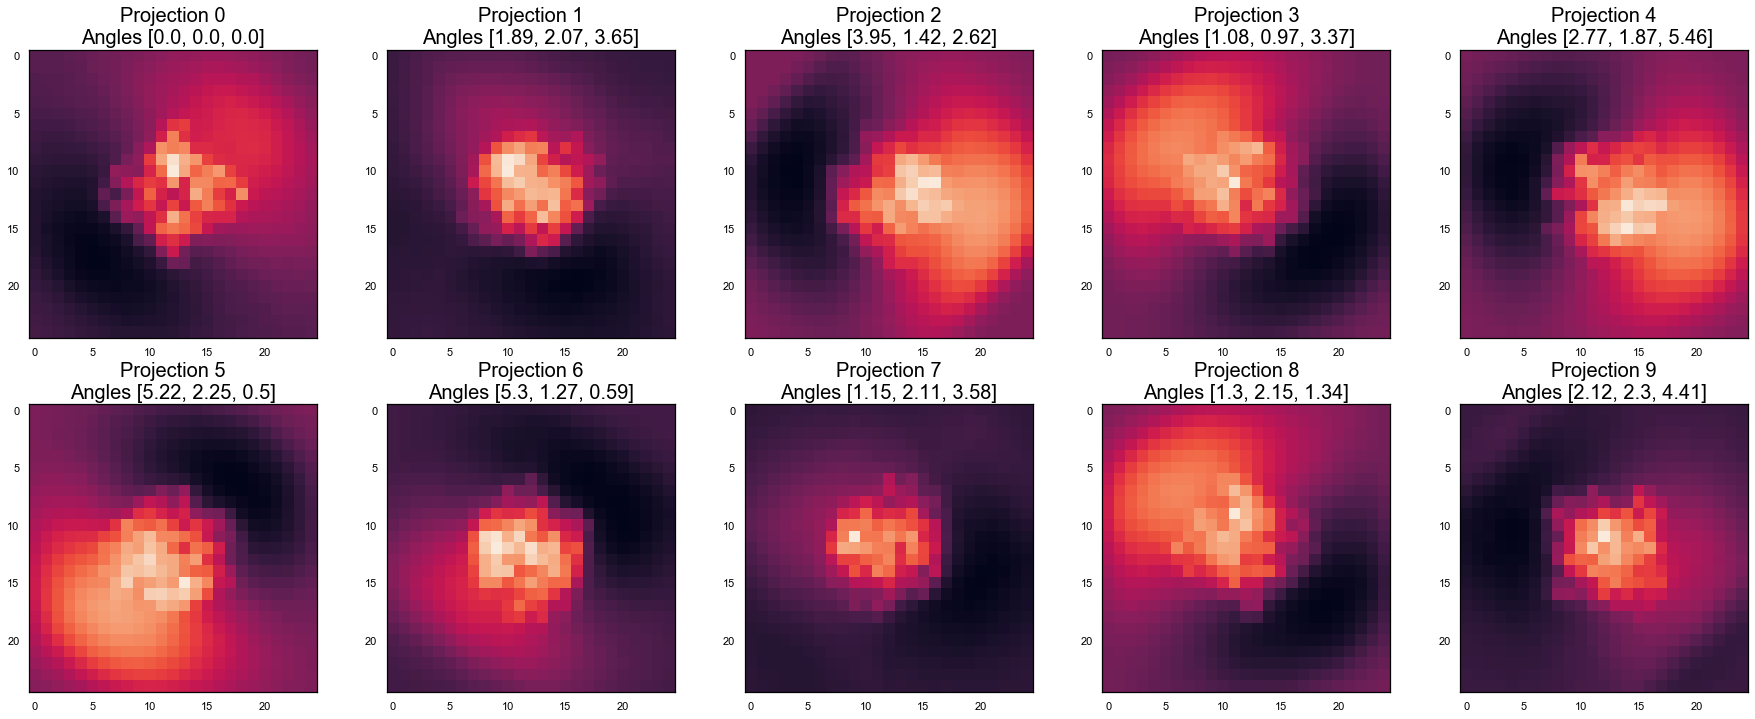

The 691-th iteration


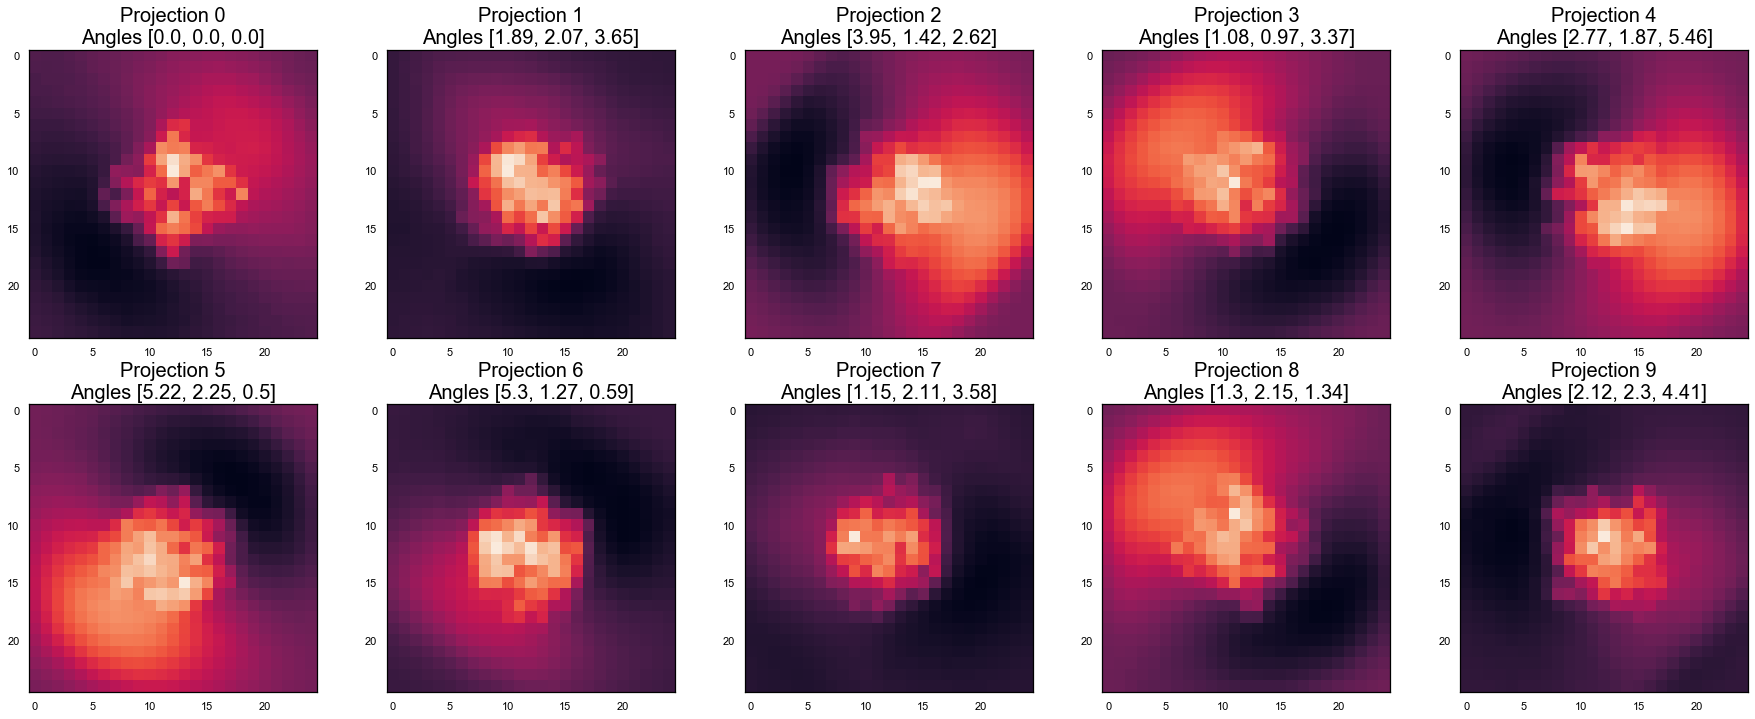

The 701-th iteration


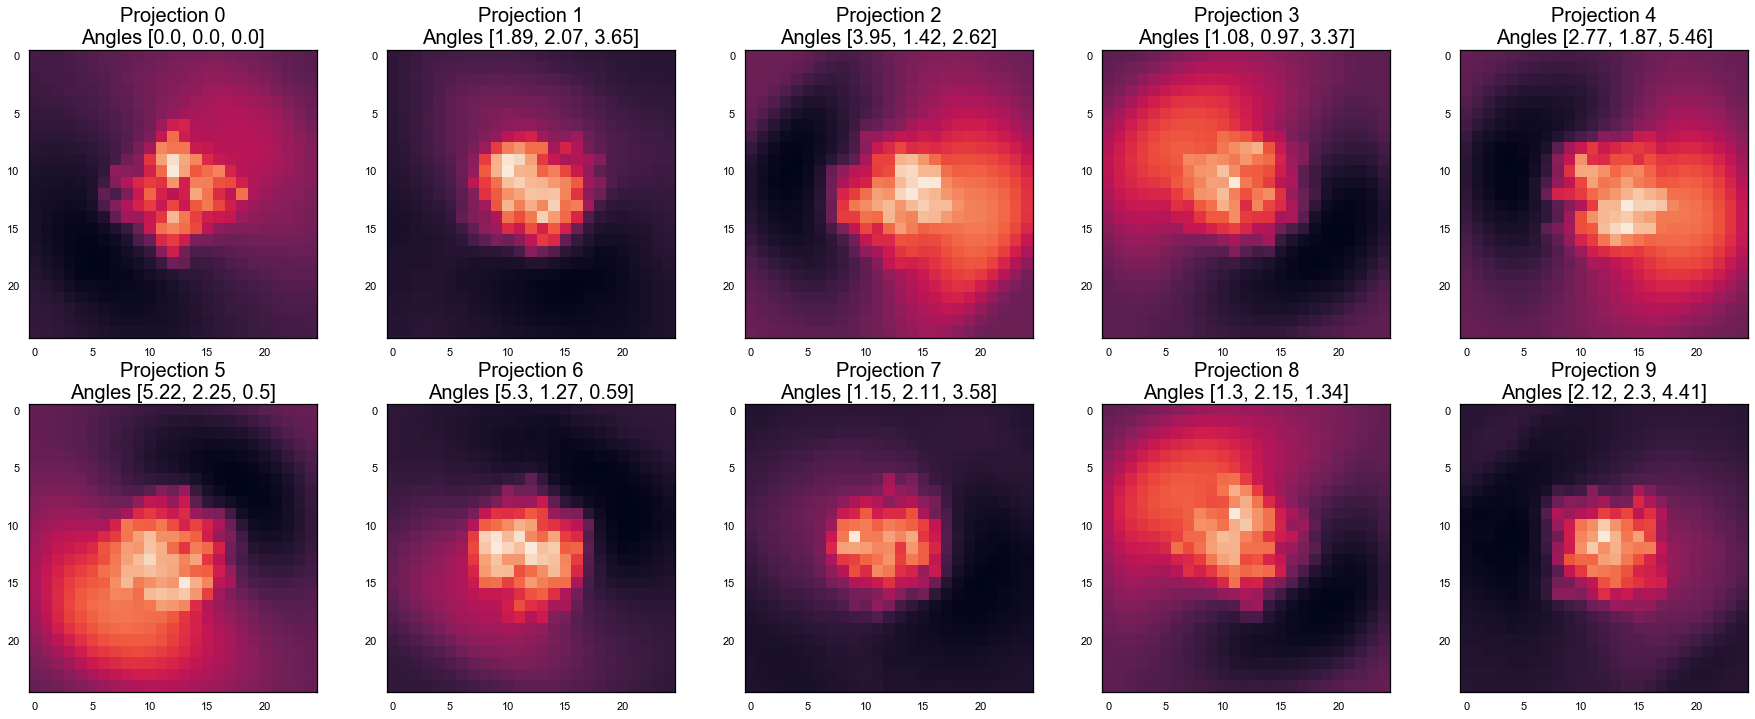

The 711-th iteration


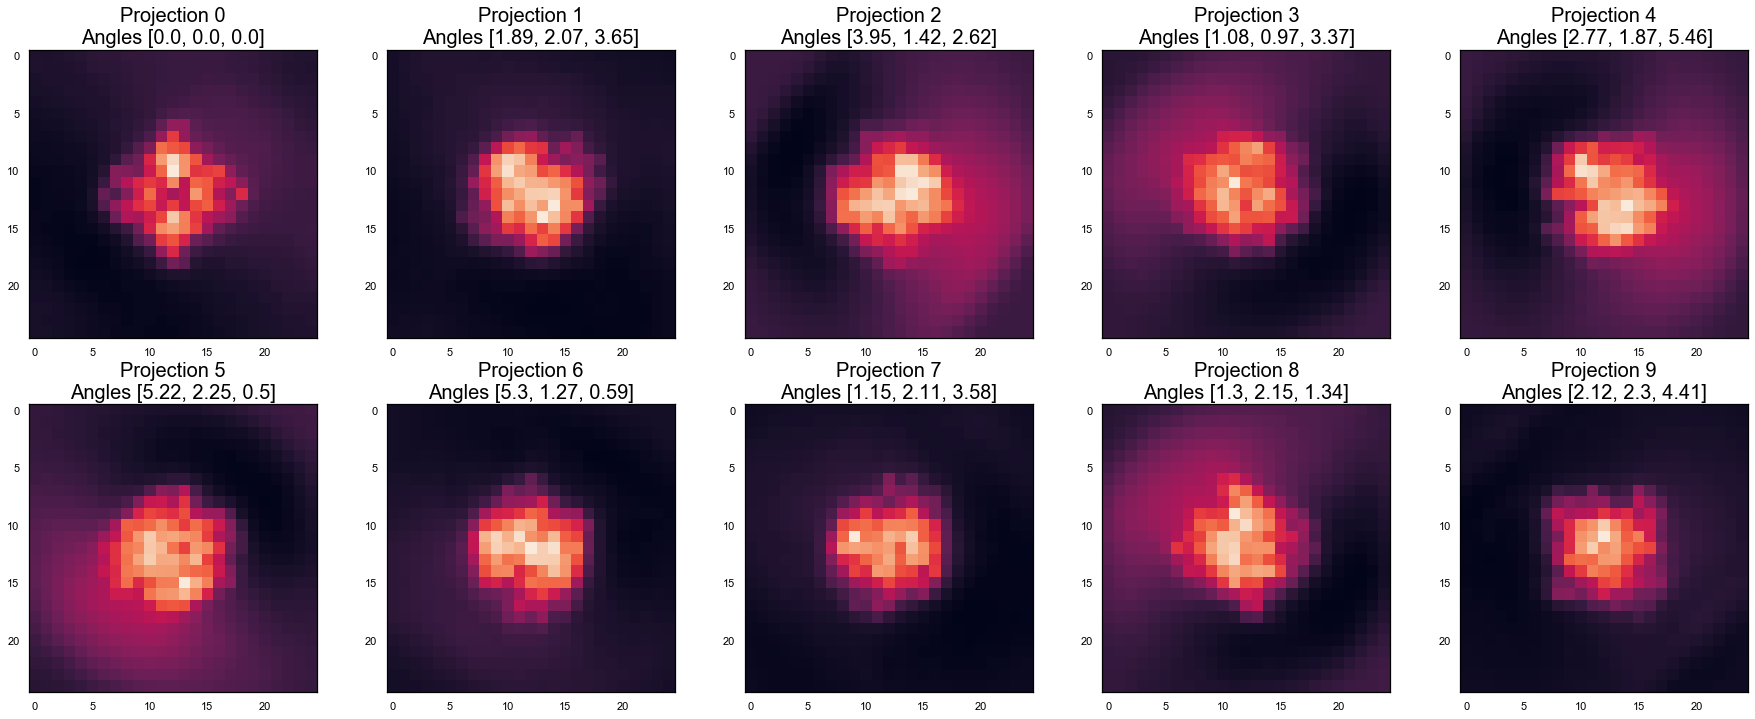

The 721-th iteration


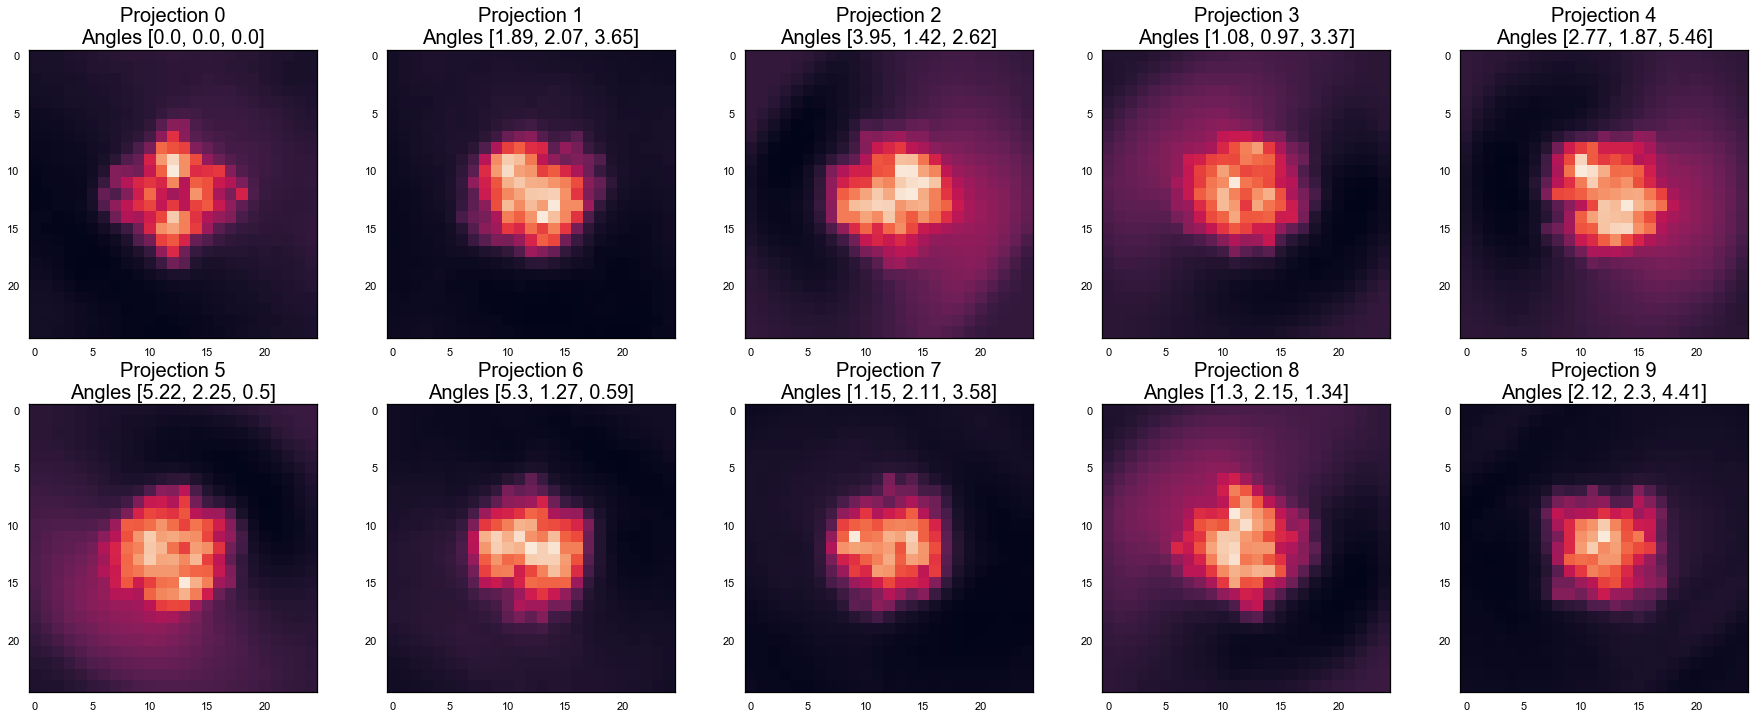

The 731-th iteration


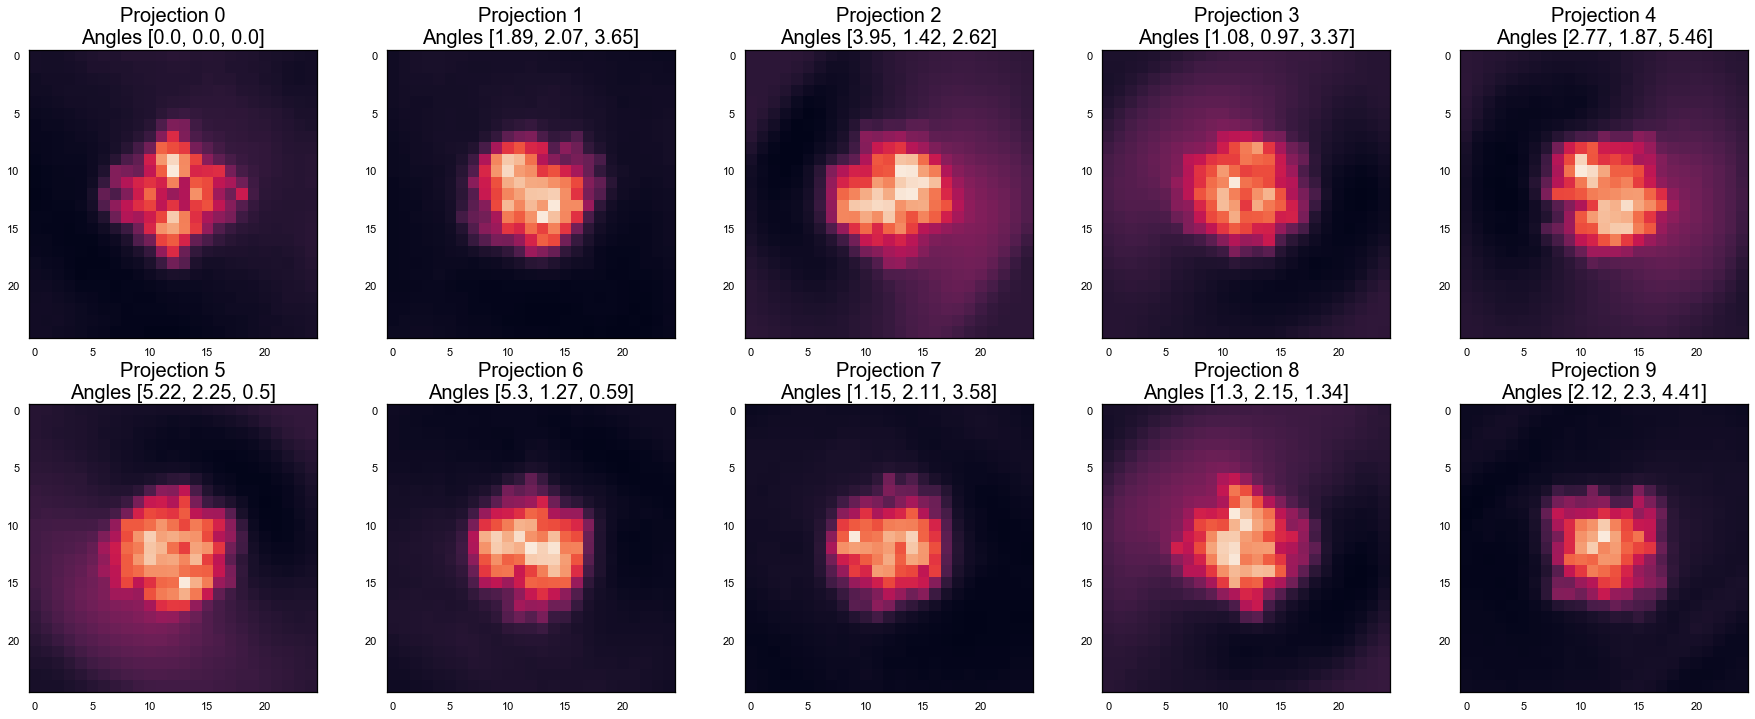

The 741-th iteration


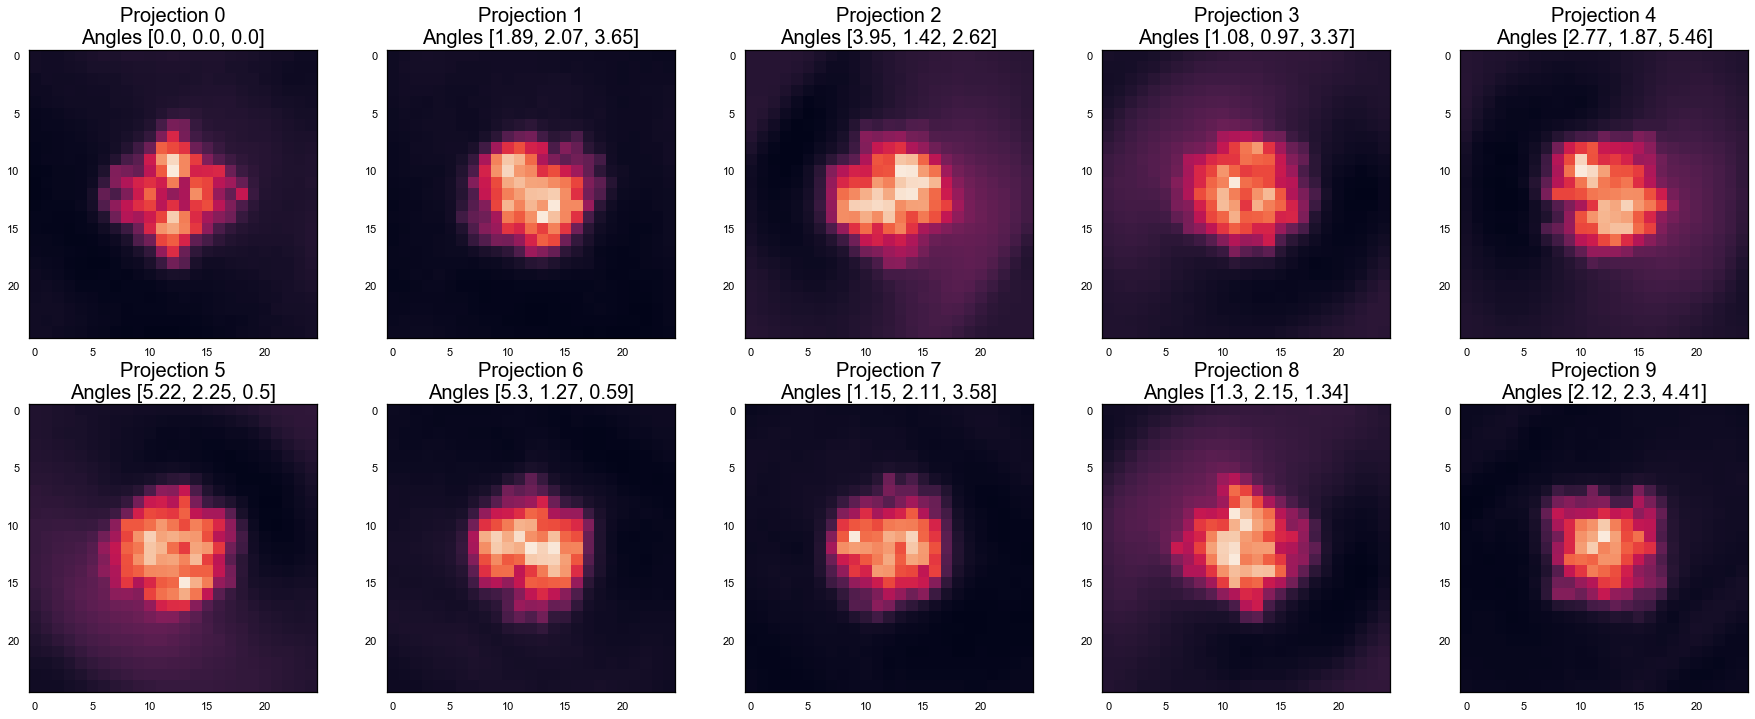

The 751-th iteration


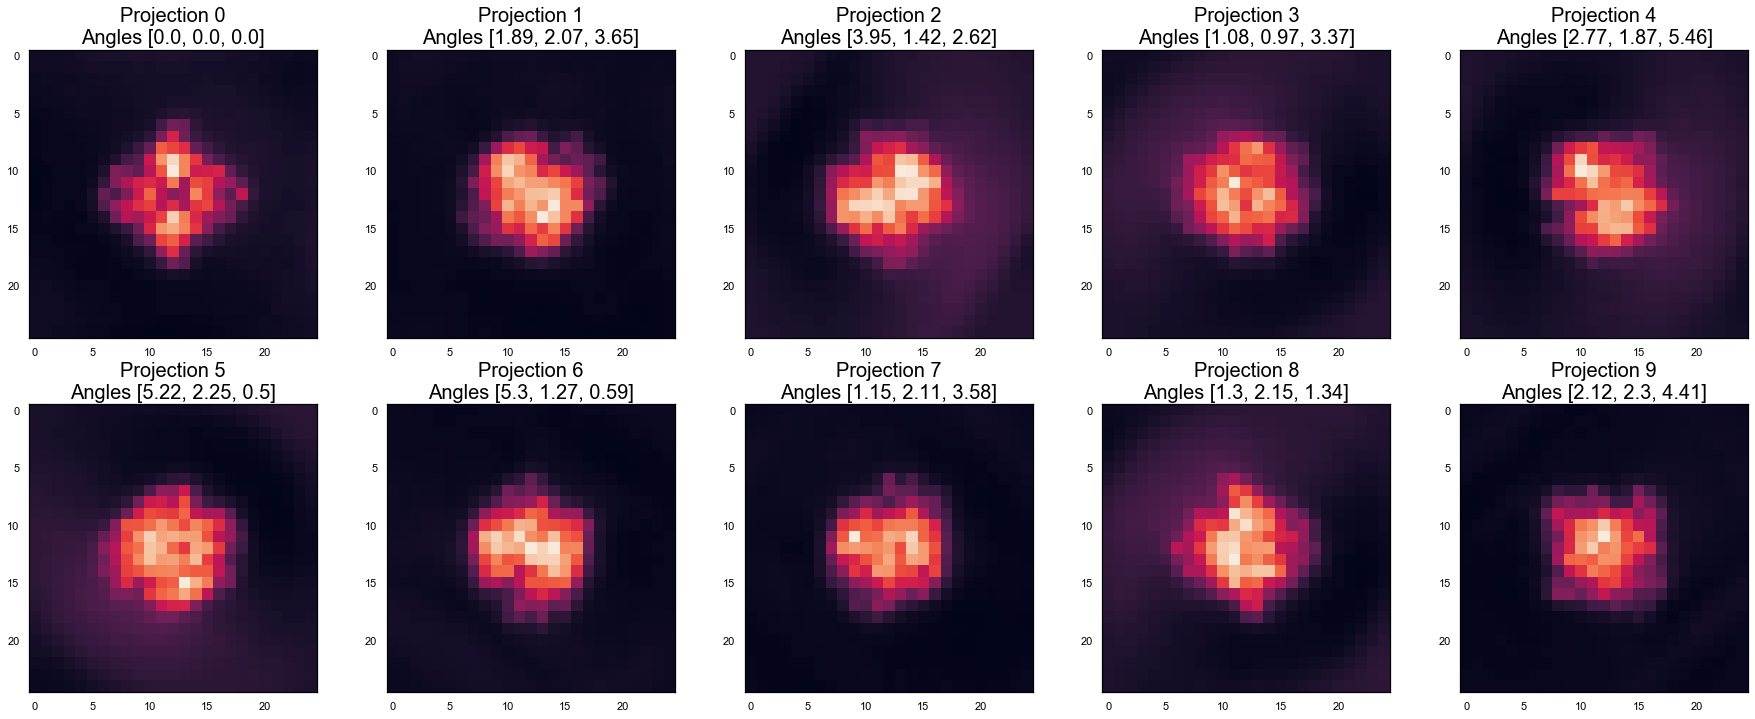

The 761-th iteration


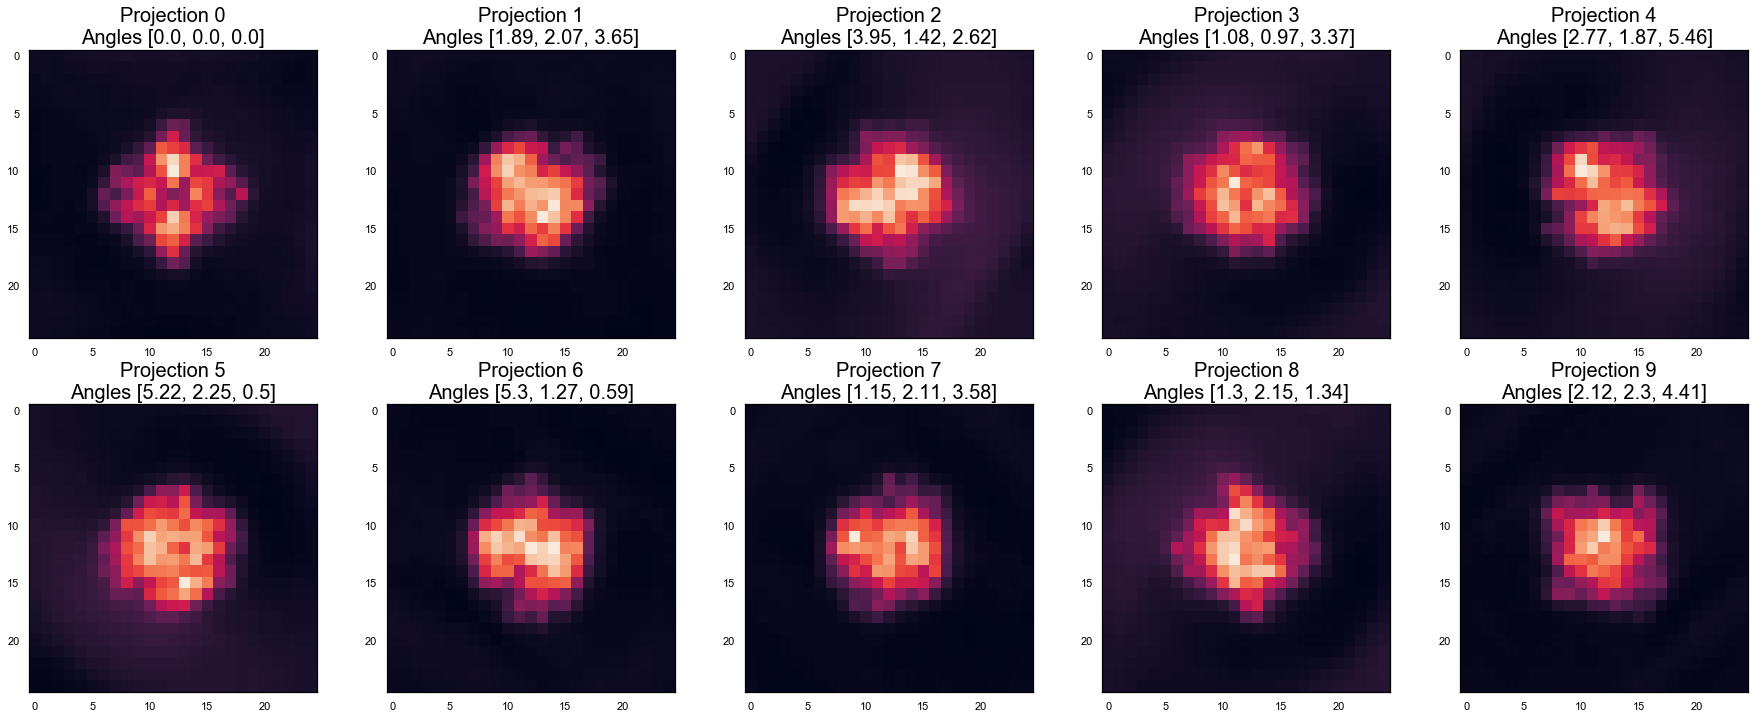

The 771-th iteration


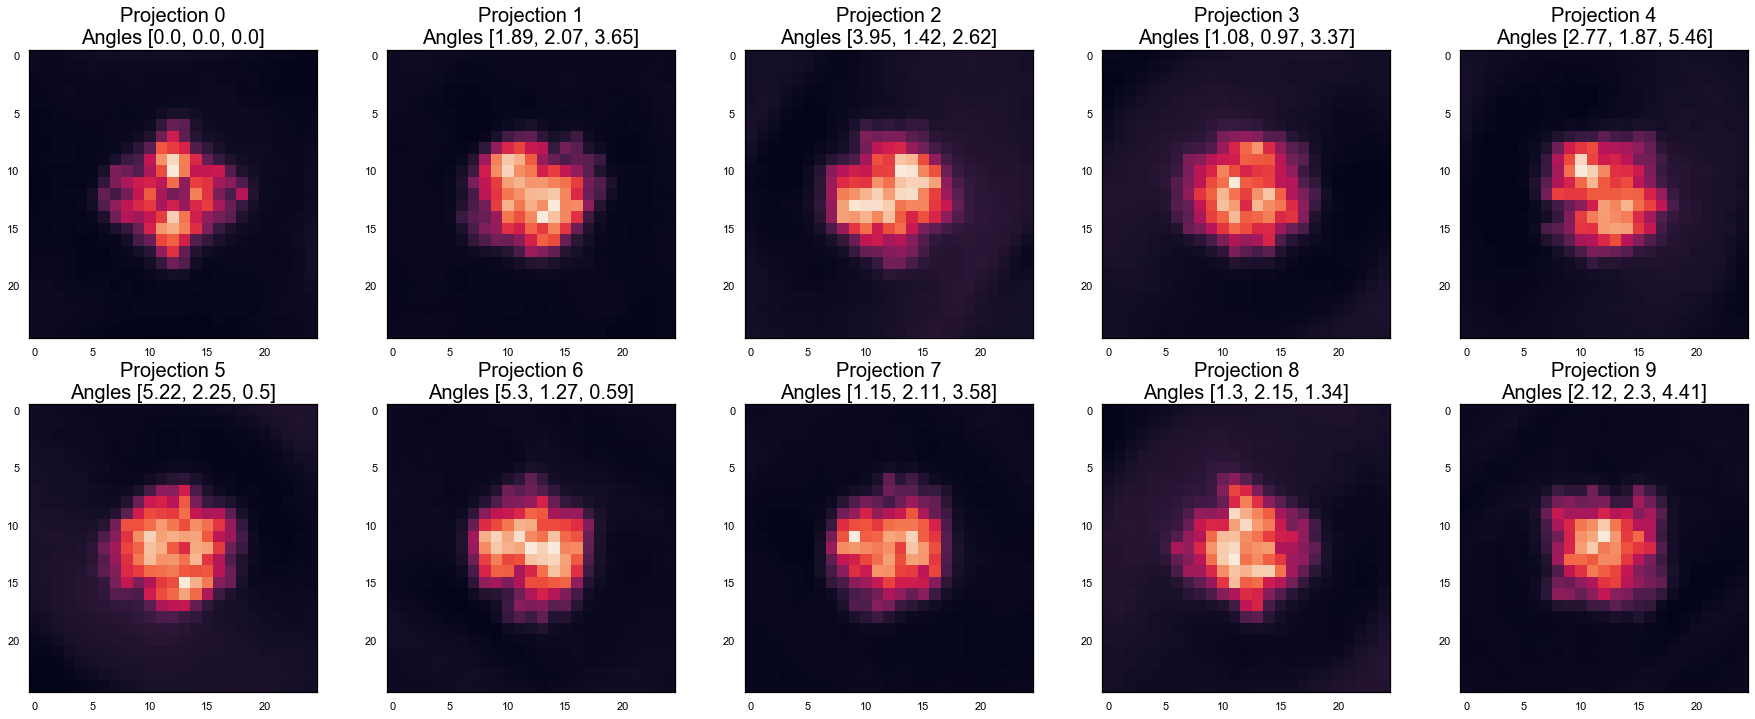

The 781-th iteration


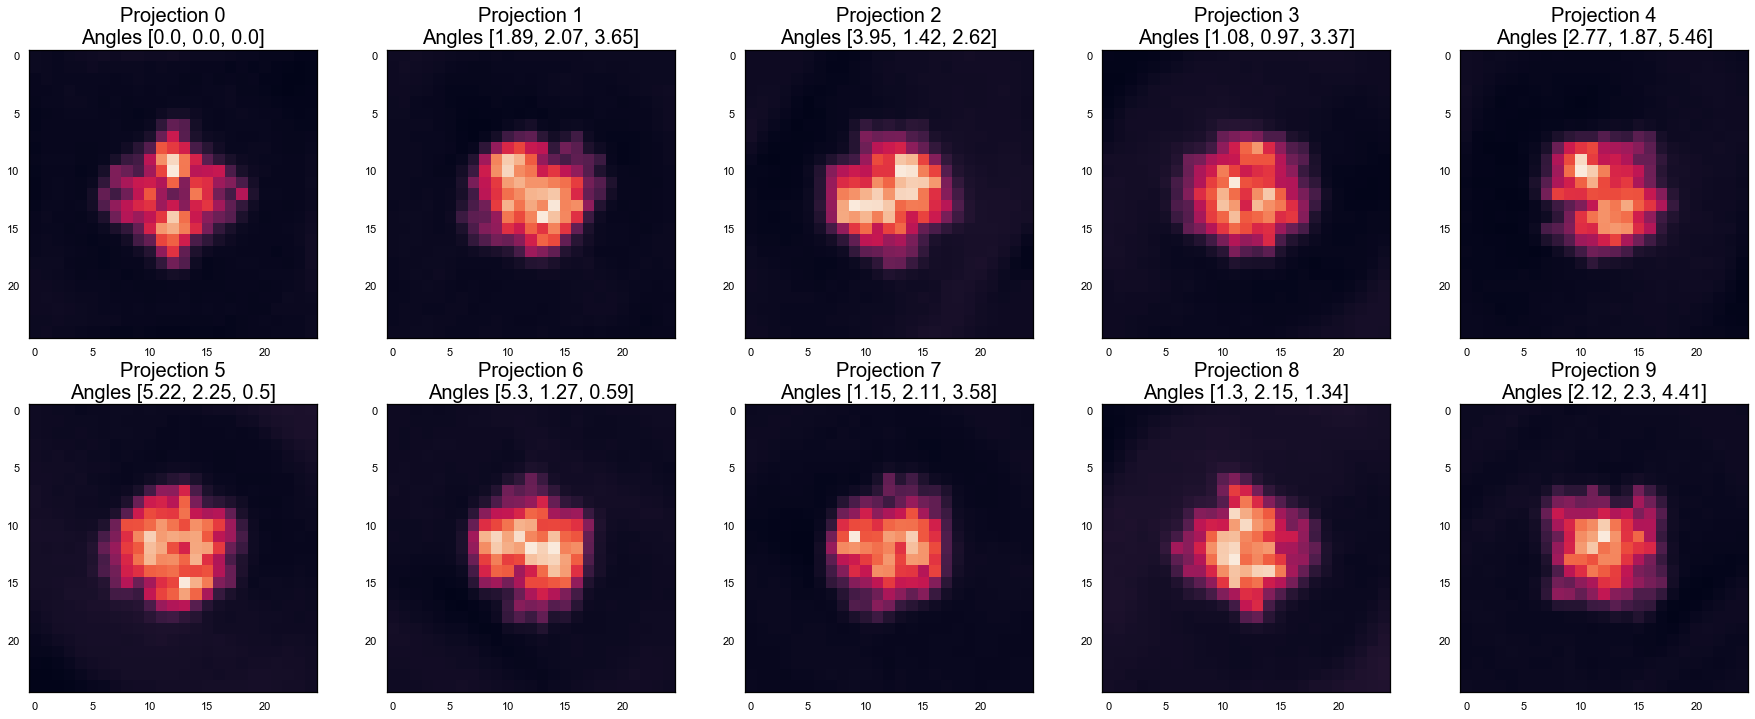

The 791-th iteration


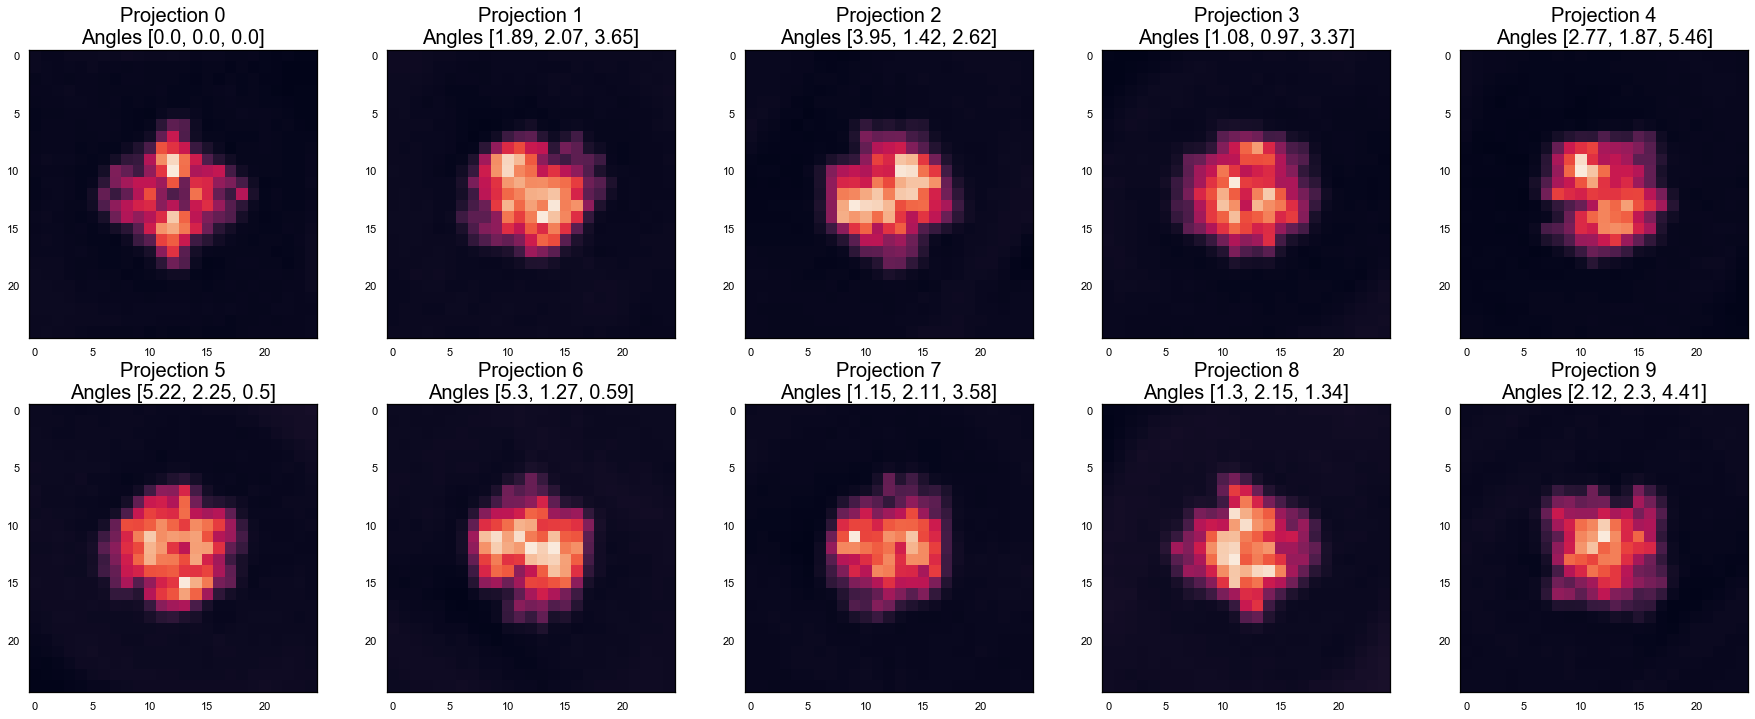

The 801-th iteration


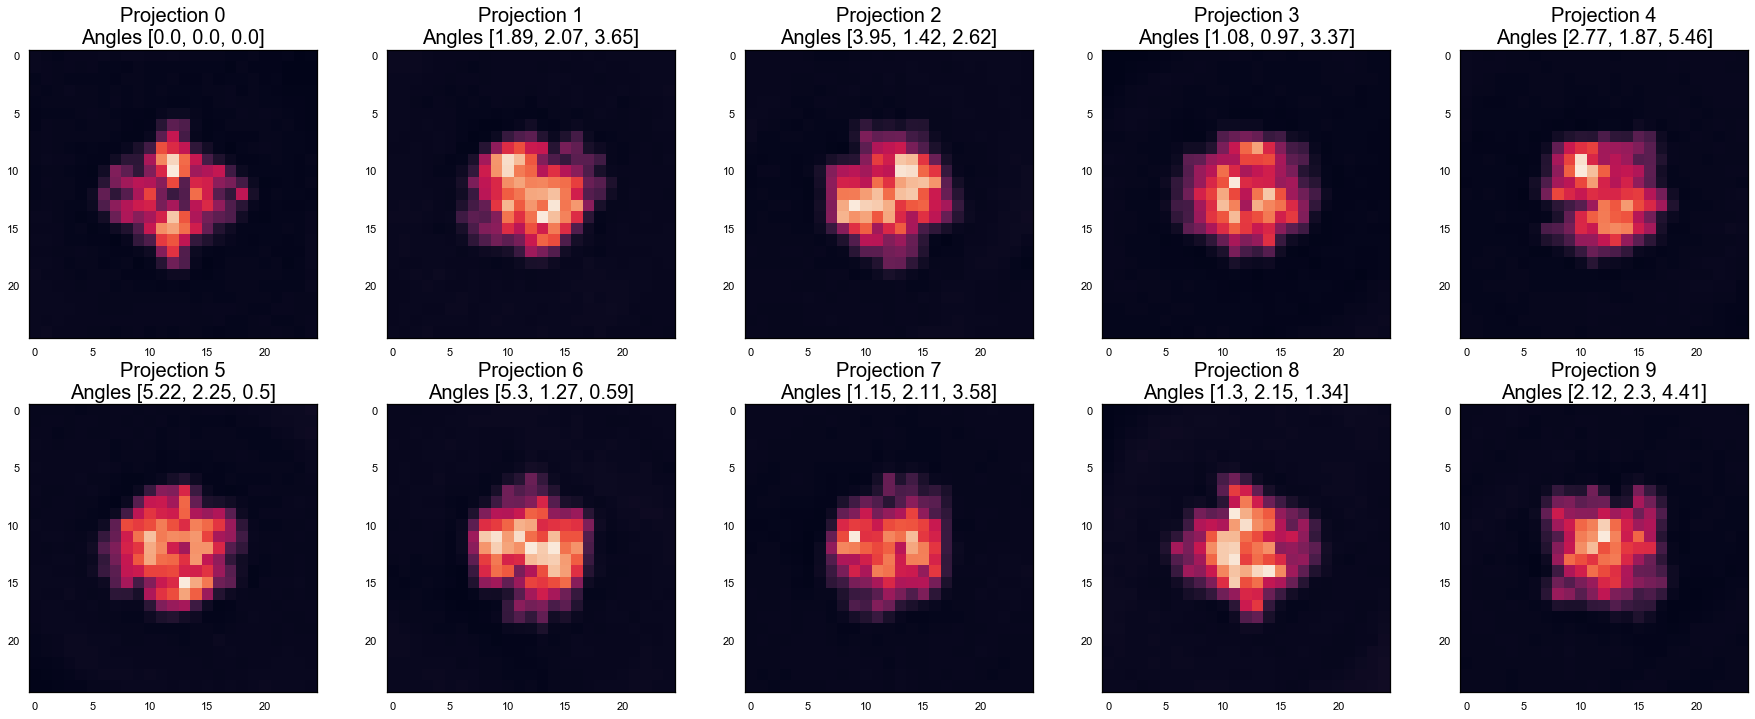

The 811-th iteration


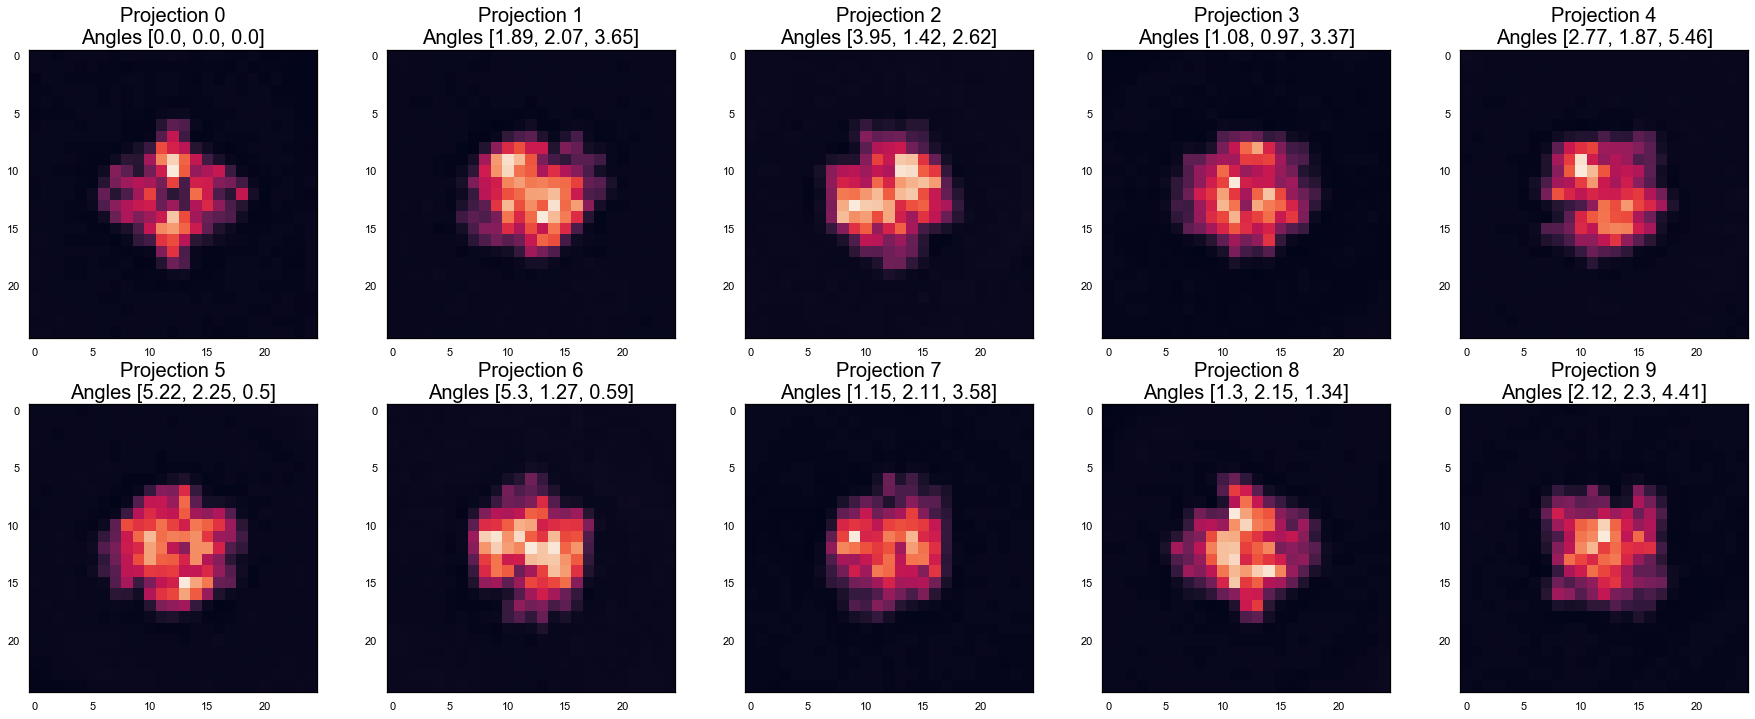

The 821-th iteration


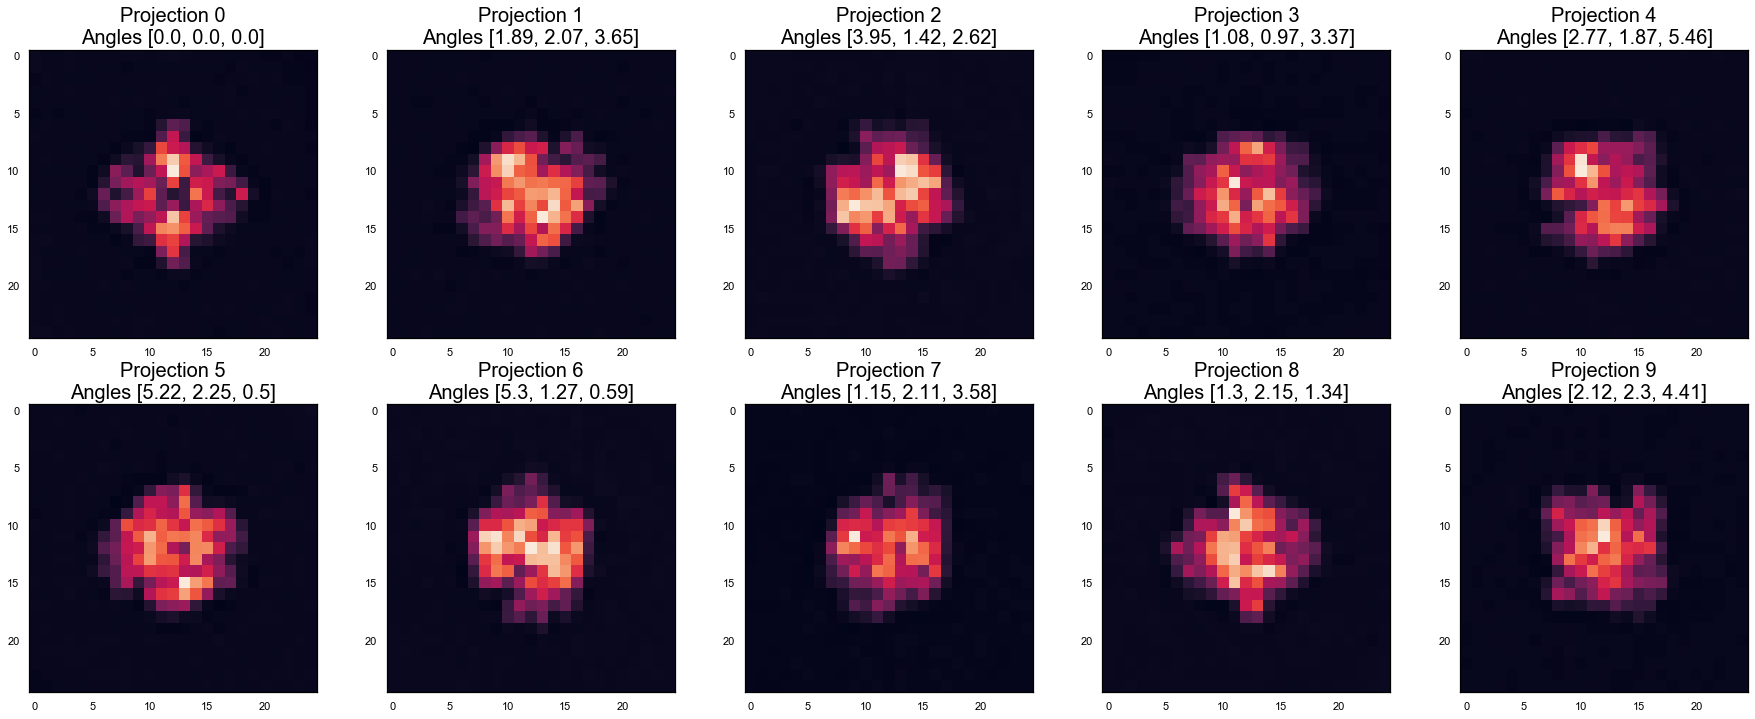

The 831-th iteration


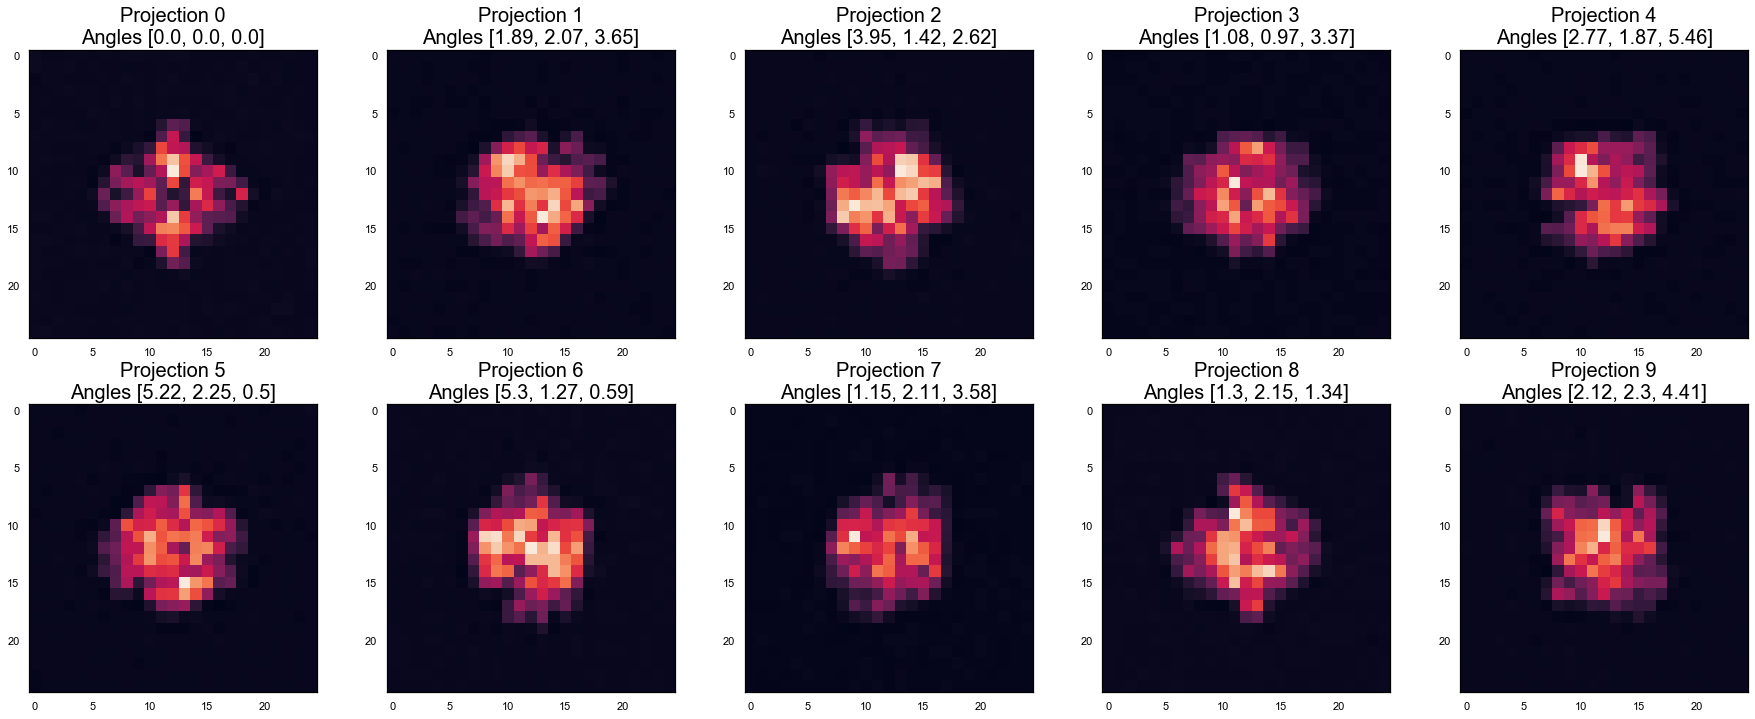

The 841-th iteration


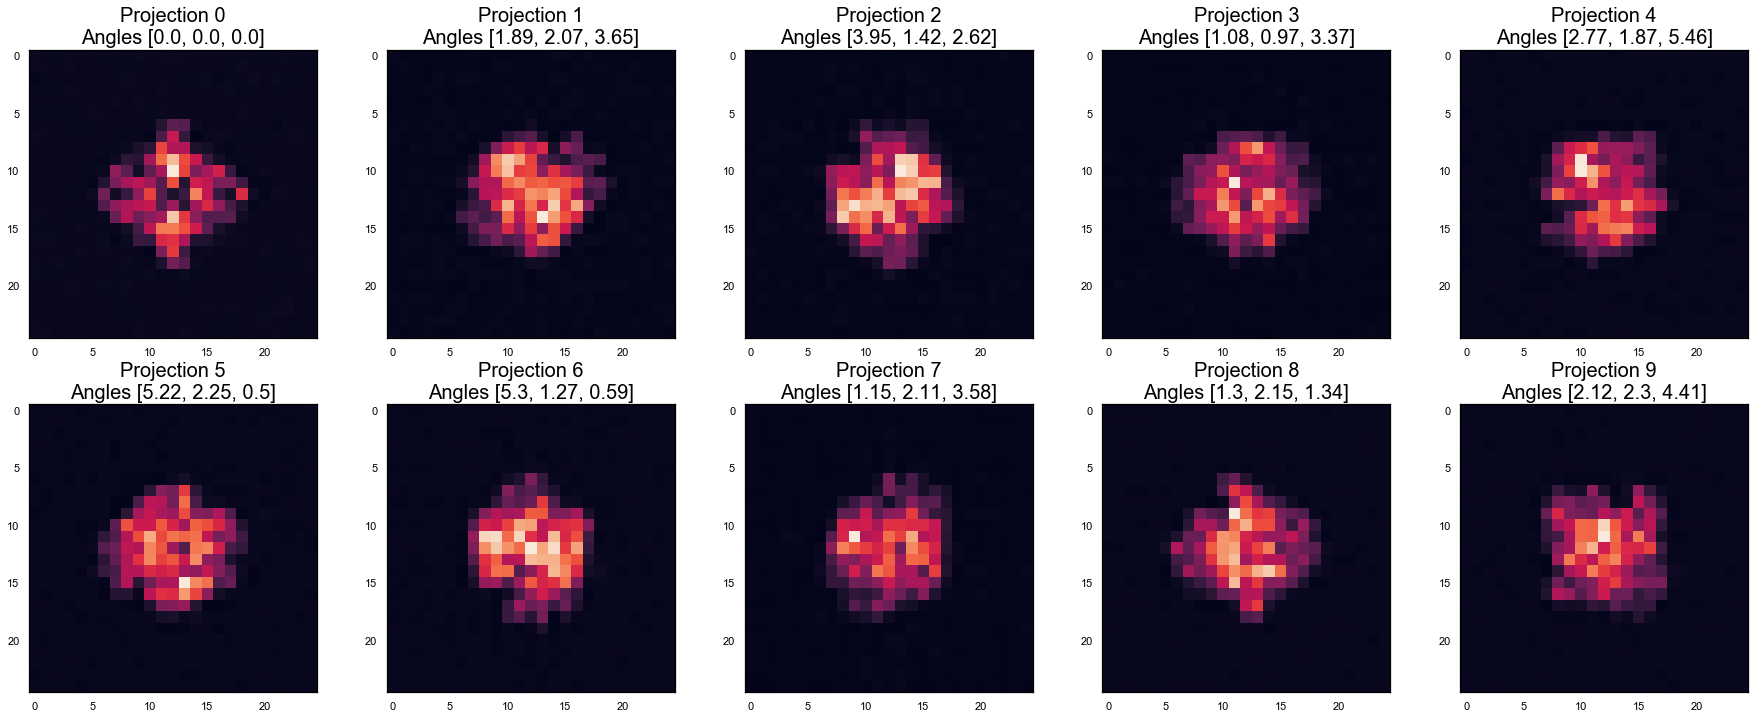

The 851-th iteration


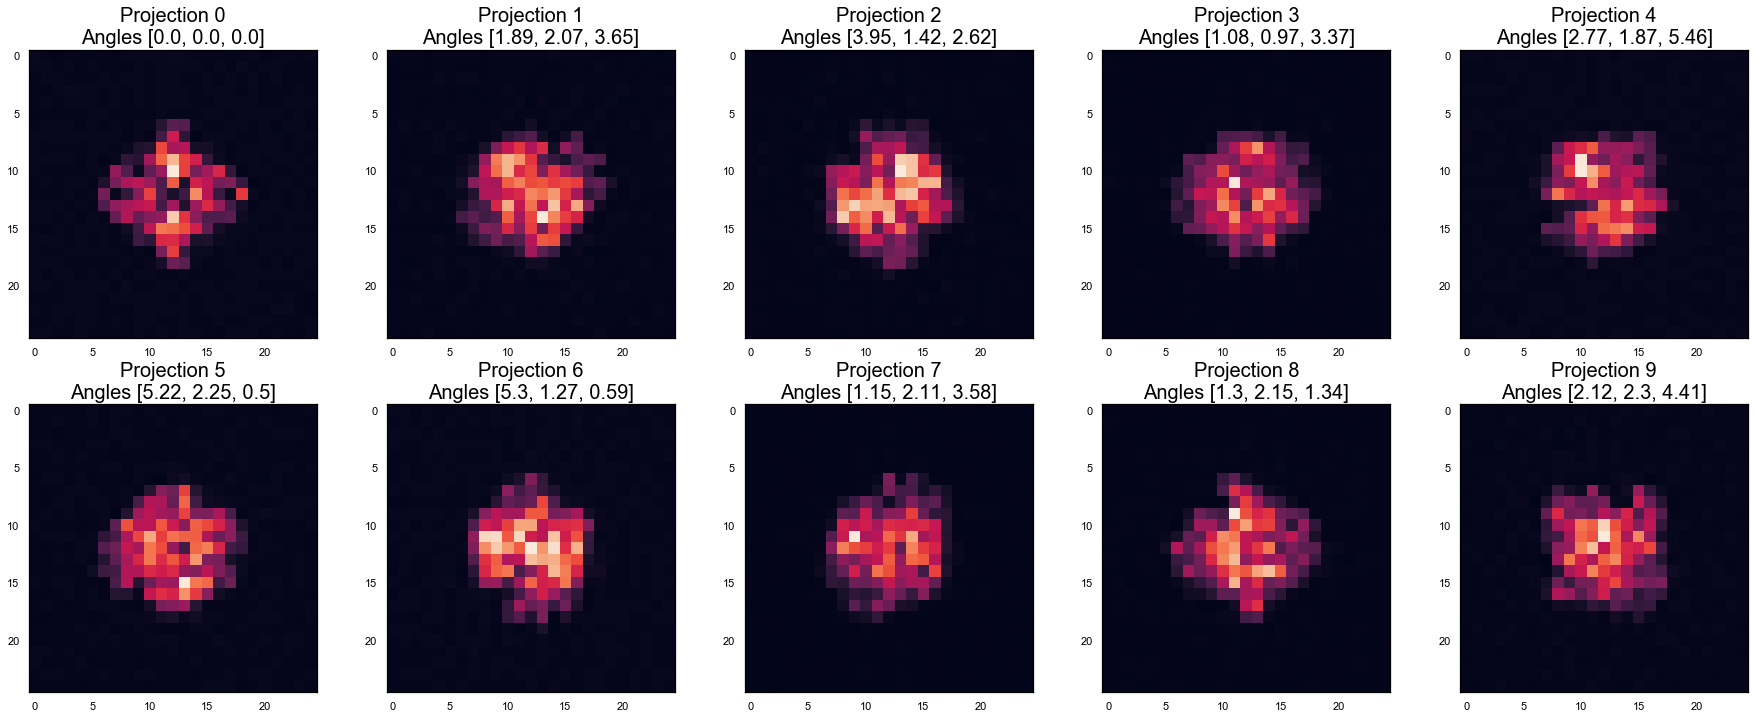

The 861-th iteration


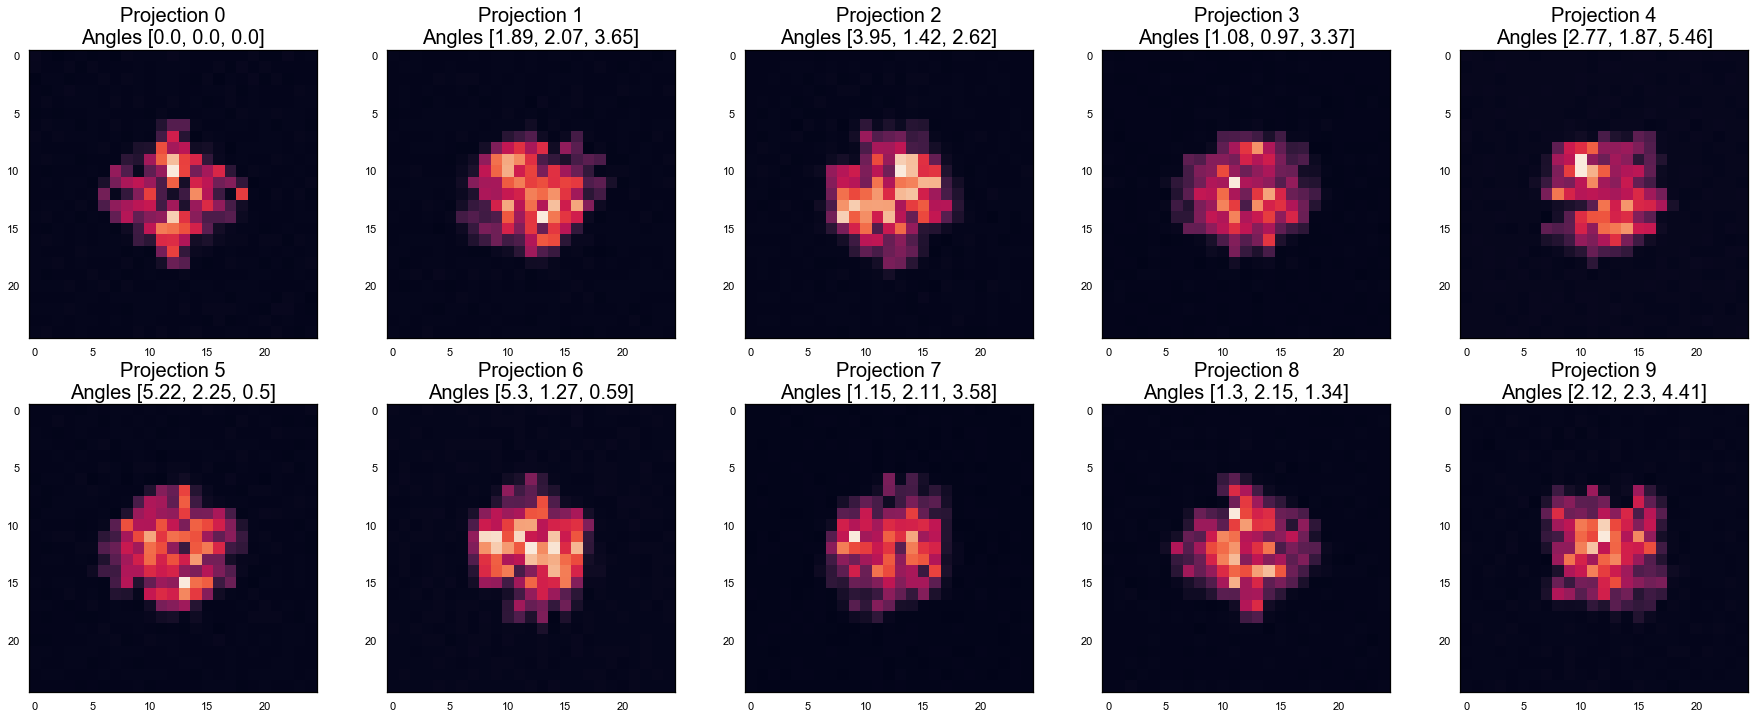

The 871-th iteration


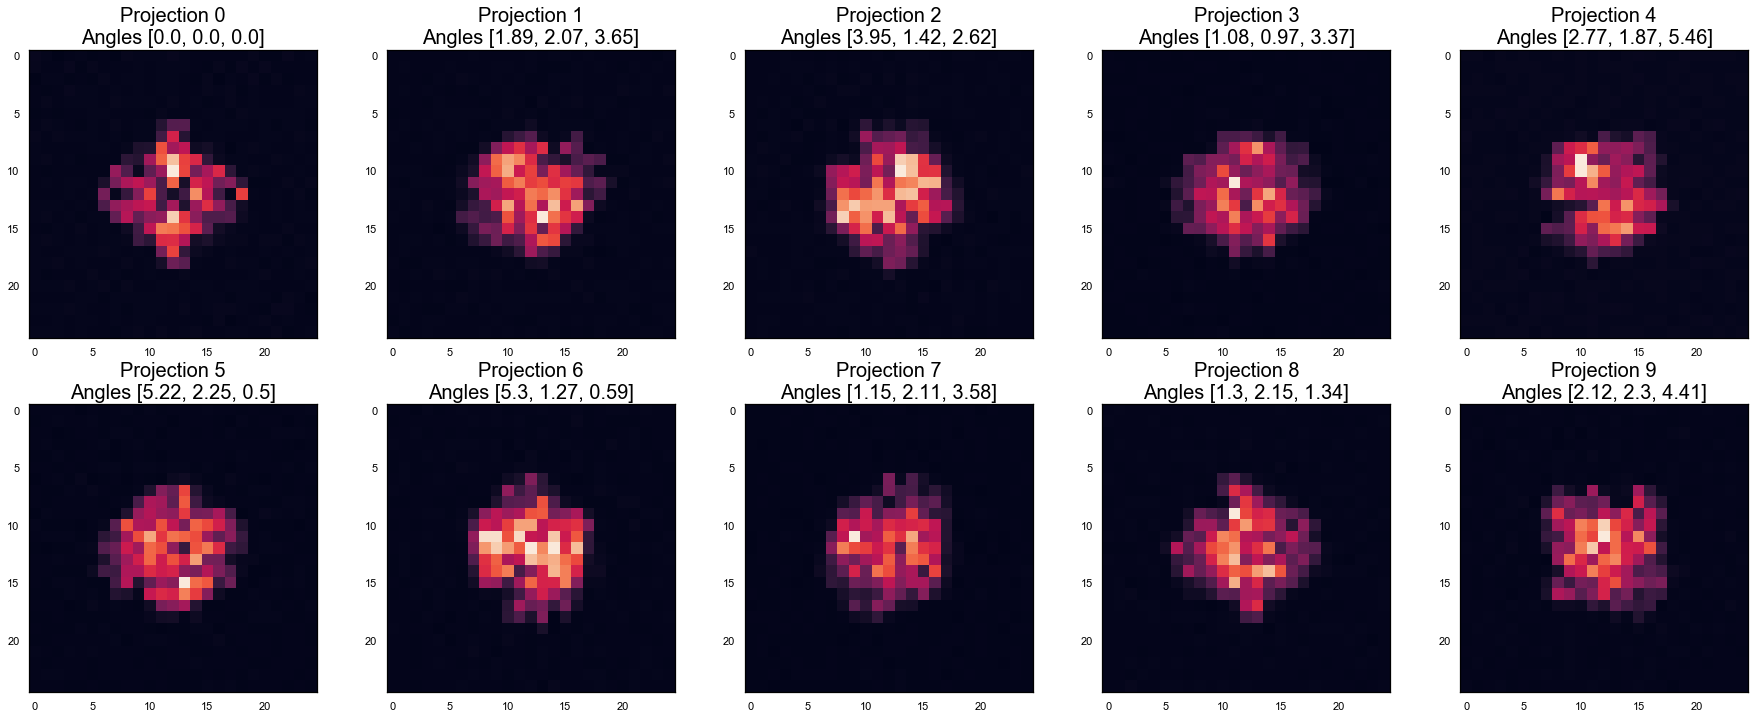

The 881-th iteration


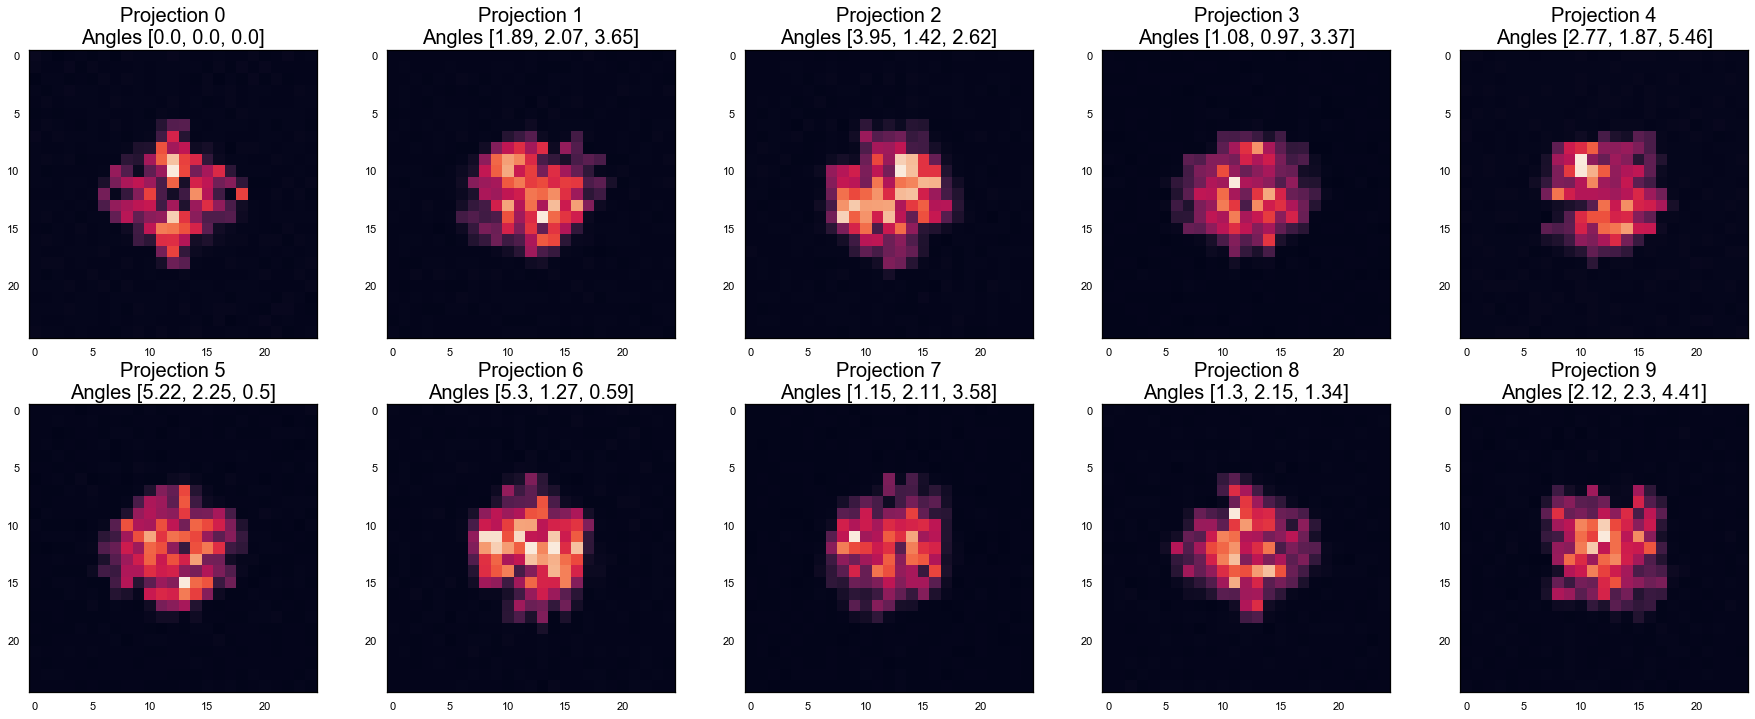

The 891-th iteration


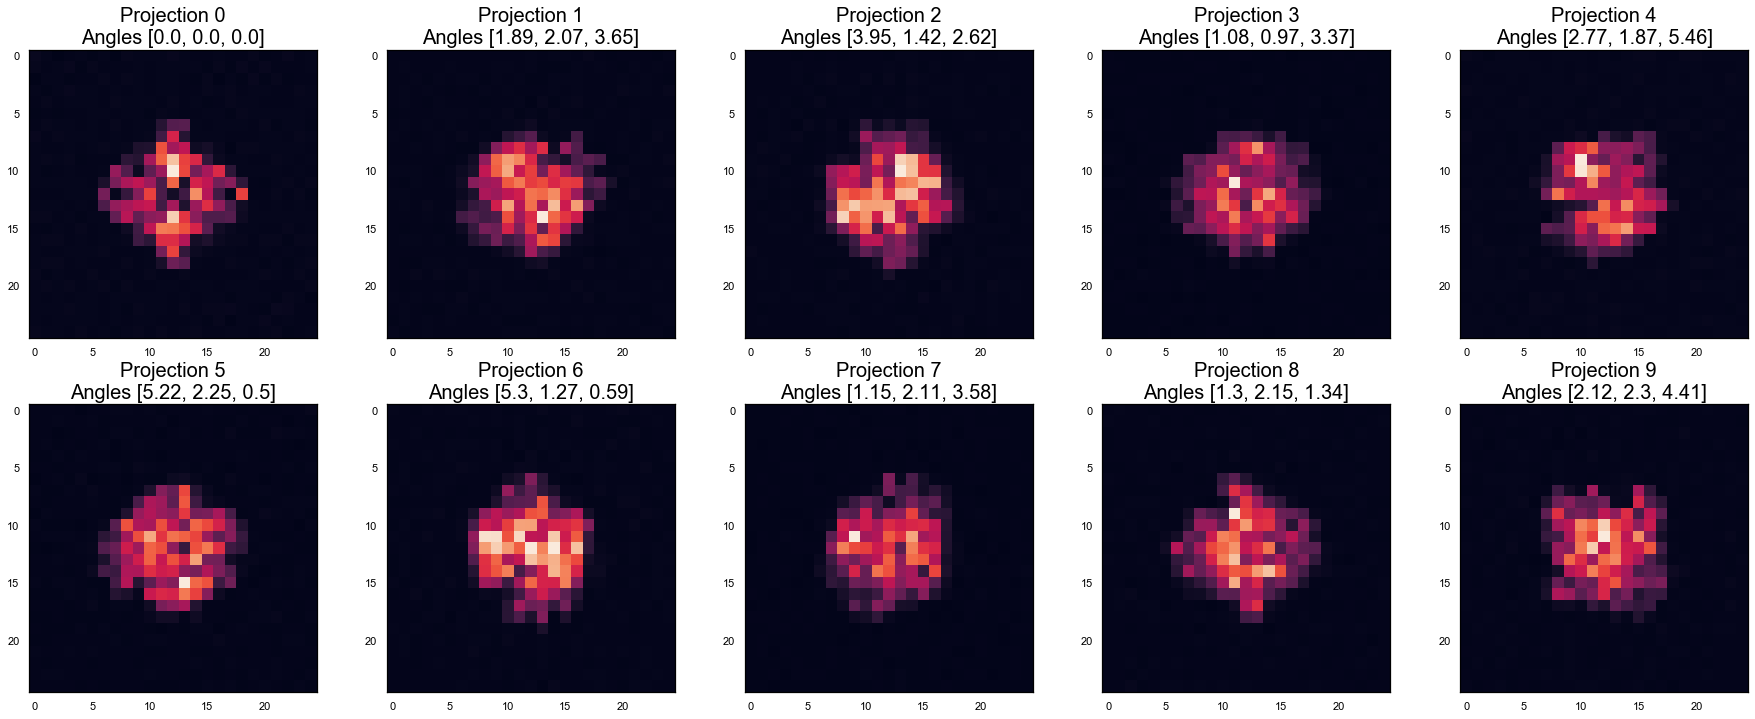

The 901-th iteration


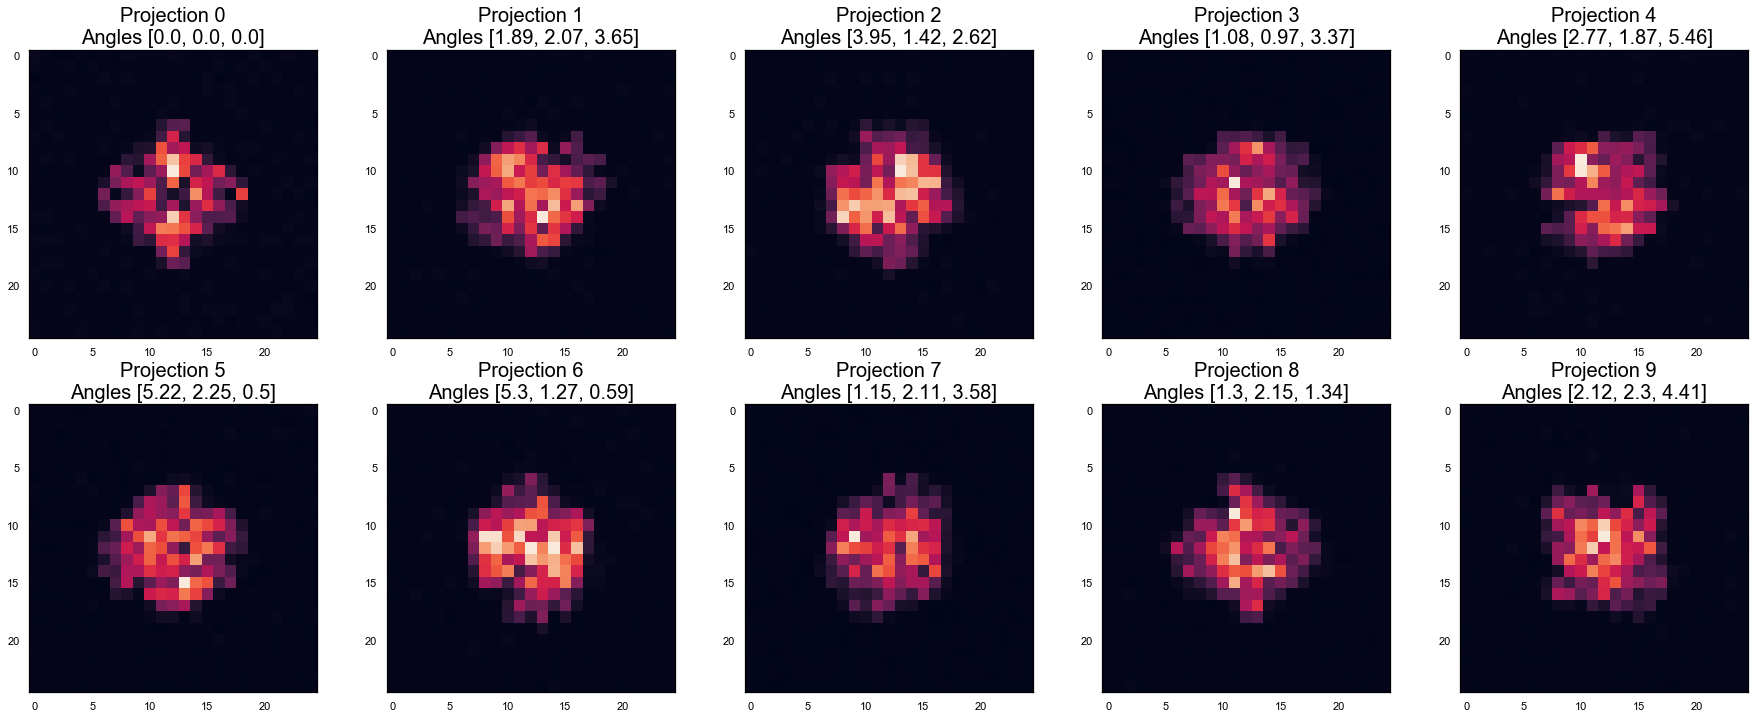

The 911-th iteration


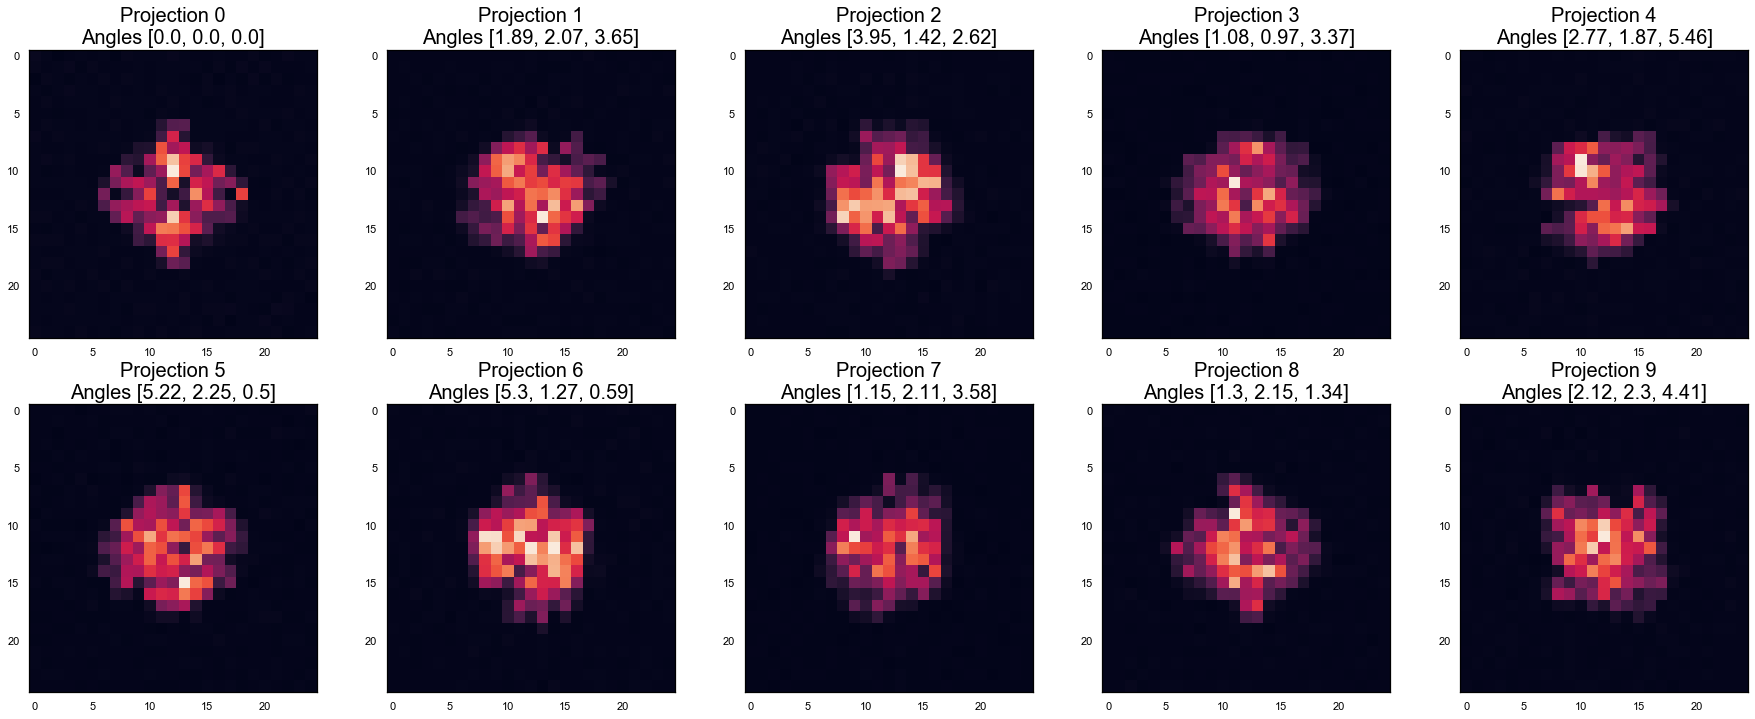

The 921-th iteration


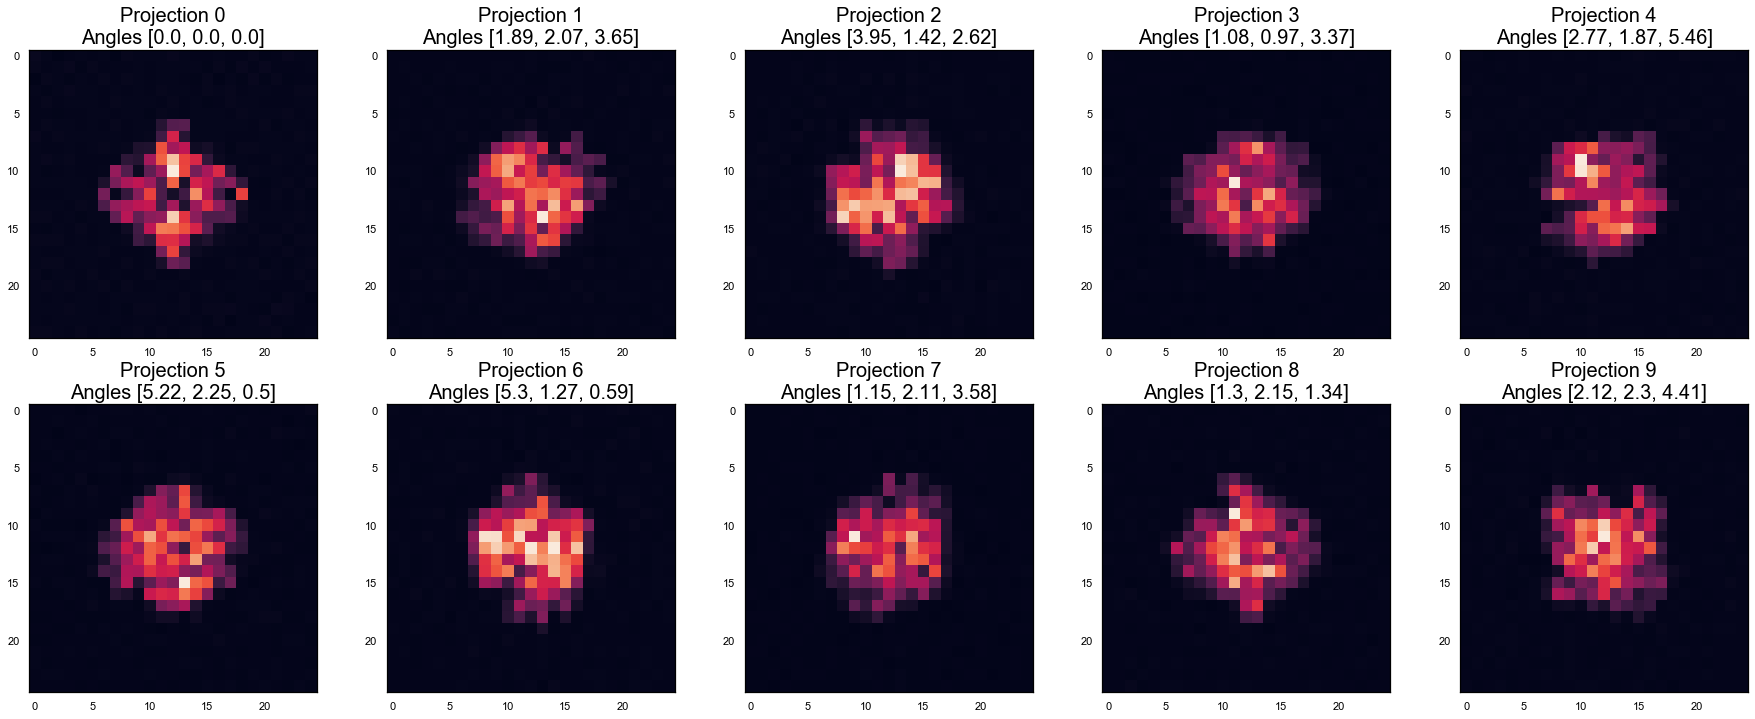

The 931-th iteration


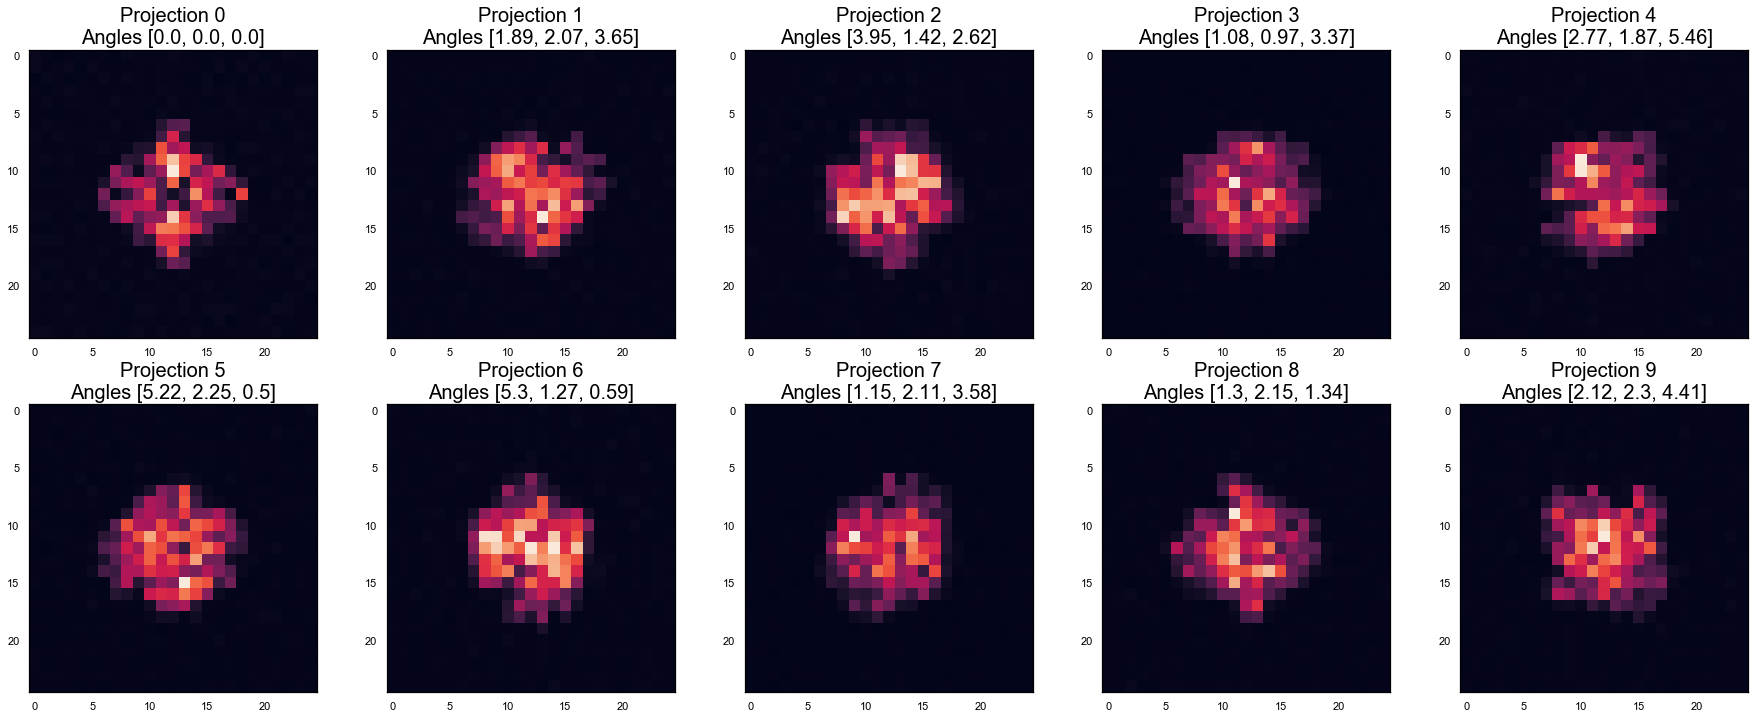

The 941-th iteration


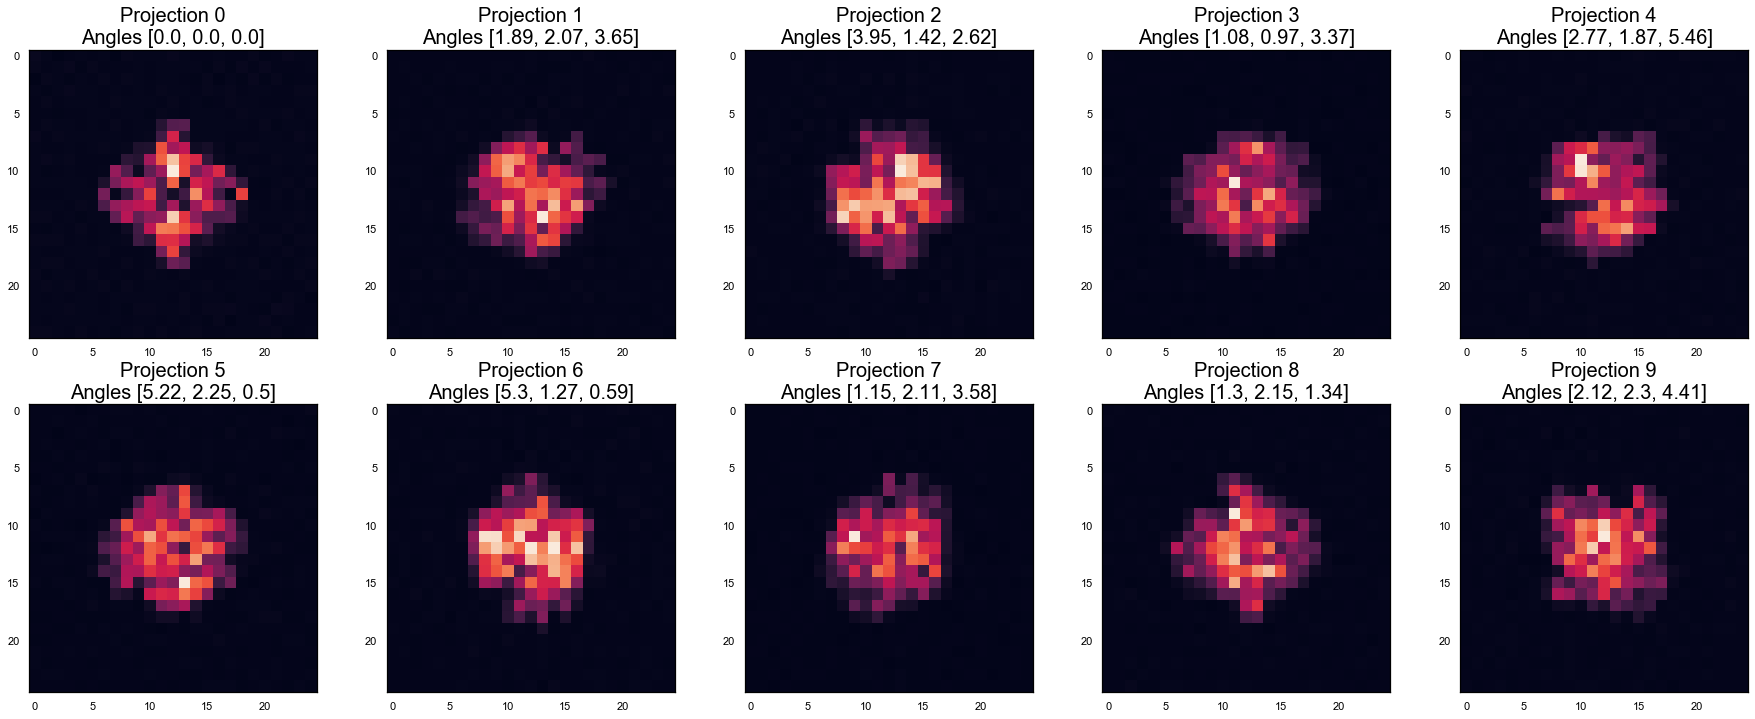

The 951-th iteration


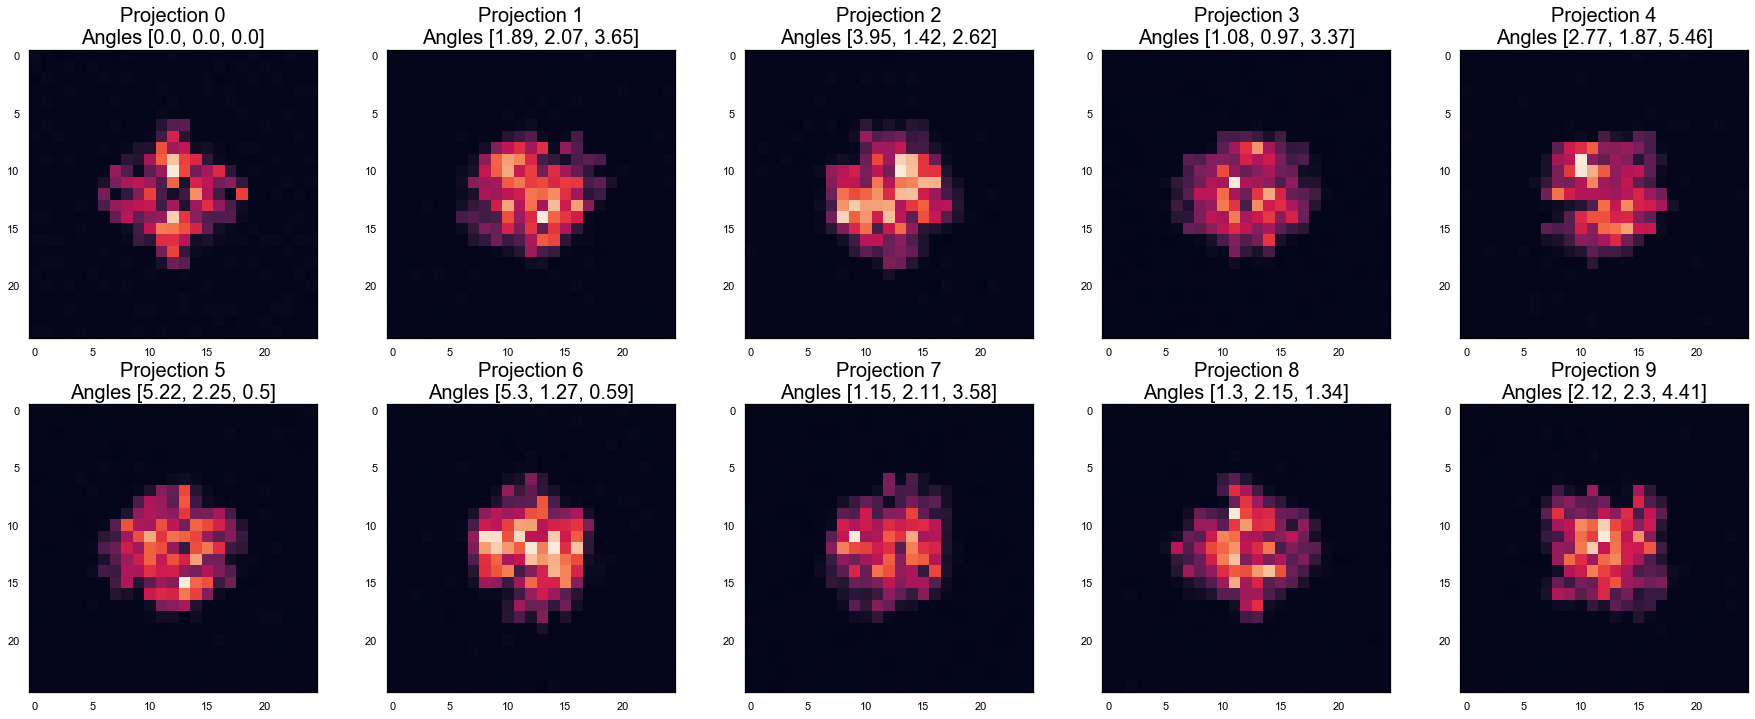

The 961-th iteration


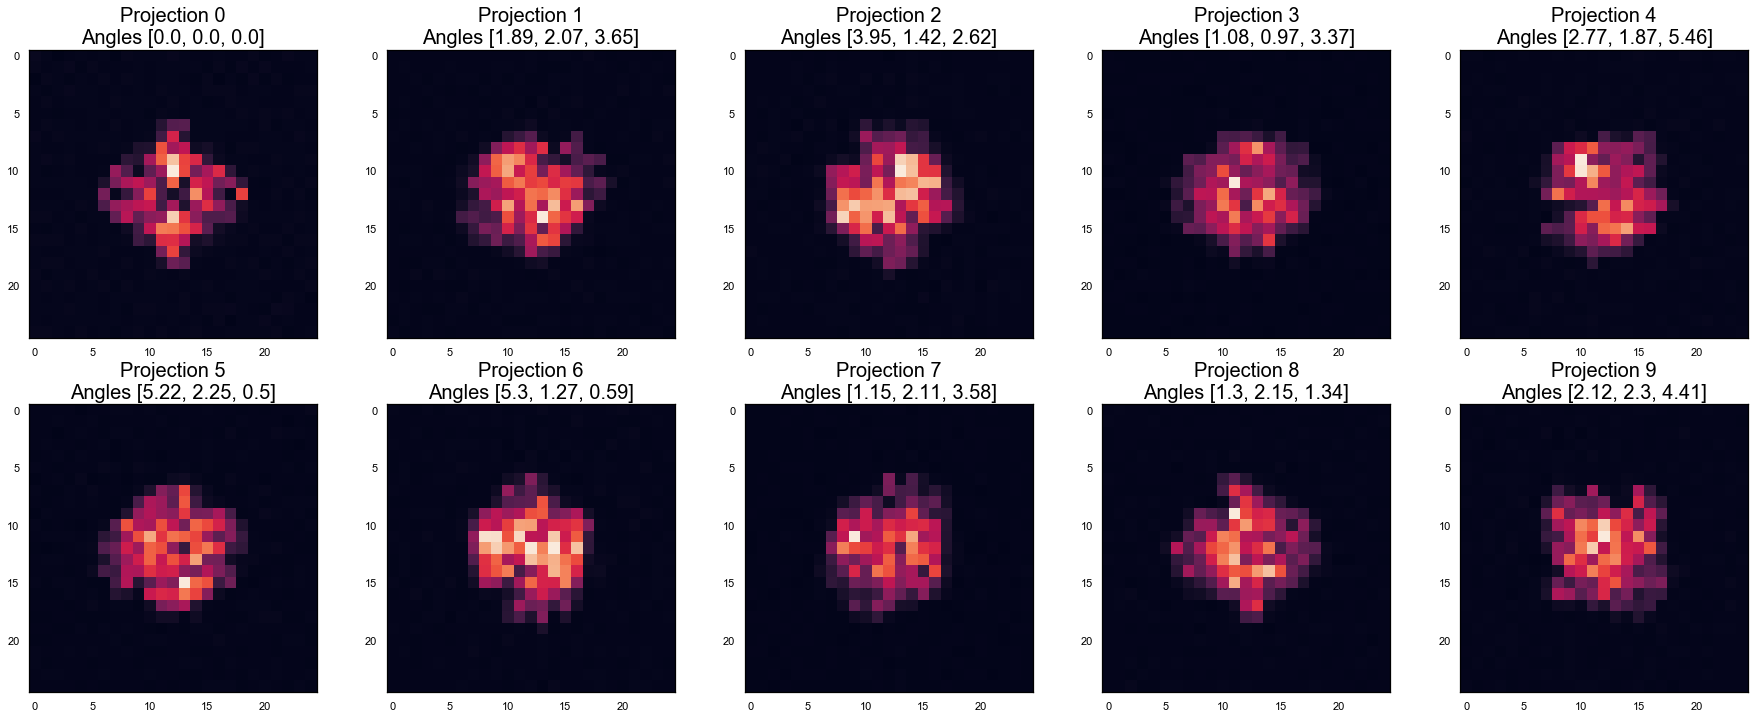

The 971-th iteration


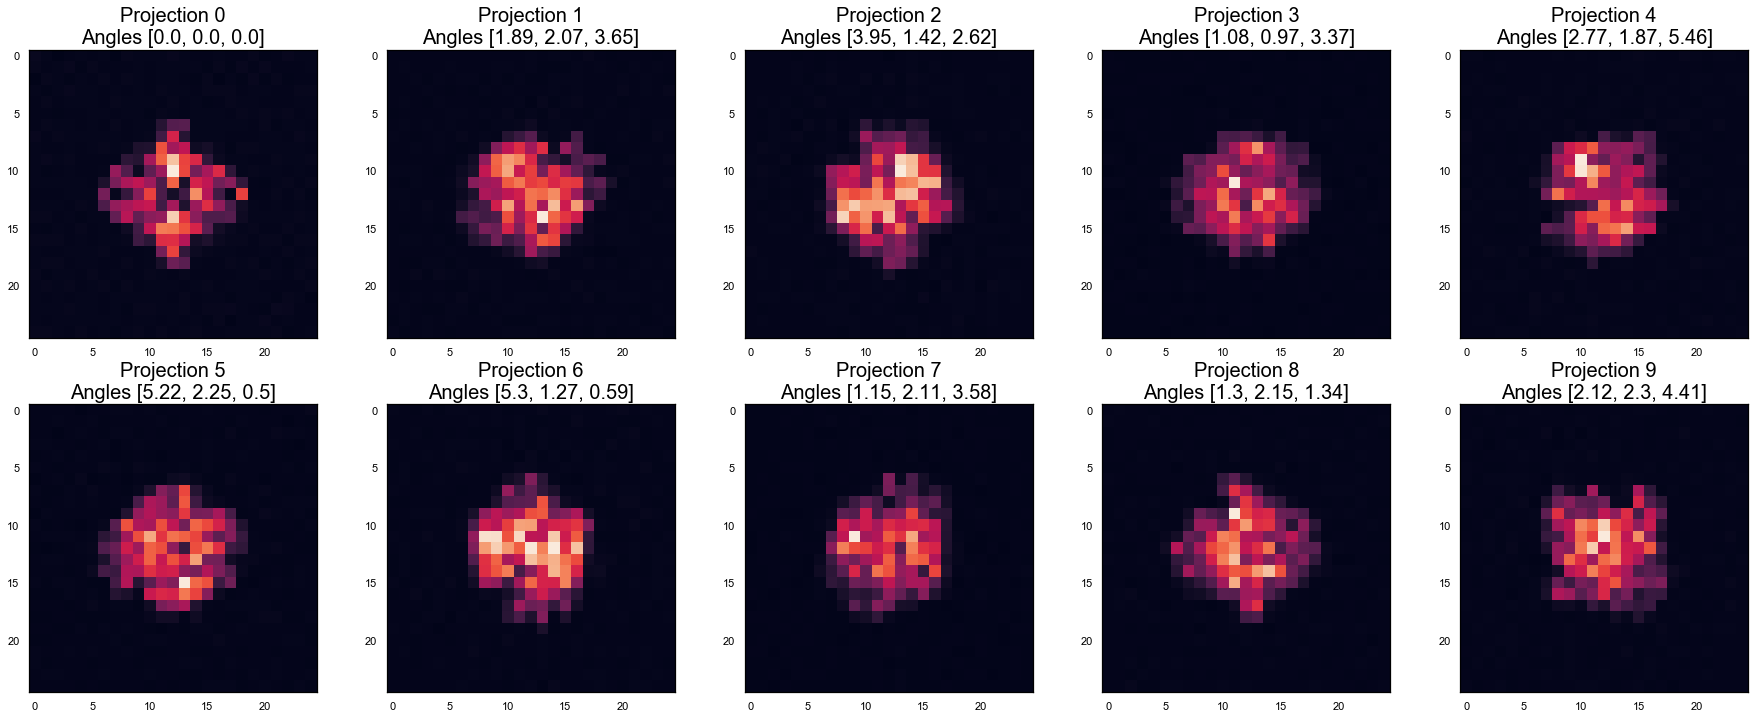

The 981-th iteration


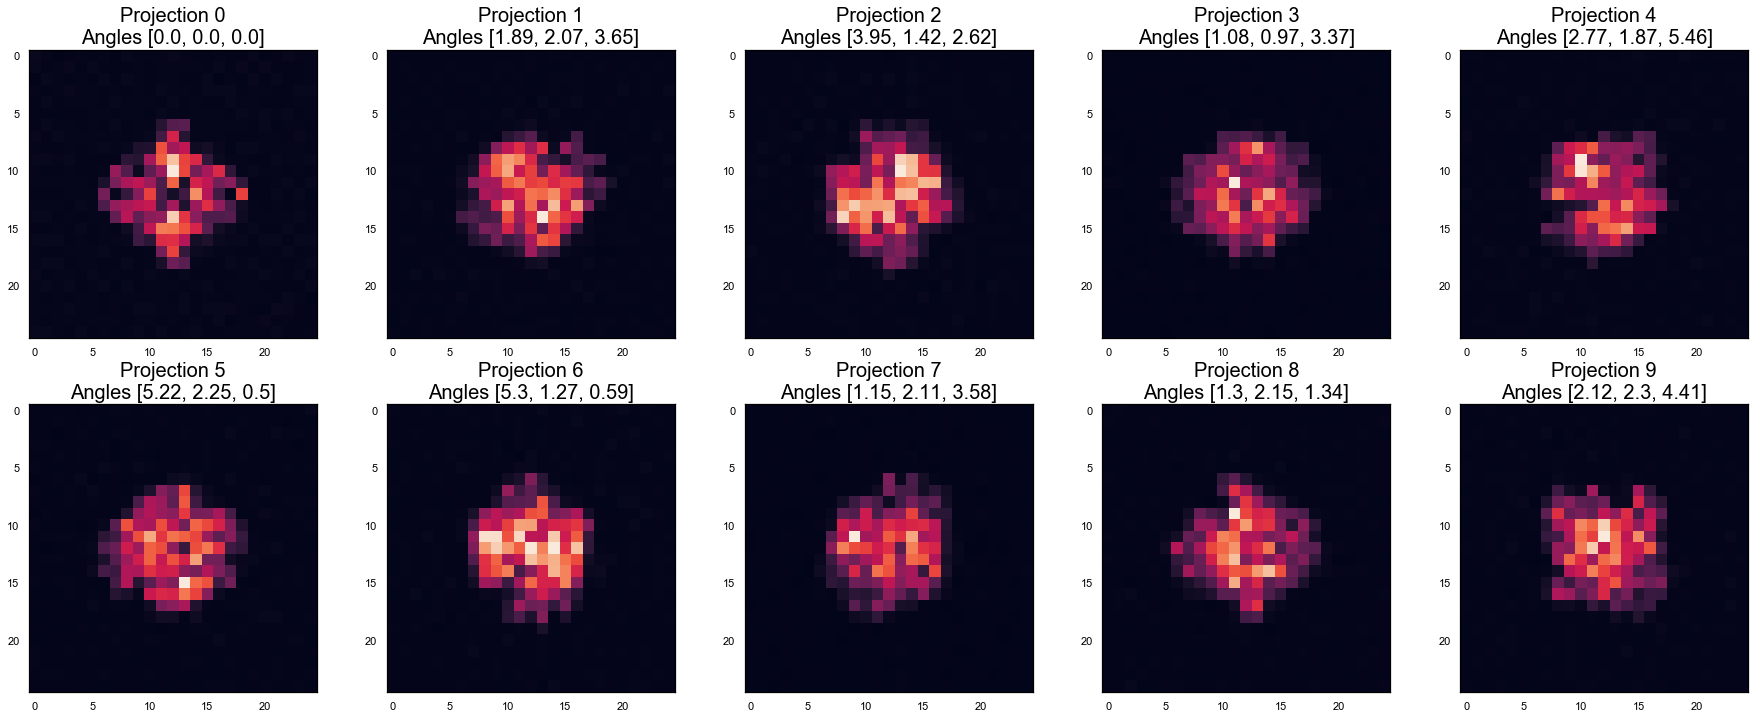

The 991-th iteration


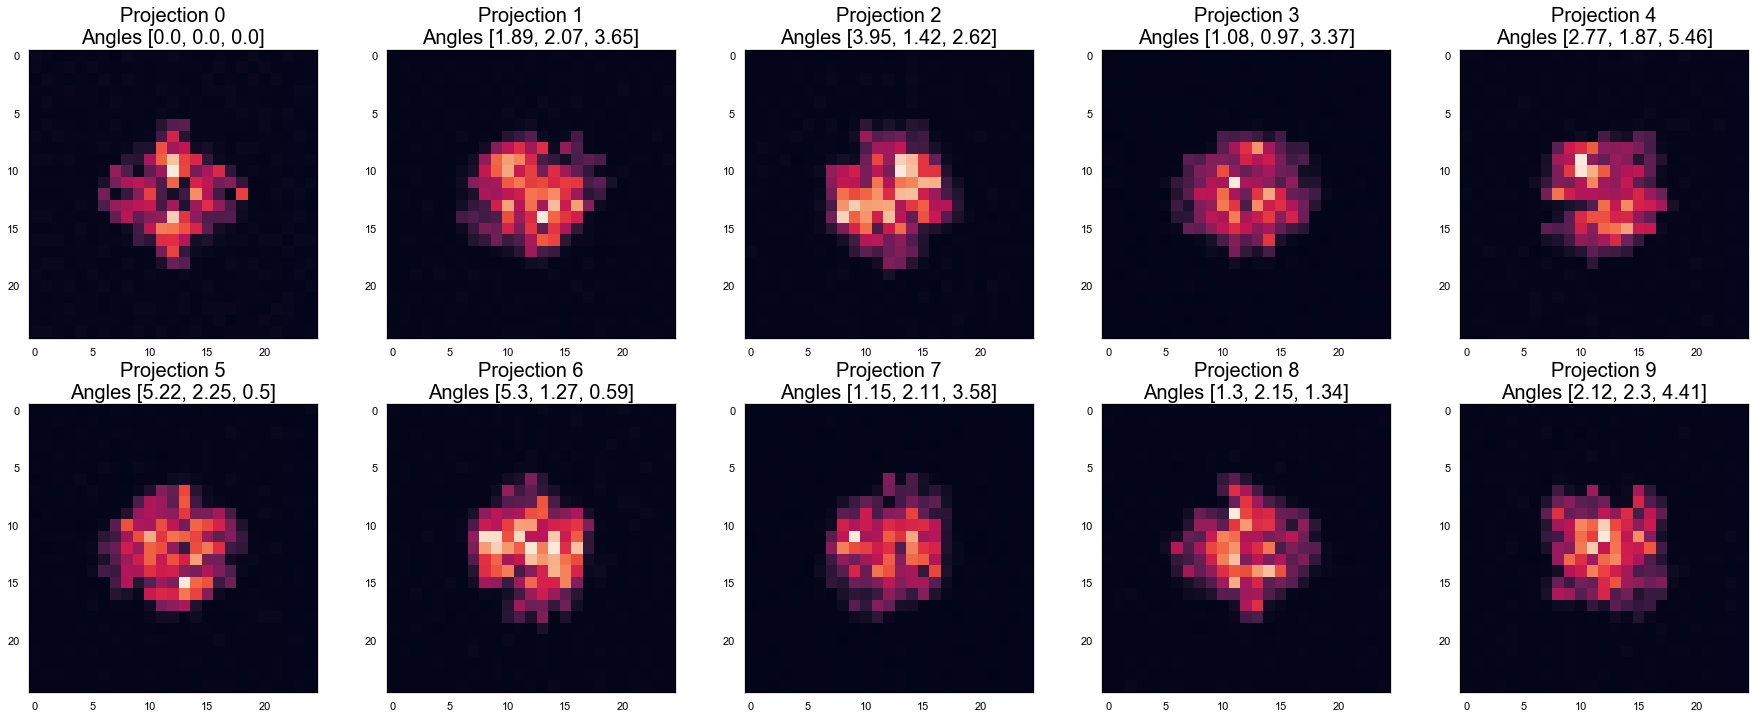

In [14]:
_, num_image , n_component = 116, 5000 , 1
angles2 = angles2[:num_image]
new_projection = new_projection[:num_image]
print('input noised image ')
plot_projections(new_projection[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

P3R = PCA_3d_Recon(ProjSize1, num_image, n_component)
P3R.Au_s(angles2)
#P3R.Q_(Projections, angles2)
#P3R.Expectation(Projections, angles2)
#P3R.Q_(Projections, angles2)
#P3R.Maximization(Projections, angles2)
#P3R.Q_(Projections, angles2)
P3R.fit(new_projection, angles2)


In [ ]:
P3R.sigma[0]

In [ ]:
#print(P3R.mu)
curremt_mu = P3R.mu.reshape(ProjSize,ProjSize,ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

In [ ]:
print(CheckProjections[0])